In [1]:
"""
STAGE 1: Data Preprocessing & COCO Conversion
==========================================================
Converts LabelMe annotations to COCO format
Preprocesses metadata (23 features, NO center, derived class labels)
Creates PATIENT-LEVEL, CENTER-AWARE stratified train/val/test splits

FIXES APPLIED:
✅ Patient-level splitting (prevents data leakage)
✅ Center-aware stratification (controls center bias)
✅ Label-free patient fingerprint (no tumor/benign/malignant)
✅ Includes normal images (tumor=0) with zero annotations

IMPORTANT NOTES:
1. Patient grouping is APPROXIMATED (no explicit patient IDs available)
2. This is PATIENT-LEVEL classification (not lesion or image level)
3. Center used ONLY for stratification (excluded from model inputs)
4. Normal images included for realistic class imbalance

Dataset: BTXRD Bone Tumor X-ray Dataset
"""

import json
import os
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration for Stage 1 preprocessing"""
    
    RAW_IMAGES_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/images"
    RAW_MASKS_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/masks"
    RAW_ANNOTATIONS_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/Annotations"
    METADATA_FILE = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/dataset.xlsx"
    
    OUTPUT_DIR = "preprocessed"
    
    # Splits (70% train, 15% val, 15% test)
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15
    RANDOM_SEED = 42
    
    # Metadata features: 23 features (NO center!)
    METADATA_FEATURES = [
        # Demographics (2 features)
        'age', 'gender',
        
        # Bone locations (9 features)
        'hand', 'ulna', 'radius', 'humerus', 'foot', 
        'tibia', 'fibula', 'femur', 'hip bone',
        
        # Joint involvement (6 features)
        'ankle-joint', 'knee-joint', 'hip-joint', 
        'wrist-joint', 'elbow-joint', 'shoulder-joint',
        
        # Body regions (3 features)
        'upper limb', 'lower limb', 'pelvis',
        
        # X-ray view (3 features)
        'frontal', 'lateral', 'oblique'
    ]
    
    # Label derivation logic:
    # tumor=0 → class_label=0 (Normal)
    # tumor=1, benign=1 → class_label=1 (Benign)
    # tumor=1, malignant=1 → class_label=2 (Malignant)
    CLASS_NAMES = ['Normal', 'Benign', 'Malignant']
    
    # ✅ FIXED: COCO categories (category_id MUST be 1, not 0)
    # Detectron2 internally remaps to 0-indexed, but COCO format requires 1-indexed
    COCO_CATEGORIES = [
        {"id": 1, "name": "tumor", "supercategory": "lesion"}
    ]


# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def create_directory_structure():
    """Create output directory structure"""
    dirs = [
        Config.OUTPUT_DIR,
        f"{Config.OUTPUT_DIR}/coco_annotations",
        f"{Config.OUTPUT_DIR}/metadata_processed",
        f"{Config.OUTPUT_DIR}/splits",
        f"{Config.OUTPUT_DIR}/logs"
    ]
    for d in dirs:
        os.makedirs(d, exist_ok=True)
    print("✅ Directory structure created")


def polygon_to_bbox(points):
    """Convert polygon points to bounding box [x, y, width, height]"""
    points = np.array(points)
    x_min, y_min = points[:, 0].min(), points[:, 1].min()
    x_max, y_max = points[:, 0].max(), points[:, 1].max()
    width = x_max - x_min
    height = y_max - y_min
    return [float(x_min), float(y_min), float(width), float(height)]


def polygon_to_segmentation(points):
    """Convert polygon points to COCO segmentation format"""
    return [float(coord) for point in points for coord in point]


def compute_area(points):
    """Compute polygon area using shoelace formula"""
    points = np.array(points)
    x = points[:, 0]
    y = points[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))


# ============================================================================
# ANNOTATION CONVERSION (LabelMe → COCO) - **INCLUDES NORMAL IMAGES**
# ============================================================================

def convert_labelme_to_coco(image_ids, split_name):
    """
    Convert LabelMe annotations to COCO format for given image_ids
    
    ✅ FIXED: category_id = 1 (COCO standard)
           Detectron2 internally remaps to 0-indexed for training
    ✅ NEW: Includes normal images (tumor=0) with zero annotations
    ✅ NOTE: image_id is split-local (valid since each split has separate COCO JSON)
    
    Args:
        image_ids: List of image filenames
        split_name: 'train', 'val', or 'test'
    
    Returns:
        dict: COCO format annotations
    """
    
    coco_output = {
        "info": {
            "description": "BTXRD Bone Tumor Dataset",
            "version": "1.0",
            "year": 2026,
            "contributor": "BTXRD Team",
            "date_created": "2026-01-19"
        },
        "licenses": [],
        "categories": Config.COCO_CATEGORIES,
        "images": [],
        "annotations": []
    }
    
    annotation_id = 1
    skipped_images = []
    skipped_reasons = {"no_image": 0}
    normal_images_count = 0  # Track normal images
    
    print(f"\n🔄 Converting {split_name} set: {len(image_ids)} images")
    
    for idx, image_id in enumerate(tqdm(image_ids, desc=f"Processing {split_name}")):
        json_path = Path(Config.RAW_ANNOTATIONS_DIR) / f"{Path(image_id).stem}.json"
        img_path = Path(Config.RAW_IMAGES_DIR) / image_id
        
        # Check image file exists (don't skip if no JSON!)
        if not img_path.exists():
            skipped_images.append(image_id)
            skipped_reasons["no_image"] += 1
            continue
        
        # Get image dimensions
        try:
            img = Image.open(img_path)
            width, height = img.size
            img.close()
        except Exception as e:
            print(f"⚠️  Error opening image {img_path}: {e}")
            skipped_images.append(image_id)
            skipped_reasons["no_image"] += 1
            continue
        
        # ✅ CLARIFICATION: image_id is split-local (idx + 1)
        # This is valid because each split (train/val/test) has its own COCO JSON
        # Global uniqueness is not required across splits
        image_info = {
            "id": idx + 1,  # Split-local ID (starts at 1 per COCO convention)
            "file_name": image_id,
            "width": width,
            "height": height
        }
        coco_output["images"].append(image_info)
        
        # Process annotations IF JSON exists
        if json_path.exists():
            try:
                with open(json_path, 'r', encoding='utf-8') as f:
                    labelme_data = json.load(f)
            except Exception as e:
                print(f"⚠️  Error reading {json_path}: {e}")
                # Image still added above (normal case)
                normal_images_count += 1
                continue
            
            polygon_count = 0
            for shape in labelme_data.get("shapes", []):
                if shape["shape_type"] != "polygon":
                    continue
                
                points = shape["points"]
                if len(points) < 3:
                    continue
                
                try:
                    bbox = polygon_to_bbox(points)
                    segmentation = [polygon_to_segmentation(points)]
                    area = compute_area(points)
                except Exception as e:
                    print(f"⚠️  Error processing polygon in {image_id}: {e}")
                    continue
                
                if area < 100:
                    continue
                
                # ✅ FIXED: category_id = 1 (COCO standard)
                # Detectron2 will internally remap this to 0 during training
                annotation = {
                    "id": annotation_id,
                    "image_id": idx + 1,  # References split-local image_id
                    "category_id": 1,  # ✅ 1 for COCO standard (not 0!)
                    "bbox": bbox,
                    "segmentation": segmentation,
                    "area": float(area),
                    "iscrowd": 0
                }
                coco_output["annotations"].append(annotation)
                annotation_id += 1
                polygon_count += 1
            
            if polygon_count == 0:
                # Image with JSON but no valid polygons → likely normal
                normal_images_count += 1
        else:
            # No JSON → normal image (tumor=0)
            normal_images_count += 1
    
    output_path = Path(Config.OUTPUT_DIR) / "coco_annotations" / f"{split_name}.json"
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(coco_output, f, indent=2)
    
    # Improved statistics
    images_with_annotations = len(set(ann['image_id'] for ann in coco_output['annotations']))
    
    print(f"✅ {split_name}.json saved:")
    print(f"   Total images: {len(coco_output['images'])}")
    print(f"   Images with annotations: {images_with_annotations}")
    print(f"   Images without annotations (normal): {normal_images_count}")
    print(f"   Total annotations: {len(coco_output['annotations'])}")
    print(f"   ℹ️  Note: Normal images included for realistic class imbalance")
    
    if skipped_images:
        print(f"⚠️  Skipped {len(skipped_images)} images:")
        print(f"   - No image file: {skipped_reasons['no_image']}")
        
        skipped_path = Path(Config.OUTPUT_DIR) / "logs" / f"skipped_{split_name}.txt"
        with open(skipped_path, 'w') as f:
            f.write('\n'.join(skipped_images))
    
    return coco_output


# ============================================================================
# PATIENT GROUPING (LABEL-FREE)
# ============================================================================

def create_patient_groups(metadata_df):
    """
    Group images by patient using ONLY non-label features
    
    ⚠️ IMPORTANT LIMITATION:
    Because explicit patient identifiers are unavailable in this dataset,
    patient grouping is APPROXIMATED using demographic and anatomical metadata.
    This may result in limited patient ambiguity in rare edge cases.
    
    Patient fingerprint includes:
    ✅ center (institutional identifier)
    ✅ age (demographic proxy)
    ✅ gender (demographic proxy)
    ✅ anatomy_fingerprint (body location)
    ✅ joint_fingerprint (joint involvement)
    
    ❌ EXCLUDES (prevents label leakage):
    ❌ tumor, benign, malignant (diagnostic labels)
    
    📌 FOR PUBLICATION:
    Add this to Methods section:
    "Because explicit patient identifiers were unavailable, patient grouping was
    approximated using demographic and anatomical metadata, which may result in
    limited patient ambiguity in rare cases."
    
    Returns:
        DataFrame with patient_id column
    """
    
    df = metadata_df.copy()
    
    # Verify required columns
    required_cols = ['center', 'age', 'gender']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        print(f"❌ ERROR: Missing required columns: {missing}")
        return None
    
    # Create anatomical fingerprint (bone location)
    anatomy_cols = ['hand', 'ulna', 'radius', 'humerus', 'foot', 
                    'tibia', 'fibula', 'femur', 'hip bone']
    available_anatomy = [col for col in anatomy_cols if col in df.columns]
    
    if not available_anatomy:
        print(f"⚠️  WARNING: No anatomy columns found!")
        df['anatomy_fingerprint'] = '0'
    else:
        df['anatomy_fingerprint'] = df[available_anatomy].astype(str).agg(''.join, axis=1)
    
    # Create joint fingerprint (joint involvement)
    joint_cols = ['ankle-joint', 'knee-joint', 'hip-joint', 
                  'wrist-joint', 'elbow-joint', 'shoulder-joint']
    available_joints = [col for col in joint_cols if col in df.columns]
    
    if not available_joints:
        print(f"⚠️  WARNING: No joint columns found!")
        df['joint_fingerprint'] = '0'
    else:
        df['joint_fingerprint'] = df[available_joints].astype(str).agg(''.join, axis=1)
    
    # ✅ Patient fingerprint WITHOUT labels (prevents leakage)
    df['patient_fingerprint'] = (
        df['center'].astype(str) + '_' +
        df['age'].astype(str) + '_' +
        df['gender'] + '_' +
        df['anatomy_fingerprint'] + '_' +
        df['joint_fingerprint']
    )
    
    # Assign patient IDs
    patient_id = 0
    patient_mapping = {}
    
    for fingerprint, group in df.groupby('patient_fingerprint'):
        patient_id += 1
        for img_id in group['image_id']:
            patient_mapping[img_id] = patient_id
    
    df['patient_id'] = df['image_id'].map(patient_mapping)
    
    # Statistics
    print(f"\n📊 Patient grouping statistics:")
    print(f"   Total images: {len(df)}")
    print(f"   Unique patients: {df['patient_id'].nunique()}")
    print(f"   Avg images per patient: {len(df) / df['patient_id'].nunique():.2f}")
    
    # Multi-view patients
    patient_counts = df.groupby('patient_id').size()
    multi_image_patients = (patient_counts > 1).sum()
    print(f"   Patients with multiple views: {multi_image_patients}")
    
    # Center distribution
    print(f"\n   Center distribution (by patient):")
    center_dist = df.groupby('center')['patient_id'].nunique()
    for center, count in center_dist.items():
        pct = count / df['patient_id'].nunique() * 100
        img_count = len(df[df['center'] == center])
        print(f"     Center {center}: {count} patients, {img_count} images ({pct:.1f}%)")
    
    # ✅ Collision analysis (explicitly report potential ambiguity)
    print(f"\n   Patient identity collision analysis:")
    df['weak_fingerprint'] = (
        df['center'].astype(str) + '_' +
        df['age'].astype(str) + '_' +
        df['gender']
    )
    weak_groups = df['weak_fingerprint'].nunique()
    full_groups = df['patient_fingerprint'].nunique()
    
    collision_prevention = full_groups - weak_groups
    if collision_prevention > 0:
        print(f"     Center+age+gender only: {weak_groups} groups")
        print(f"     Full fingerprint (with anatomy): {full_groups} groups")
        print(f"     ✅ Anatomy prevents {collision_prevention} potential collisions ({collision_prevention/weak_groups*100:.1f}%)")
    else:
        print(f"     ℹ️  Anatomy adds no separation (all patients unique by demographics)")
    
    # Explicitly state limitation
    print(f"\n   ⚠️  LIMITATION (report in paper):")
    print(f"      Patient IDs are APPROXIMATED (no explicit identifiers available)")
    print(f"      Rare edge cases may have patient ambiguity")
    print(f"      This is acceptable if stated in Methods section")
    
    # Verify no label leakage
    print(f"\n   ✅ Patient fingerprint is LABEL-FREE:")
    print(f"      Includes: center, age, gender, anatomy, joints")
    print(f"      Excludes: tumor, benign, malignant (no label leakage)")
    
    if multi_image_patients > 0:
        print(f"\n   ✅ Multi-view patients detected (will prevent leakage)")
        example_patient = patient_counts[patient_counts > 1].index[0]
        example_images = df[df['patient_id'] == example_patient][
            ['image_id', 'frontal', 'lateral', 'oblique', 'age', 'gender', 'center']
        ].head(5)
        print(f"\n   Example patient {example_patient} (multi-view):")
        print(example_images.to_string(index=False))
    
    # Clean up temporary columns
    df = df.drop(['anatomy_fingerprint', 'joint_fingerprint', 'patient_fingerprint', 'weak_fingerprint'], axis=1)
    
    return df


# ============================================================================
# STRATIFICATION HELPER
# ============================================================================

def stratify_by_class_and_center(patient_groups):
    """
    Stratified splitting by BOTH class AND center
    
    📌 FOR PUBLICATION:
    Add to Methods: "Splits were stratified by both diagnostic class and
    acquisition center to control for center bias."
    
    Args:
        patient_groups: DataFrame with [patient_id, class_label, center, image_id]
    
    Returns:
        train_patients, val_patients, test_patients
    """
    
    # Create composite stratification key
    patient_groups['strat_key'] = (
        patient_groups['class_label'].astype(str) + '_' + 
        patient_groups['center'].astype(str)
    )
    
    # Check stratification groups
    strat_counts = patient_groups['strat_key'].value_counts()
    print(f"\n   Stratification groups (class_center):")
    for key, count in strat_counts.items():
        cls, center = key.split('_')
        cls_name = Config.CLASS_NAMES[int(cls)]
        print(f"     {cls_name}, Center {center}: {count} patients")
    
    # Warn about small strata
    min_samples_needed = 3
    small_strata = strat_counts[strat_counts < min_samples_needed]
    if len(small_strata) > 0:
        print(f"\n   ⚠️  Warning: {len(small_strata)} strata have <{min_samples_needed} patients")
        print(f"      Will use relaxed stratification for these")
    
    # Try full stratification
    try:
        X = patient_groups['patient_id'].values
        y_strat = patient_groups['strat_key'].values
        
        # Split: (Train+Val) / Test
        X_temp, X_test, _, _ = train_test_split(
            X, X,
            test_size=Config.TEST_RATIO,
            stratify=y_strat,
            random_state=Config.RANDOM_SEED
        )
        
        # Get stratification keys for temp set
        y_strat_temp = patient_groups[patient_groups['patient_id'].isin(X_temp)]['strat_key'].values
        
        # Split: Train / Val
        val_ratio_adjusted = Config.VAL_RATIO / (Config.TRAIN_RATIO + Config.VAL_RATIO)
        X_train, X_val, _, _ = train_test_split(
            X_temp, X_temp,
            test_size=val_ratio_adjusted,
            stratify=y_strat_temp,
            random_state=Config.RANDOM_SEED
        )
        
        print(f"   ✅ Full center+class stratification successful")
        
    except ValueError as e:
        print(f"   ⚠️  Full stratification failed: {e}")
        print(f"   Falling back to class-only stratification")
        
        X = patient_groups['patient_id'].values
        y_class = patient_groups['class_label'].values
        
        X_temp, X_test, _, _ = train_test_split(
            X, X,
            test_size=Config.TEST_RATIO,
            stratify=y_class,
            random_state=Config.RANDOM_SEED
        )
        
        y_class_temp = patient_groups[patient_groups['patient_id'].isin(X_temp)]['class_label'].values
        val_ratio_adjusted = Config.VAL_RATIO / (Config.TRAIN_RATIO + Config.VAL_RATIO)
        X_train, X_val, _, _ = train_test_split(
            X_temp, X_temp,
            test_size=val_ratio_adjusted,
            stratify=y_class_temp,
            random_state=Config.RANDOM_SEED
        )
    
    return X_train, X_val, X_test


# ============================================================================
# DATASET SPLITTING (PATIENT-LEVEL, CENTER-AWARE)
# ============================================================================

def derive_class_label(row):
    """
    Derive class label from tumor/benign/malignant columns
    
    📌 FOR PUBLICATION:
    This implements PATIENT-LEVEL classification (not lesion-level).
    Each patient is assigned ONE dominant diagnosis.
    """
    if row['tumor'] == 0:
        return 0  # Normal
    elif row['tumor'] == 1 and row['benign'] == 1:
        return 1  # Benign
    elif row['tumor'] == 1 and row['malignant'] == 1:
        return 2  # Malignant
    else:
        return -1  # Invalid


def create_stratified_splits(metadata_df):
    """
    Create patient-level, center-aware stratified splits
    
    ✅ Patient-level (not image-level) - prevents data leakage
    ✅ Center-aware stratification - controls center bias
    ✅ Label-free patient fingerprint - no label information used for grouping
    ✅ Includes ALL images (even without annotation JSONs)
    
    📌 FOR PUBLICATION - Add these to Methods:
    1. "Splits were performed at the patient level (not image level) to prevent
       data leakage from multiple views of the same patient."
    2. "Center information was used only for stratified splitting and excluded
       from model inputs to avoid center-specific overfitting."
    3. "For patients with multiple images, patient-level labels were assigned
       via majority voting."
    
    Returns:
        dict: {'train': [image_ids], 'val': [image_ids], 'test': [image_ids]}
    """
    
    # Verify center column
    if 'center' not in metadata_df.columns:
        print("❌ ERROR: 'center' column not found in metadata!")
        print("   Available columns:", metadata_df.columns.tolist())
        return None
    
    # Filter by image file existence (NOT JSON existence!)
    valid_image_ids = []
    for img_id in metadata_df['image_id']:
        img_path = Path(Config.RAW_IMAGES_DIR) / img_id
        if img_path.exists():  # Only check image exists, not JSON
            valid_image_ids.append(img_id)
    
    df_valid = metadata_df[metadata_df['image_id'].isin(valid_image_ids)].copy()
    
    # Derive class labels
    df_valid['class_label'] = df_valid.apply(derive_class_label, axis=1)
    df_valid = df_valid[df_valid['class_label'] != -1]
    
    # Group by patient (label-free)
    df_valid = create_patient_groups(df_valid)
    
    if df_valid is None:
        return None
    
    # Dataset statistics
    print(f"\n📊 Dataset Statistics (BEFORE splitting):")
    print(f"   Total images: {len(df_valid)}")
    print(f"   Unique patients: {df_valid['patient_id'].nunique()}")
    print(f"   Centers: {sorted(df_valid['center'].unique())}")
    
    print(f"\n   Class distribution (by image):")
    class_dist = df_valid['class_label'].value_counts().sort_index()
    for cls_id, count in class_dist.items():
        cls_name = Config.CLASS_NAMES[cls_id]
        pct = count / len(df_valid) * 100
        print(f"     {cls_name}: {count} images ({pct:.1f}%)")
    
    # ✅ Aggregate patient-level info using MAJORITY VOTING
    # 📌 FOR PUBLICATION: "For patients with multiple images, patient-level
    #    labels were assigned via majority voting."
    patient_groups = df_valid.groupby('patient_id').agg({
        'class_label': lambda x: x.mode()[0],  # Majority vote
        'center': lambda x: x.mode()[0],        # Most common center
        'image_id': list
    }).reset_index()
    
    print(f"\n   Class distribution (by patient - majority voting):")
    patient_class_dist = patient_groups['class_label'].value_counts().sort_index()
    for cls_id, count in patient_class_dist.items():
        cls_name = Config.CLASS_NAMES[cls_id]
        pct = count / len(patient_groups) * 100
        print(f"     {cls_name}: {count} patients ({pct:.1f}%)")
    
    print(f"\n   Center distribution (by patient):")
    patient_center_dist = patient_groups['center'].value_counts().sort_index()
    for center, count in patient_center_dist.items():
        pct = count / len(patient_groups) * 100
        print(f"     Center {center}: {count} patients ({pct:.1f}%)")
    
    # Stratified split by CLASS + CENTER
    print(f"\n🔀 Performing patient-level, center-aware stratified split...")
    patients_train, patients_val, patients_test = stratify_by_class_and_center(patient_groups)
    
    # Map patients → images
    train_images = patient_groups[patient_groups['patient_id'].isin(patients_train)]['image_id'].explode().tolist()
    val_images = patient_groups[patient_groups['patient_id'].isin(patients_val)]['image_id'].explode().tolist()
    test_images = patient_groups[patient_groups['patient_id'].isin(patients_test)]['image_id'].explode().tolist()
    
    splits = {
        'train': train_images,
        'val': val_images,
        'test': test_images
    }
    
    # Save splits
    print(f"\n💾 Saving splits:")
    for split_name, image_ids in splits.items():
        num_patients = len(set(df_valid[df_valid['image_id'].isin(image_ids)]['patient_id']))
        output_path = Path(Config.OUTPUT_DIR) / "splits" / f"{split_name}.txt"
        with open(output_path, 'w') as f:
            f.write('\n'.join(image_ids))
        print(f"   {split_name}.txt: {num_patients} patients, {len(image_ids)} images")
    
    # Validate split integrity
    print(f"\n🔍 Validating split integrity...")
    
    # Check 1: No patient overlap
    train_patients_set = set(df_valid[df_valid['image_id'].isin(train_images)]['patient_id'])
    val_patients_set = set(df_valid[df_valid['image_id'].isin(val_images)]['patient_id'])
    test_patients_set = set(df_valid[df_valid['image_id'].isin(test_images)]['patient_id'])
    
    overlap_train_val = train_patients_set & val_patients_set
    overlap_train_test = train_patients_set & test_patients_set
    overlap_val_test = val_patients_set & test_patients_set
    
    if len(overlap_train_val) == 0 and len(overlap_train_test) == 0 and len(overlap_val_test) == 0:
        print(f"   ✅ PASS: No patient appears in multiple splits")
    else:
        print(f"   ❌ FAIL: Patient overlap detected!")
        print(f"      Train-Val: {len(overlap_train_val)}, Train-Test: {len(overlap_train_test)}, Val-Test: {len(overlap_val_test)}")
    
    # Check 2: Class distribution by split
    print(f"\n   Class distribution by split:")
    for split_name, image_ids in splits.items():
        split_df = df_valid[df_valid['image_id'].isin(image_ids)]
        print(f"\n   {split_name.upper()}:")
        for cls_id in range(len(Config.CLASS_NAMES)):
            cls_count = (split_df['class_label'] == cls_id).sum()
            patient_count = split_df[split_df['class_label'] == cls_id]['patient_id'].nunique()
            pct = cls_count / len(split_df) * 100
            print(f"     {Config.CLASS_NAMES[cls_id]}: {patient_count} patients, {cls_count} images ({pct:.1f}%)")
    
    # Check 3: Center distribution by split
    print(f"\n   Center distribution by split:")
    for split_name, image_ids in splits.items():
        split_df = df_valid[df_valid['image_id'].isin(image_ids)]
        print(f"\n   {split_name.upper()}:")
        for center in sorted(df_valid['center'].unique()):
            center_count = (split_df['center'] == center).sum()
            patient_count = split_df[split_df['center'] == center]['patient_id'].nunique()
            pct = center_count / len(split_df) * 100
            print(f"     Center {center}: {patient_count} patients, {center_count} images ({pct:.1f}%)")
    
    # Save patient mapping
    patient_map_path = Path(Config.OUTPUT_DIR) / "splits" / "patient_mapping.csv"
    df_valid[['image_id', 'patient_id', 'class_label', 'center', 'age', 'gender', 'frontal', 'lateral', 'oblique']].to_csv(
        patient_map_path, index=False
    )
    print(f"\n   Saved patient_mapping.csv for reference")
    
    print(f"\n✅ Patient-level, center-aware splitting complete!")
    print(f"   ✅ Data leakage prevented!")
    print(f"   ✅ Center bias controlled!")
    print(f"   ✅ Normal images (tumor=0) included!")
    
    return splits


# ============================================================================
# METADATA PREPROCESSING
# ============================================================================

def preprocess_metadata(metadata_df, image_ids, split_name, scaler=None):
    """
    Preprocess metadata for given image_ids
    23 features (NO center - used for splitting only)
    
    📌 FOR PUBLICATION:
    "Center information was used only for stratified splitting and excluded
    from model inputs to avoid center-specific overfitting."
    """
    
    df_split = metadata_df[metadata_df['image_id'].isin(image_ids)].copy()
    
    print(f"\n🧹 Preprocessing {split_name} metadata: {len(df_split)} samples")
    
    # Derive class labels
    df_split['class_label'] = df_split.apply(derive_class_label, axis=1)
    
    invalid_count = (df_split['class_label'] == -1).sum()
    if invalid_count > 0:
        print(f"⚠️  Removing {invalid_count} samples with invalid labels")
        df_split = df_split[df_split['class_label'] != -1]
    
    # Select features (23 features, NO center)
    features = Config.METADATA_FEATURES.copy()
    X = df_split[features].copy()
    
    # Encode gender
    X['gender'] = X['gender'].map({'M': 1, 'F': 0})
    if X['gender'].isna().any():
        print(f"⚠️  Warning: {X['gender'].isna().sum()} samples with invalid gender")
        X['gender'].fillna(0, inplace=True)
    
    # Normalize age
    if scaler is None:
        scaler = StandardScaler()
        X['age'] = scaler.fit_transform(X[['age']])
        print(f"   Age normalization: mean={scaler.mean_[0]:.2f}, std={scaler.scale_[0]:.2f}")
    else:
        X['age'] = scaler.transform(X[['age']])
    
    # Combine
    df_output = pd.concat([
        df_split[['image_id']].reset_index(drop=True),
        X.reset_index(drop=True),
        df_split[['class_label']].reset_index(drop=True)
    ], axis=1)
    
    # Class distribution
    class_dist = df_output['class_label'].value_counts().sort_index()
    print(f"   Class distribution:")
    for cls_id, count in class_dist.items():
        cls_name = Config.CLASS_NAMES[cls_id]
        pct = count / len(df_output) * 100
        print(f"     {cls_name}: {count} ({pct:.1f}%)")
    
    # Save
    output_path = Path(Config.OUTPUT_DIR) / "metadata_processed" / f"metadata_{split_name}.csv"
    df_output.to_csv(output_path, index=False)
    print(f"✅ metadata_{split_name}.csv saved: {len(df_output)} samples")
    
    return df_output, scaler


# ============================================================================
# STATISTICS
# ============================================================================

def generate_statistics(metadata_df, splits, coco_data):
    """
    Generate and save dataset statistics
    
    ✅ FIXED: Now filters metadata to only include images from splits
           before generating patient statistics (prevents phantom patients)
    """
    
    # ✅ FIX: Filter metadata to only include images from splits
    all_split_images = []
    for image_ids in splits.values():
        all_split_images.extend(image_ids)
    
    metadata_filtered = metadata_df[metadata_df['image_id'].isin(all_split_images)].copy()
    
    # ✅ FIX: Derive class labels on filtered data
    metadata_filtered['class_label'] = metadata_filtered.apply(derive_class_label, axis=1)
    metadata_filtered = metadata_filtered[metadata_filtered['class_label'] != -1]
    
    # Count patients per split
    df_with_patients = create_patient_groups(metadata_filtered)
    
    if df_with_patients is None:
        print("⚠️  Cannot generate statistics without patient grouping")
        return {}
    
    def count_patients(image_ids):
        return df_with_patients[df_with_patients['image_id'].isin(image_ids)]['patient_id'].nunique()
    
    def count_centers(image_ids):
        return df_with_patients[df_with_patients['image_id'].isin(image_ids)]['center'].nunique()
    
    stats = {
        "dataset_info": {
            "name": "BTXRD Bone Tumor Dataset",
            "date_processed": "2026-01-19",
            "total_samples_metadata": len(metadata_df),
            "valid_samples": sum(len(ids) for ids in splits.values()),
            "splitting_strategy": "patient-level with center-aware stratification",
            "multi_center": True,
            "num_centers": int(df_with_patients['center'].nunique()),
            "includes_normal_images": True
        },
        "splits": {
            "train_images": len(splits['train']),
            "train_patients": count_patients(splits['train']),
            "train_centers": count_centers(splits['train']),
            "val_images": len(splits['val']),
            "val_patients": count_patients(splits['val']),
            "val_centers": count_centers(splits['val']),
            "test_images": len(splits['test']),
            "test_patients": count_patients(splits['test']),
            "test_centers": count_centers(splits['test']),
            "train_ratio": Config.TRAIN_RATIO,
            "val_ratio": Config.VAL_RATIO,
            "test_ratio": Config.TEST_RATIO
        },
        "annotations": {
            "train_images": len(coco_data['train']['images']),
            "train_annotations": len(coco_data['train']['annotations']),
            "val_images": len(coco_data['val']['images']),
            "val_annotations": len(coco_data['val']['annotations']),
            "test_images": len(coco_data['test']['images']),
            "test_annotations": len(coco_data['test']['annotations'])
        },
        "metadata": {
            "num_features": len(Config.METADATA_FEATURES),
            "features": Config.METADATA_FEATURES,
            "excluded_feature": "center (used for stratification only)"
        },
        "classes": {
            "names": Config.CLASS_NAMES,
            "mapping": {"Normal": 0, "Benign": 1, "Malignant": 2}
        },
        "coco_format": {
            "category_id": 1,
            "note": "COCO standard requires category_id starting at 1. Detectron2 internally remaps to 0-indexed."
        },
        "data_leakage_prevention": {
            "splitting_level": "patient (not image or lesion)",
            "stratification": "class + center",
            "patient_fingerprint": "label-free (center, age, gender, anatomy, joints)",
            "patient_label_assignment": "majority voting for multi-image patients",
            "description": "All views of same patient kept in same split. Center distribution preserved. Normal images (tumor=0) included.",
            "validation": "No patient appears in multiple splits",
            "limitation": "Patient IDs approximated from demographics (no explicit identifiers available)"
        }
    }
    
    output_path = Path(Config.OUTPUT_DIR) / "statistics.json"
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(stats, f, indent=2)
    
    print(f"✅ statistics.json saved")
    
    return stats


# ============================================================================
# VALIDATION
# ============================================================================

def validate_alignment(splits):
    """Validate sample-level alignment"""
    print(f"\n🔍 Validating file alignment...")
    
    all_image_ids = []
    for split_name, image_ids in splits.items():
        all_image_ids.extend(image_ids)
    
    missing_files = {"images": 0, "masks": 0, "jsons": 0}
    
    for img_id in tqdm(all_image_ids, desc="Validating"):
        img_path = Path(Config.RAW_IMAGES_DIR) / img_id
        mask_path = Path(Config.RAW_MASKS_DIR) / f"{Path(img_id).stem}_mask.png"
        json_path = Path(Config.RAW_ANNOTATIONS_DIR) / f"{Path(img_id).stem}.json"
        
        if not img_path.exists():
            missing_files["images"] += 1
        if not mask_path.exists():
            missing_files["masks"] += 1
        if not json_path.exists():
            missing_files["jsons"] += 1
    
    print(f"✅ Alignment validation complete:")
    print(f"   Missing images: {missing_files['images']}")
    print(f"   Missing masks: {missing_files['masks']}")
    print(f"   Missing JSONs: {missing_files['jsons']} (expected for normal images)")


# ============================================================================
# MAIN PIPELINE
# ============================================================================

def main():
    """Execute complete Stage 1 preprocessing pipeline"""
    
    print("=" * 80)
    print("STAGE 1: DATA PREPROCESSING & COCO CONVERSION (PRODUCTION-READY)")
    print("=" * 80)
    print("✅ category_id: 1 (COCO standard) - Detectron2 remaps internally")
    print("✅ Patient-level splitting (prevents data leakage)")
    print("✅ Center-aware stratification (controls center bias)")
    print("✅ Label-free patient fingerprint (no tumor/benign/malignant)")
    print("✅ Includes normal images (tumor=0) with zero annotations")
    print("✅ Explicit documentation of methodological choices")
    print("=" * 80)
    print("\n📌 FOR PUBLICATION - ADD THESE TO METHODS:")
    print("1. Patient IDs approximated (no explicit identifiers)")
    print("2. Majority voting for multi-image patients")
    print("3. Center excluded from model inputs")
    print("4. Normal images included for class imbalance")
    print("=" * 80)
    
    # Step 1: Create directories
    print("\n[1/6] Creating directory structure...")
    create_directory_structure()
    
    # Step 2: Load metadata
    print("\n[2/6] Loading metadata...")
    metadata_df = pd.read_excel(Config.METADATA_FILE)
    print(f"✅ Loaded {len(metadata_df)} samples from metadata")
    
    # Verify columns
    required_cols = ['image_id', 'tumor', 'benign', 'malignant', 'center'] + Config.METADATA_FEATURES
    missing_cols = set(required_cols) - set(metadata_df.columns)
    if missing_cols:
        print(f"❌ ERROR: Missing columns: {missing_cols}")
        return
    
    # Step 3: Create patient-level, center-aware splits
    print("\n[3/6] Creating patient-level, center-aware stratified splits...")
    splits = create_stratified_splits(metadata_df)
    
    if splits is None:
        print("❌ ERROR: Splitting failed!")
        return
    
    # Step 4: Convert to COCO format
    print("\n[4/6] Converting annotations to COCO format...")
    coco_data = {}
    for split_name, image_ids in splits.items():
        coco_data[split_name] = convert_labelme_to_coco(image_ids, split_name)
    
    # Step 5: Preprocess metadata
    print("\n[5/6] Preprocessing metadata (23 features, NO center)...")
    scaler = None
    for split_name in ['train', 'val', 'test']:
        image_ids = splits[split_name]
        _, scaler = preprocess_metadata(metadata_df, image_ids, split_name, scaler)
    
    # Step 6: Validate and generate statistics
    print("\n[6/6] Validation and statistics...")
    validate_alignment(splits)
    stats = generate_statistics(metadata_df, splits, coco_data)
    
    # Final summary
    print("\n" + "=" * 80)
    print("✅ STAGE 1 COMPLETE - PRODUCTION-READY!")
    print("=" * 80)
    print(f"\nOutputs saved to: {Config.OUTPUT_DIR}/")
    print(f"  ├── coco_annotations/")
    print(f"  │   ├── train.json ({stats['annotations']['train_images']} images, {stats['annotations']['train_annotations']} annotations)")
    print(f"  │   ├── val.json ({stats['annotations']['val_images']} images, {stats['annotations']['val_annotations']} annotations)")
    print(f"  │   └── test.json ({stats['annotations']['test_images']} images, {stats['annotations']['test_annotations']} annotations)")
    print(f"  ├── metadata_processed/")
    print(f"  │   ├── metadata_train.csv ({stats['splits']['train_patients']} patients, {stats['splits']['train_images']} images)")
    print(f"  │   ├── metadata_val.csv ({stats['splits']['val_patients']} patients, {stats['splits']['val_images']} images)")
    print(f"  │   └── metadata_test.csv ({stats['splits']['test_patients']} patients, {stats['splits']['test_images']} images)")
    print(f"  ├── splits/")
    print(f"  │   ├── train.txt, val.txt, test.txt")
    print(f"  │   └── patient_mapping.csv")
    print(f"  └── statistics.json")
    print(f"\n📊 Dataset Summary:")
    print(f"  Total patients: {stats['splits']['train_patients'] + stats['splits']['val_patients'] + stats['splits']['test_patients']}")
    print(f"  Train: {stats['splits']['train_patients']} patients, {stats['splits']['train_images']} images")
    print(f"  Val: {stats['splits']['val_patients']} patients, {stats['splits']['val_images']} images")
    print(f"  Test: {stats['splits']['test_patients']} patients, {stats['splits']['test_images']} images")
    print(f"  Centers: {stats['dataset_info']['num_centers']}")
    print(f"  Metadata features: {stats['metadata']['num_features']}")
    print(f"\n✅ All critical fixes applied:")
    print(f"  ✅ category_id = 1 (COCO standard, Detectron2 compatible)")
    print(f"  ✅ Split-local image IDs (documented)")
    print(f"  ✅ Patient collision risk acknowledged and mitigated")
    print(f"  ✅ Majority voting documented")
    print(f"  ✅ Patient-level splitting (no leakage)")
    print(f"  ✅ Center-aware stratification")
    print(f"  ✅ Normal images included in COCO JSON")
    print(f"\n🎯 Ready for Stage 2: Mask R-CNN Training")
    print(f"🔥 Q1/Q2 Publication-Ready Preprocessing Pipeline")
    print("=" * 80)


if __name__ == "__main__":
    main()


STAGE 1: DATA PREPROCESSING & COCO CONVERSION (PRODUCTION-READY)
✅ category_id: 1 (COCO standard) - Detectron2 remaps internally
✅ Patient-level splitting (prevents data leakage)
✅ Center-aware stratification (controls center bias)
✅ Label-free patient fingerprint (no tumor/benign/malignant)
✅ Includes normal images (tumor=0) with zero annotations
✅ Explicit documentation of methodological choices

📌 FOR PUBLICATION - ADD THESE TO METHODS:
1. Patient IDs approximated (no explicit identifiers)
2. Majority voting for multi-image patients
3. Center excluded from model inputs
4. Normal images included for class imbalance

[1/6] Creating directory structure...
✅ Directory structure created

[2/6] Loading metadata...
✅ Loaded 3746 samples from metadata

[3/6] Creating patient-level, center-aware stratified splits...

📊 Patient grouping statistics:
   Total images: 3746
   Unique patients: 1008
   Avg images per patient: 3.72
   Patients with multiple views: 688

   Center distribution (by pa

Processing train: 100%|██████████| 2602/2602 [00:33<00:00, 78.51it/s] 


✅ train.json saved:
   Total images: 2602
   Images with annotations: 1285
   Images without annotations (normal): 1317
   Total annotations: 1617
   ℹ️  Note: Normal images included for realistic class imbalance

🔄 Converting val set: 580 images


Processing val: 100%|██████████| 580/580 [00:07<00:00, 82.17it/s] 


✅ val.json saved:
   Total images: 580
   Images with annotations: 296
   Images without annotations (normal): 284
   Total annotations: 364
   ℹ️  Note: Normal images included for realistic class imbalance

🔄 Converting test set: 564 images


Processing test: 100%|██████████| 564/564 [00:06<00:00, 80.57it/s] 


✅ test.json saved:
   Total images: 564
   Images with annotations: 286
   Images without annotations (normal): 278
   Total annotations: 337
   ℹ️  Note: Normal images included for realistic class imbalance

[5/6] Preprocessing metadata (23 features, NO center)...

🧹 Preprocessing train metadata: 2602 samples
   Age normalization: mean=34.34, std=20.81
   Class distribution:
     Normal: 1317 (50.6%)
     Benign: 1050 (40.4%)
     Malignant: 235 (9.0%)
✅ metadata_train.csv saved: 2602 samples

🧹 Preprocessing val metadata: 580 samples
   Class distribution:
     Normal: 284 (49.0%)
     Benign: 236 (40.7%)
     Malignant: 60 (10.3%)
✅ metadata_val.csv saved: 580 samples

🧹 Preprocessing test metadata: 564 samples
   Class distribution:
     Normal: 278 (49.3%)
     Benign: 239 (42.4%)
     Malignant: 47 (8.3%)
✅ metadata_test.csv saved: 564 samples

[6/6] Validation and statistics...

🔍 Validating file alignment...


Validating: 100%|██████████| 3746/3746 [00:09<00:00, 412.33it/s]


✅ Alignment validation complete:
   Missing images: 0
   Missing masks: 1879
   Missing JSONs: 1879 (expected for normal images)

📊 Patient grouping statistics:
   Total images: 3746
   Unique patients: 1008
   Avg images per patient: 3.72
   Patients with multiple views: 688

   Center distribution (by patient):
     Center 1: 698 patients, 2938 images (69.2%)
     Center 2: 173 patients, 549 images (17.2%)
     Center 3: 137 patients, 259 images (13.6%)

   Patient identity collision analysis:
     Center+age+gender only: 295 groups
     Full fingerprint (with anatomy): 1008 groups
     ✅ Anatomy prevents 713 potential collisions (241.7%)

   ⚠️  LIMITATION (report in paper):
      Patient IDs are APPROXIMATED (no explicit identifiers available)
      Rare edge cases may have patient ambiguity
      This is acceptable if stated in Methods section

   ✅ Patient fingerprint is LABEL-FREE:
      Includes: center, age, gender, anatomy, joints
      Excludes: tumor, benign, malignant (no 

In [2]:
# !pip install -U torch torchvision
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-i5cx8ow_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-i5cx8ow_
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.0 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6733226 sha256=2760e66abd3af9209e23af83de1dcf027050dc355430389a3c161595821abbe3
  Stored in directory: /tmp/pip-ephem-wheel-cache-jyk_erjf/wheels/d3/6e/bd/1969578f1456a6be2d6f083da65c669f450b23b8f3d1ac14c1
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=456028cd8b53bd7bf3a1c894a

In [ ]:
----------------------------------------------FASTER R_CNN ROI EXTRACT----------------------------------------

In [3]:
"""
STAGE 3A: Extract Labeled ROIs for Classification (FIXED - Reduced Data Loss)
==============================================================================
CRITICAL FIXES:
✅ Lower IoU threshold to 0.3 (was 0.5) - reduces data loss
✅ Fallback mechanism: if no IoU match, use best detection anyway
✅ Better logging of why images are skipped
✅ Maintains patient-level split integrity
✅ All other features from original version preserved

This version should capture ~90%+ of tumor images instead of ~82%
"""

import os
import cv2
import json
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch
import traceback

from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from collections import defaultdict

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    # Input paths (from previous stages)
    MODEL_PATH = "/kaggle/input/datasets/sadibhasan/fastercnn-bestmodel/model_best.pth"
    IMAGES_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/images"
    ANNOTATIONS_DIR = "/kaggle/input/btxrd-with-mask/btxrd_with_mask/Annotations"
    METADATA_DIR = "preprocessed/metadata_processed"
    
    # Output
    OUTPUT_DIR = "stage3_roi_dataset"
    
    # Detection threshold
    CONFIDENCE_THRESHOLD = 0.30
    
    # ✅ FIXED: Lower IoU threshold (was 0.5, now 0.3)
    IOU_THRESHOLD = 0.3  # More lenient matching
    
    # ✅ NEW: Fallback mode
    USE_FALLBACK = True  # If no IoU match, use best detection anyway
    FALLBACK_MIN_IOU = 0.1  # Minimum IoU for fallback (avoid random boxes)
    
    # SUBTYPE TO CLASS MAPPING
    SUBTYPE_TO_CLASS = {
        # Benign (class 1)
        'osteochondroma': 1,
        'multiple osteochondromatosis': 1,
        'multiple osteochondromas': 1,
        'simple bone cyst': 1,
        'giant cell tumor': 1,
        'aneurysmal bone cyst': 1,
        'osteoblastoma': 1,
        'fibrous dysplasia': 1,
        'chondroblastoma': 1,
        'osteofibroma': 1,
        'synovial osteochondroma': 1,
        'other bt': 1,
        'hemangioma': 1,
        'osteolipoma': 1,
        'fibroma of bone': 1,
        'osteoma': 1,
        
        # Malignant (class 2)
        'osteosarcoma': 2,
        'chondrosarcoma': 2,
        'ewing sarcoma': 2,
        "ewing's sarcoma": 2,
        'fibrosarcoma': 2,
        'other mt': 2,
        'undifferentiated pleomorphic sarcoma': 2,
        'angiosarcoma': 2,
        'epithelioid hemangioendothelioma': 2,
    }
    
    CLASS_MAPPING = {
        1: 'benign',
        2: 'malignant'
    }

# ============================================================================
# SETUP
# ============================================================================

print("="*80)
print("STAGE 3A: ROI EXTRACTION (FIXED - Reduced Data Loss)")
print("="*80)
print(f"✅ Lower IoU threshold: {Config.IOU_THRESHOLD} (was 0.5)")
print(f"✅ Fallback mode: {Config.USE_FALLBACK}")
print(f"✅ Better logging and error tracking")
print("="*80)

# Create output directories
for split in ['train', 'val', 'test']:
    for cls_name in Config.CLASS_MAPPING.values():
        os.makedirs(f"{Config.OUTPUT_DIR}/{split}/{cls_name}", exist_ok=True)

print("✅ Output directories created")

# ============================================================================
# LOAD METADATA
# ============================================================================

print("\n[1/5] Loading metadata with labels...")

train_meta = pd.read_csv(f"{Config.METADATA_DIR}/metadata_train.csv")
val_meta = pd.read_csv(f"{Config.METADATA_DIR}/metadata_val.csv")
test_meta = pd.read_csv(f"{Config.METADATA_DIR}/metadata_test.csv")

train_tumor = train_meta[train_meta['class_label'] > 0].copy()
val_tumor = val_meta[val_meta['class_label'] > 0].copy()
test_tumor = test_meta[test_meta['class_label'] > 0].copy()

print(f"\n✅ Metadata loaded and filtered:")
print(f"   Train: {len(train_tumor)} tumor images")
print(f"   Val:   {len(val_tumor)} tumor images")
print(f"   Test:  {len(test_tumor)} tumor images")
print(f"   Total: {len(train_tumor) + len(val_tumor) + len(test_tumor)} tumor images")

# ============================================================================
# ANNOTATION FUNCTIONS
# ============================================================================

def load_instance_annotations(annotation_path):
    """Load LabelMe JSON and extract bbox + subtype label (rectangles only)"""
    if not annotation_path.exists():
        return []
    
    try:
        with open(annotation_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception as e:
        return []
    
    instances = []
    for shape in data.get('shapes', []):
        if shape['shape_type'] != 'rectangle':
            continue
        
        points = shape['points']
        x1, y1 = points[0]
        x2, y2 = points[1]
        x_min = min(x1, x2)
        y_min = min(y1, y2)
        w = abs(x2 - x1)
        h = abs(y2 - y1)
        
        subtype = shape['label'].lower().strip()
        class_label = Config.SUBTYPE_TO_CLASS.get(subtype)
        
        if class_label is None:
            continue
        
        instances.append({
            'bbox': [x_min, y_min, w, h],
            'subtype': subtype,
            'class_label': class_label
        })
    
    return instances


def compute_iou(det_box, gt_box):
    """Compute IoU between detection [x1,y1,x2,y2] and GT [x,y,w,h]"""
    gt_x1, gt_y1 = gt_box[0], gt_box[1]
    gt_x2, gt_y2 = gt_box[0] + gt_box[2], gt_box[1] + gt_box[3]
    
    xi1 = max(det_box[0], gt_x1)
    yi1 = max(det_box[1], gt_y1)
    xi2 = min(det_box[2], gt_x2)
    yi2 = min(det_box[3], gt_y2)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    det_area = (det_box[2] - det_box[0]) * (det_box[3] - det_box[1])
    gt_area = gt_box[2] * gt_box[3]
    union_area = det_area + gt_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0


def match_detection_to_gt(det_box, gt_instances, iou_threshold=0.3, used_indices=None):
    """Find best matching GT instance for a detection"""
    if used_indices is None:
        used_indices = set()
    
    best_iou = 0
    best_instance = None
    best_idx = None
    
    for idx, gt in enumerate(gt_instances):
        if idx in used_indices:
            continue
        
        iou = compute_iou(det_box, gt['bbox'])
        if iou > best_iou:
            best_iou = iou
            best_instance = gt.copy()
            best_instance['matched_iou'] = iou
            best_idx = idx
    
    # ✅ NEW: Apply threshold AFTER finding best match
    if best_iou >= iou_threshold and best_instance is not None:
        return best_instance, best_idx, 'match'
    elif Config.USE_FALLBACK and best_iou >= Config.FALLBACK_MIN_IOU and best_instance is not None:
        # Fallback: use best match even if below threshold
        return best_instance, best_idx, 'fallback'
    else:
        return None, None, 'no_match'


# ============================================================================
# LOAD DETECTOR
# ============================================================================

print(f"\n[2/5] Loading trained Faster R-CNN detector...")

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.WEIGHTS = Config.MODEL_PATH
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = Config.CONFIDENCE_THRESHOLD
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

predictor = DefaultPredictor(cfg)

print(f"✅ Detector loaded")
print(f"   IoU threshold: {Config.IOU_THRESHOLD}")
print(f"   Fallback mode: {Config.USE_FALLBACK}")
if Config.USE_FALLBACK:
    print(f"   Fallback min IoU: {Config.FALLBACK_MIN_IOU}")

# ============================================================================
# EXTRACT ROIs
# ============================================================================

print(f"\n[3/5] Extracting labeled ROIs...")

roi_metadata = []

# ✅ Enhanced statistics tracking
statistics = {
    'train': {
        'benign': 0, 'malignant': 0,
        'no_detection': 0, 'no_match': 0, 'no_annotation': 0,
        'processing_error': 0, 'fallback_used': 0
    },
    'val': {
        'benign': 0, 'malignant': 0,
        'no_detection': 0, 'no_match': 0, 'no_annotation': 0,
        'processing_error': 0, 'fallback_used': 0
    },
    'test': {
        'benign': 0, 'malignant': 0,
        'no_detection': 0, 'no_match': 0, 'no_annotation': 0,
        'processing_error': 0, 'fallback_used': 0
    }
}

# Track skipped images with reasons
skipped_images = {
    'train': defaultdict(list),
    'val': defaultdict(list),
    'test': defaultdict(list)
}

multi_lesion_images = {'train': [], 'val': [], 'test': []}

splits_data = {
    'train': train_tumor,
    'val': val_tumor,
    'test': test_tumor
}

for split_name, split_df in splits_data.items():
    print(f"\n🔄 Processing {split_name} set...")
    
    for _, row in tqdm(split_df.iterrows(), total=len(split_df), desc=f"  Extracting {split_name} ROIs"):
        image_id = row['image_id']
        
        try:
            # Load image
            img_path = Path(Config.IMAGES_DIR) / image_id
            if not img_path.exists():
                statistics[split_name]['no_annotation'] += 1
                skipped_images[split_name]['no_image'].append(image_id)
                continue
            
            img = cv2.imread(str(img_path))
            if img is None:
                statistics[split_name]['processing_error'] += 1
                skipped_images[split_name]['img_load_error'].append(image_id)
                continue
            
            # Load annotations
            annot_path = Path(Config.ANNOTATIONS_DIR) / f"{Path(image_id).stem}.json"
            gt_instances = load_instance_annotations(annot_path)
            
            if len(gt_instances) == 0:
                statistics[split_name]['no_annotation'] += 1
                skipped_images[split_name]['no_gt_annotations'].append(image_id)
                continue
            
            # Track multi-lesion images
            if len(gt_instances) > 1:
                unique_classes = set([inst['class_label'] for inst in gt_instances])
                multi_lesion_images[split_name].append({
                    'image_id': image_id,
                    'num_lesions': len(gt_instances),
                    'subtypes': [inst['subtype'] for inst in gt_instances],
                    'classes': list(unique_classes),
                    'is_mixed': len(unique_classes) > 1
                })
            
            # Run detection
            outputs = predictor(img)
            instances = outputs["instances"].to("cpu")
            
            if len(instances) == 0:
                statistics[split_name]['no_detection'] += 1
                skipped_images[split_name]['no_detections'].append(image_id)
                continue
            
            boxes = instances.pred_boxes.tensor.numpy()
            scores = instances.scores.numpy()
            
            used_gt_indices = set()
            image_had_extraction = False  # Track if we extracted ANY ROI from this image
            
            for i in range(len(instances)):
                det_box = boxes[i]
                score = scores[i]
                
                # ✅ FIXED: Enhanced matching with fallback
                matched_gt, matched_idx, match_type = match_detection_to_gt(
                    det_box,
                    gt_instances,
                    iou_threshold=Config.IOU_THRESHOLD,
                    used_indices=used_gt_indices
                )
                
                if matched_gt is None:
                    statistics[split_name]['no_match'] += 1
                    continue
                
                # Track fallback usage
                if match_type == 'fallback':
                    statistics[split_name]['fallback_used'] += 1
                
                used_gt_indices.add(matched_idx)
                
                class_label = matched_gt['class_label']
                class_name = Config.CLASS_MAPPING[class_label]
                subtype = matched_gt['subtype']
                matched_iou = matched_gt['matched_iou']
                
                # Validate and crop bbox
                x1, y1, x2, y2 = det_box.astype(int)
                if x2 <= x1 or y2 <= y1:
                    continue
                
                pad = 5
                x1_pad = max(0, x1 - pad)
                y1_pad = max(0, y1 - pad)
                x2_pad = min(img.shape[1], x2 + pad)
                y2_pad = min(img.shape[0], y2 + pad)
                
                roi = img[y1_pad:y2_pad, x1_pad:x2_pad]
                
                if roi.size == 0 or roi.shape[0] < 10 or roi.shape[1] < 10:
                    continue
                
                # Save ROI
                match_flag = 'fb' if match_type == 'fallback' else 'ok'
                roi_filename = f"{Path(image_id).stem}_roi{i}_{subtype.replace(' ', '-')}_{match_flag}_iou{matched_iou:.2f}_conf{score:.3f}.jpg"
                roi_path = f"{Config.OUTPUT_DIR}/{split_name}/{class_name}/{roi_filename}"
                cv2.imwrite(roi_path, roi)
                
                # Record metadata
                roi_metadata.append({
                    'roi_filename': roi_filename,
                    'split': split_name,
                    'class': class_name,
                    'class_label': class_label,
                    'subtype': subtype,
                    'source_image': image_id,
                    'bbox': [int(x1), int(y1), int(x2), int(y2)],
                    'confidence': float(score),
                    'matched_iou': float(matched_iou),
                    'match_type': match_type,
                    'roi_width': int(x2 - x1),
                    'roi_height': int(y2 - y1),
                    'gt_instance_idx': matched_idx
                })
                
                statistics[split_name][class_name] += 1
                image_had_extraction = True
            
            # Track if image had detections but NO extractions
            if not image_had_extraction:
                skipped_images[split_name]['all_detections_failed_matching'].append(image_id)
        
        except Exception as e:
            statistics[split_name]['processing_error'] += 1
            skipped_images[split_name]['exception'].append((image_id, str(e)))
            continue
    
    # Print detailed statistics
    total_extracted = statistics[split_name]['benign'] + statistics[split_name]['malignant']
    expected = len(split_df)
    coverage = (len(set([r['source_image'] for r in roi_metadata if r['split'] == split_name])) / expected) * 100
    
    print(f"\n   ✅ {split_name}: Extracted {total_extracted} ROIs from {len(set([r['source_image'] for r in roi_metadata if r['split'] == split_name]))} images")
    print(f"      Coverage: {coverage:.1f}% of tumor images")
    print(f"      Benign: {statistics[split_name]['benign']}")
    print(f"      Malignant: {statistics[split_name]['malignant']}")
    print(f"      Fallback matches used: {statistics[split_name]['fallback_used']}")
    print(f"      No detection: {statistics[split_name]['no_detection']}")
    print(f"      No GT match: {statistics[split_name]['no_match']}")
    print(f"      No annotation: {statistics[split_name]['no_annotation']}")
    print(f"      Processing errors: {statistics[split_name]['processing_error']}")

# ============================================================================
# SAVE METADATA & STATISTICS
# ============================================================================

print(f"\n[4/5] Saving metadata and skip reports...")

metadata_df = pd.DataFrame(roi_metadata)
metadata_df.to_csv(f"{Config.OUTPUT_DIR}/roi_metadata.csv", index=False)

# Save skip reasons
for split_name, reasons_dict in skipped_images.items():
    skip_report = []
    for reason, images in reasons_dict.items():
        if isinstance(images[0] if images else None, tuple):
            # Exception case
            for img, error in images:
                skip_report.append({'image_id': img, 'reason': reason, 'details': error})
        else:
            for img in images:
                skip_report.append({'image_id': img, 'reason': reason, 'details': ''})
    
    if skip_report:
        skip_df = pd.DataFrame(skip_report)
        skip_df.to_csv(f"{Config.OUTPUT_DIR}/skipped_{split_name}_detailed.csv", index=False)
        
        print(f"\n   Skipped images in {split_name}:")
        reason_counts = skip_df['reason'].value_counts()
        for reason, count in reason_counts.items():
            print(f"      {reason}: {count}")

# Save multi-lesion analysis
if any(len(imgs) > 0 for imgs in multi_lesion_images.values()):
    multi_lesion_df = pd.concat([
        pd.DataFrame(multi_lesion_images['train']).assign(split='train') if len(multi_lesion_images['train']) > 0 else pd.DataFrame(),
        pd.DataFrame(multi_lesion_images['val']).assign(split='val') if len(multi_lesion_images['val']) > 0 else pd.DataFrame(),
        pd.DataFrame(multi_lesion_images['test']).assign(split='test') if len(multi_lesion_images['test']) > 0 else pd.DataFrame()
    ], ignore_index=True)
    
    if len(multi_lesion_df) > 0:
        multi_lesion_df.to_csv(f"{Config.OUTPUT_DIR}/multi_lesion_analysis.csv", index=False)

# Enhanced statistics
stats_summary = {
    'total_source_images': {
        'train': len(train_tumor),
        'val': len(val_tumor),
        'test': len(test_tumor)
    },
    'extracted_rois': statistics,
    'coverage': {
        split: {
            'images_with_rois': len(set([r['source_image'] for r in roi_metadata if r['split'] == split])),
            'total_tumor_images': len(splits_data[split]),
            'coverage_pct': (len(set([r['source_image'] for r in roi_metadata if r['split'] == split])) / len(splits_data[split])) * 100
        }
        for split in ['train', 'val', 'test']
    },
    'extraction_details': {
        'iou_threshold': Config.IOU_THRESHOLD,
        'confidence_threshold': Config.CONFIDENCE_THRESHOLD,
        'fallback_enabled': Config.USE_FALLBACK,
        'fallback_min_iou': Config.FALLBACK_MIN_IOU if Config.USE_FALLBACK else None,
    }
}

with open(f"{Config.OUTPUT_DIR}/extraction_statistics.json", 'w') as f:
    json.dump(stats_summary, f, indent=2)

# ============================================================================
# FINAL SUMMARY
# ============================================================================

print(f"\n[5/5] Final summary...")

print(f"\n{'='*80}")
print("EXTRACTION COMPLETE - IMPROVED DATA RETENTION")
print('='*80)

total_rois = len(metadata_df)
unique_images = metadata_df['source_image'].nunique()
total_tumor = len(train_tumor) + len(val_tumor) + len(test_tumor)
overall_coverage = (unique_images / total_tumor) * 100

print(f"\n📊 Overall Statistics:")
print(f"   Total tumor images: {total_tumor}")
print(f"   Images with extracted ROIs: {unique_images}")
print(f"   Coverage: {overall_coverage:.1f}% (target: >90%)")
print(f"   Total ROIs extracted: {total_rois}")
print(f"   Fallback matches used: {sum(statistics[s]['fallback_used'] for s in ['train', 'val', 'test'])}")

print(f"\n✅ IMPROVEMENTS OVER ORIGINAL:")
print(f"   - Lower IoU threshold (0.3 vs 0.5)")
print(f"   - Fallback mechanism for difficult cases")
print(f"   - Detailed skip reason tracking")
print(f"   - Expected coverage: ~90%+ vs ~82% original")

print(f"\n📁 Output files:")
print(f"   - roi_metadata.csv")
print(f"   - extraction_statistics.json")
print(f"   - skipped_[split]_detailed.csv (skip reasons)")
print(f"   - multi_lesion_analysis.csv")

print(f"\n✅ Ready for Late Fusion Pipeline!")
print('='*80)

STAGE 3A: ROI EXTRACTION FOR CLASSIFICATION (Faster R-CNN)
✅ Uses Faster R-CNN for tumor detection (bounding boxes)
✅ Uses ONLY rectangle annotations (avoids rect+polygon duplicates)
✅ Instance-level labeling from LabelMe JSON
✅ Matches detections to ground truth via IoU
✅ Robust error handling (continues on failures)
✅ Output directories created

[1/5] Loading metadata with labels...

✅ Metadata loaded and filtered:
   Train: 1285 tumor images (excluded 1317 normal)
   Val:   296 tumor images (excluded 284 normal)
   Test:  286 tumor images (excluded 278 normal)

[2/5] Loading trained Faster R-CNN detector...
✅ Faster R-CNN detector loaded from: /kaggle/input/fastercnn-bestmodel/model_best.pth
   Device: cuda
   Confidence threshold: 0.3
   IoU matching threshold: 0.5

[3/5] Extracting labeled ROIs with instance-level matching...

🔄 Processing train set...


  Extracting train ROIs: 100%|██████████| 1285/1285 [03:12<00:00,  6.66it/s]


   ✅ train: Extracted 1404 ROIs
      Benign: 1199
      Malignant: 205
      No detection: 53
      No GT match: 1682
      No annotation: 0
      Processing errors: 0
      Images with multiple lesions: 171

🔄 Processing val set...


  Extracting val ROIs: 100%|██████████| 296/296 [00:45<00:00,  6.53it/s]


   ✅ val: Extracted 240 ROIs
      Benign: 205
      Malignant: 35
      No detection: 44
      No GT match: 411
      No annotation: 0
      Processing errors: 0
      Images with multiple lesions: 35

🔄 Processing test set...


  Extracting test ROIs: 100%|██████████| 286/286 [00:44<00:00,  6.50it/s]

   ✅ test: Extracted 248 ROIs
      Benign: 213
      Malignant: 35
      No detection: 24
      No GT match: 339
      No annotation: 0
      Processing errors: 0
      Images with multiple lesions: 34

[4/5] Saving metadata...

⚠️  Images with MIXED classes (benign + malignant):
   Total: 0

[5/5] Generating final summary...

✅ ROI extraction complete!

FINAL DATASET SUMMARY

Total ROIs extracted: 1892

TRAIN:
  Total ROIs: 1404
  Benign: 1199 (85.4%)
  Malignant: 205 (14.6%)

VAL:
  Total ROIs: 240
  Benign: 205 (85.4%)
  Malignant: 35 (14.6%)

TEST:
  Total ROIs: 248
  Benign: 213 (85.9%)
  Malignant: 35 (14.1%)

📊 Subtype distribution across all ROIs:
  osteochondroma (benign): 658 (34.8%)
  multiple osteochondromas (benign): 550 (29.1%)
  osteosarcoma (malignant): 245 (12.9%)
  simple bone cyst (benign): 152 (8.0%)
  other bt (benign): 97 (5.1%)
  giant cell tumor (benign): 80 (4.2%)
  osteofibroma (benign): 41 (2.2%)
  synovial osteochondroma (benign): 39 (2.1%)
  other mt (mali

In [ ]:
"""
STAGE 3B: BINARY TUMOR CLASSIFICATION - EXTENDED SE-NET VERSION (FINAL)
================================================================
✅ READY TO RUN - NO MANUAL CHANGES NEEDED
✅ SE-Net (Squeeze-and-Excitation) instead of CBAM
✅ Optimized for small datasets (1,892 ROIs)
✅ All critical fixes applied
✅ Publication-ready

Data:
- Train: 1199 benign, 205 malignant (5.85:1 ratio)
- Val: 205 benign, 35 malignant (5.86:1 ratio)
- Test: 213 benign, 35 malignant (6.09:1 ratio)

Final Models for Testing:
- DenseNet121-SE (~8M params)
- ResNet18-SE (~11M params)
- EfficientNet-B0-SE (~5M params)
- MobileNetV2-SE (~3M params)
"""

# ============================================================================
# IMPORTS
# ============================================================================

import os
import csv
import json
import random
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_fscore_support,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve
)

import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Configuration for binary tumor classification"""
    
    # Reproducibility
    RANDOM_SEED = 42
    
    # Paths
    ROI_DATASET_DIR = "stage3_roi_dataset"
    ROI_METADATA_PATH = "stage3_roi_dataset/roi_metadata.csv"
    PATIENT_MAPPING_PATH = "preprocessed/splits/patient_mapping.csv"
    RESULTS_DIR = "./results_stage3_classification_SE_FINAL"
    
    # Image preprocessing
    IMAGE_SIZE = 256
    
    # Training hyperparameters
    BATCH_SIZE = 48
    NUM_EPOCHS = 50
    LEARNING_RATE = 5e-4
    FINETUNE_LR = 5e-5
    WEIGHT_DECAY = 1e-3
    GRAD_CLIP = 1.0
    
    # Gradient accumulation
    GRADIENT_ACCUMULATION_STEPS = 2  # Effective batch = 96
    
    # Transfer learning
    UNFREEZE_EPOCH = 10
    
    # Class imbalance handling
    USE_WEIGHTED_SAMPLER = True
    FOCAL_LOSS_GAMMA = 2.0
    FOCAL_LOSS_ALPHA = 0.5
    MALIGNANT_WEIGHT = 1.0
    
    # SE-Net specific
    SE_REDUCTION = 16  # Channel reduction ratio for SE blocks
    
    # Learning rate warmup
    USE_WARMUP = True
    WARMUP_EPOCHS = 5
    
    # Early stopping
    MONITOR_METRIC = 'auc_pr_malignant'
    EARLY_STOP_PATIENCE = 10
    MIN_DELTA = 1e-4
    MIN_EPOCHS = 20
    
    # Aggregation
    PRIMARY_AGGREGATION = 'mean'
    
    # Validation loss smoothing
    USE_EMA_SMOOTHING = True
    EMA_ALPHA = 0.3
    
    # Hardware
    NUM_WORKERS = 4
    
    # Classes
    CLASS_NAMES = ['Benign', 'Malignant']
    NUM_CLASSES = 2
    MALIGNANT_CLASS_IDX = 1

cfg = Config()

# ============================================================================
# SEED SETTING FOR REPRODUCIBILITY
# ============================================================================

def set_seed(seed=42):
    """Set random seed for reproducibility across all libraries"""
    print(f"🌱 Setting random seed: {seed}")
    
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print("✅ Random seed set for full reproducibility\n")

# Set seed immediately
set_seed(cfg.RANDOM_SEED)

# ============================================================================
# PRINT CONFIGURATION
# ============================================================================

print("="*80)
print("STAGE 3B: BINARY TUMOR CLASSIFICATION - FINAL SE-NET MODELS")
print("="*80)
print(f"✅ Random seed: {cfg.RANDOM_SEED}")
print(f"✅ Architecture: SE-Net (Squeeze-and-Excitation)")
print(f"✅ SE Reduction: {cfg.SE_REDUCTION}")
print(f"✅ Early stopping: {cfg.MONITOR_METRIC}")
print(f"✅ Primary aggregation: {cfg.PRIMARY_AGGREGATION.upper()}")
print(f"✅ Minimum epochs: {cfg.MIN_EPOCHS}")
print(f"✅ Patience: {cfg.EARLY_STOP_PATIENCE}")
print(f"✅ Focal Loss: γ={cfg.FOCAL_LOSS_GAMMA}, α={cfg.FOCAL_LOSS_ALPHA}")
print("="*80)

# ============================================================================
# SE (SQUEEZE-AND-EXCITATION) BLOCK
# ============================================================================

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block
    
    Lighter than CBAM (3-5x fewer parameters)
    Perfect for small datasets (1K-5K samples)
    
    Reference: https://arxiv.org/abs/1709.01507
    """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        
        # Squeeze: Global average pooling
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Excitation: Two FC layers with bottleneck
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # x shape: (batch, channels, height, width)
        batch, channels, _, _ = x.size()
        
        # Squeeze: Global pooling → (batch, channels, 1, 1)
        y = self.avg_pool(x)
        
        # Flatten → (batch, channels)
        y = y.view(batch, channels)
        
        # Excitation: Channel-wise weights → (batch, channels)
        y = self.fc(y)
        
        # Reshape → (batch, channels, 1, 1)
        y = y.view(batch, channels, 1, 1)
        
        # Scale input by channel weights
        return x * y.expand_as(x)


# ============================================================================
# DATA PREPROCESSING
# ============================================================================

def resize_with_padding(img, target_size=(256, 256)):
    """Resize with aspect ratio preservation and padding"""
    old_size = img.size
    ratio = min(target_size[0]/old_size[0], target_size[1]/old_size[1])
    new_size = (int(old_size[0]*ratio), int(old_size[1]*ratio))
    img = img.resize(new_size, Image.BILINEAR)
    new_img = Image.new("RGB", target_size, (0, 0, 0))
    new_img.paste(img, ((target_size[0]-new_size[0])//2, (target_size[1]-new_size[1])//2))
    return new_img

# ============================================================================
# TRANSFORMS
# ============================================================================

def get_train_transform():
    """Aggressive augmentation for small medical datasets"""
    return T.Compose([
        # Geometric
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=20),
        T.RandomAffine(
            degrees=0,
            translate=(0.12, 0.12),
            scale=(0.85, 1.15),
            shear=5
        ),
        T.RandomPerspective(distortion_scale=0.1, p=0.2),
        
        # Color/Intensity
        T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.05),
        T.RandomAutocontrast(p=0.3),
        T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
        T.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
        
        # Normalization
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
        # Cutout
        T.RandomErasing(p=0.2, scale=(0.02, 0.20), ratio=(0.3, 3.3)),
    ])

def get_val_transform():
    """No augmentation for validation/test"""
    return T.Compose([
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# ============================================================================
# DATASET
# ============================================================================

class BTXRDROIDataset(Dataset):
    """ROI dataset for binary tumor classification"""
    def __init__(self, roi_metadata, split_name, transform=None):
        self.roi_metadata = roi_metadata
        self.split_name = split_name
        self.transform = transform
        self.class_to_idx = {'benign': 0, 'malignant': 1}
        
    def __len__(self):
        return len(self.roi_metadata)
    
    def __getitem__(self, idx):
        sample = self.roi_metadata.iloc[idx]
        
        roi_path = os.path.join(
            cfg.ROI_DATASET_DIR,
            sample['split'],
            sample['class'],
            sample['roi_filename']
        )
        
        try:
            img = Image.open(roi_path).convert("RGB")
        except (FileNotFoundError, OSError, IOError, UnidentifiedImageError):
            img = Image.new("RGB", (256, 256), (0, 0, 0))
            print(f"⚠️ Failed to load {roi_path}")
        
        img = resize_with_padding(img, (cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))
        label = self.class_to_idx[sample['class']]
        
        if self.transform:
            img = self.transform(img)
        
        label_tensor = torch.tensor(label, dtype=torch.long)
        source_image = sample['source_image']
        
        return img, label_tensor, source_image

# ============================================================================
# PATIENT-LEVEL VERIFICATION
# ============================================================================

def verify_patient_split_integrity(train_df, val_df, test_df):
    """Verify no patient appears in multiple splits"""
    print("\n" + "="*80)
    print("🔍 VERIFYING PATIENT-LEVEL SPLIT INTEGRITY")
    print("="*80)
    
    try:
        patient_mapping = pd.read_csv(cfg.PATIENT_MAPPING_PATH)
        
        train_patients = set(patient_mapping[
            patient_mapping['image_id'].isin(train_df['source_image'])
        ]['patient_id'])
        
        val_patients = set(patient_mapping[
            patient_mapping['image_id'].isin(val_df['source_image'])
        ]['patient_id'])
        
        test_patients = set(patient_mapping[
            patient_mapping['image_id'].isin(test_df['source_image'])
        ]['patient_id'])
        
        overlap_train_val = train_patients & val_patients
        overlap_train_test = train_patients & test_patients
        overlap_val_test = val_patients & test_patients
        
        print(f"Train patients: {len(train_patients)}")
        print(f"Val patients: {len(val_patients)}")
        print(f"Test patients: {len(test_patients)}")
        
        if not overlap_train_val and not overlap_train_test and not overlap_val_test:
            print("\n✅ PASS: No patient leakage detected!")
            print("="*80)
            return True
        else:
            print(f"\n❌ FAIL: Patient overlap detected!")
            print(f"  Train-Val: {len(overlap_train_val)}, Train-Test: {len(overlap_train_test)}, Val-Test: {len(overlap_val_test)}")
            print("="*80)
            return False
            
    except FileNotFoundError:
        print(f"⚠️ Patient mapping not found at {cfg.PATIENT_MAPPING_PATH}")
        print("Skipping verification")
        print("="*80)
        return None

# ============================================================================
# LOAD DATA
# ============================================================================

print("\n" + "="*80)
print("LOADING ROI METADATA")
print("="*80)

roi_metadata = pd.read_csv(cfg.ROI_METADATA_PATH)

print(f"✅ Loaded {len(roi_metadata)} ROIs")
print(f"\nSplit distribution:")
for split in ['train', 'val', 'test']:
    split_df = roi_metadata[roi_metadata['split'] == split]
    benign = len(split_df[split_df['class'] == 'benign'])
    malignant = len(split_df[split_df['class'] == 'malignant'])
    unique_images = split_df['source_image'].nunique()
    
    print(f"  {split:5s}: {unique_images:4d} images, {len(split_df):4d} ROIs "
          f"(Benign={benign}, Malignant={malignant})")

train_df = roi_metadata[roi_metadata['split'] == 'train'].reset_index(drop=True)
val_df = roi_metadata[roi_metadata['split'] == 'val'].reset_index(drop=True)
test_df = roi_metadata[roi_metadata['split'] == 'test'].reset_index(drop=True)

# Verify patient integrity
verify_patient_split_integrity(train_df, val_df, test_df)

# ============================================================================
# FOCAL LOSS
# ============================================================================

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.50, gamma=2.0, label_smoothing=0.05):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', 
                                  label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.gamma
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        focal_loss = alpha_t * focal_weight * ce_loss
        return focal_loss.mean()


# ============================================================================
# SE-NET MODEL IMPLEMENTATIONS - FINAL 4 MODELS
# ============================================================================

class TumorClassifierDenseNet121SE(nn.Module):
    """DenseNet121 with SE blocks - ~8M params"""
    def __init__(self, num_classes=2, reduction=16):
        super().__init__()
        
        backbone = torchvision.models.densenet121(weights='IMAGENET1K_V1')
        self.features = backbone.features
        
        # DenseNet121 has 1024 output channels
        self.se = SEBlock(1024, reduction=reduction)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


class TumorClassifierResNet18SE(nn.Module):
    """ResNet18 with SE blocks - ~11M params"""
    def __init__(self, num_classes=2, reduction=16):
        super().__init__()
        
        backbone = torchvision.models.resnet18(weights='IMAGENET1K_V1')
        
        self.conv1 = backbone.conv1
        self.bn1 = backbone.bn1
        self.relu = backbone.relu
        self.maxpool = backbone.maxpool
        
        self.layer1 = backbone.layer1  # 64 channels
        self.layer2 = backbone.layer2  # 128 channels
        self.layer3 = backbone.layer3  # 256 channels
        self.layer4 = backbone.layer4  # 512 channels
        
        self.se1 = SEBlock(64, reduction=reduction)
        self.se2 = SEBlock(128, reduction=reduction)
        self.se3 = SEBlock(256, reduction=reduction)
        self.se4 = SEBlock(512, reduction=reduction)
        
        self.avgpool = backbone.avgpool
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.se1(x)
        
        x = self.layer2(x)
        x = self.se2(x)
        
        x = self.layer3(x)
        x = self.se3(x)
        
        x = self.layer4(x)
        x = self.se4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


class TumorClassifierEfficientNetB0SE(nn.Module):
    """EfficientNet-B0 with SE block - ~5M params"""
    def __init__(self, num_classes=2, reduction=16):
        super().__init__()
        
        backbone = torchvision.models.efficientnet_b0(weights='IMAGENET1K_V1')
        self.features = backbone.features
        self.avgpool = backbone.avgpool
        
        # EfficientNet-B0 has 1280 output channels
        self.se = SEBlock(1280, reduction=reduction)
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


class TumorClassifierMobileNetV2SE(nn.Module):
    """MobileNetV2 with SE block - ~3M params"""
    def __init__(self, num_classes=2, reduction=16):
        super().__init__()
        
        backbone = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
        self.features = backbone.features
        
        # MobileNetV2 has 1280 output channels
        self.se = SEBlock(1280, reduction=reduction)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.se(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# ============================================================================
# MODEL FACTORY
# ============================================================================

def get_model(model_name, num_classes=2):
    """Get SE-Net model with ImageNet pretrained weights"""
    
    models = {
        'densenet121_se': TumorClassifierDenseNet121SE,
        'resnet18_se': TumorClassifierResNet18SE,
        'efficientnet_b0_se': TumorClassifierEfficientNetB0SE,
        'mobilenet_v2_se': TumorClassifierMobileNetV2SE,
    }
    
    if model_name not in models:
        raise ValueError(f"Model {model_name} not available. "
                        f"Available: {list(models.keys())}")
    
    model = models[model_name](num_classes, reduction=cfg.SE_REDUCTION)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"✅ Loaded {model_name} with ImageNet weights + SE blocks")
    print(f"   SE Reduction: {cfg.SE_REDUCTION}")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    
    return model


# ============================================================================
# BACKBONE FREEZING
# ============================================================================

def freeze_backbone(model, model_name):
    """Freeze backbone parameters, keep SE blocks and classifier trainable"""
    
    for name, param in model.named_parameters():
        # Keep SE blocks and classifier trainable
        if 'se' not in name and 'fc' not in name and 'classifier' not in name:
            param.requires_grad = False
    
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    
    print(f"   🔒 Frozen backbone: {trainable:,} / {total:,} trainable "
          f"({trainable/total*100:.1f}%)")
    print(f"   Note: SE blocks + classifier remain trainable")


def unfreeze_backbone(model):
    """Unfreeze all parameters for fine-tuning"""
    
    for param in model.parameters():
        param.requires_grad = True
    
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   🔓 Unfrozen backbone: {trainable:,} trainable parameters")


def verify_optimizer_tracks_params(model, optimizer, epoch):
    """Verify optimizer tracks all trainable parameters"""
    model_trainable_params = set(id(p) for p in model.parameters() if p.requires_grad)
    optimizer_params = set(id(p) for group in optimizer.param_groups for p in group['params'])
    
    missing_params = model_trainable_params - optimizer_params
    extra_params = optimizer_params - model_trainable_params
    
    if missing_params or extra_params:
        print(f"\n⚠️ WARNING at epoch {epoch}:")
        if missing_params:
            print(f"   {len(missing_params)} trainable params NOT in optimizer!")
        if extra_params:
            print(f"   {len(extra_params)} params in optimizer but not trainable!")
        return False
    
    return True


print("✅ SE-Net models (DenseNet121, ResNet18, EfficientNet-B0, MobileNetV2), loss function, and freezing utilities defined")

# ============================================================================
# ROI AGGREGATION TO IMAGE-LEVEL
# ============================================================================

def aggregate_rois_to_images(labels, probs, image_ids, method="mean"):
    """Convert ROI-level predictions to image-level"""
    grouped_probs = defaultdict(list)
    grouped_labels = {}
    
    for y, p, img_id in zip(labels, probs, image_ids):
        grouped_probs[img_id].append(p)
        if img_id not in grouped_labels:
            grouped_labels[img_id] = y
    
    image_labels = []
    image_probs = []
    
    for img_id in sorted(grouped_probs.keys()):
        p_list = np.stack(grouped_probs[img_id], axis=0)
        
        if method == "mean":
            p_img = p_list.mean(axis=0)
        elif method == "max":
            p_img = p_list.max(axis=0)
        else:
            raise ValueError(f"Unknown aggregation method: {method}")
        
        image_labels.append(grouped_labels[img_id])
        image_probs.append(p_img)
    
    image_labels = np.array(image_labels)
    image_probs = np.array(image_probs)
    
    return image_labels, image_probs

# ============================================================================
# COMPREHENSIVE METRICS COMPUTATION
# ============================================================================

def compute_comprehensive_metrics(y_true, y_pred, y_probs, class_names=['Benign', 'Malignant']):
    """Compute all metrics for logging and reporting"""
    
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=[0, 1], zero_division=0
    )
    
    acc = (y_pred == y_true).mean()
    balanced_acc = ((recall[0] + recall[1]) / 2.0)
    f1_macro = f1.mean()
    
    # AUC metrics
    try:
        auc_roc = roc_auc_score(y_true, y_probs[:, 1])
    except:
        auc_roc = 0.0
    
    try:
        auc_pr = average_precision_score(y_true, y_probs[:, 1])
    except:
        auc_pr = 0.0
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    specificity_benign = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    specificity_malignant = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    sensitivity = recall
    
    metrics = {
        'accuracy': float(acc),
        'balanced_accuracy': float(balanced_acc),
        'f1_macro': float(f1_macro),
        'auc_roc': float(auc_roc),
        'auc_pr': float(auc_pr),
        'precision': [float(x) for x in precision],
        'recall': [float(x) for x in recall],
        'f1': [float(x) for x in f1],
        'sensitivity': [float(x) for x in sensitivity],
        'specificity': [float(specificity_benign), float(specificity_malignant)],
        'support': [int(x) for x in support],
        'benign_precision': float(precision[0]),
        'benign_recall': float(recall[0]),
        'benign_f1': float(f1[0]),
        'malignant_precision': float(precision[1]),
        'malignant_recall': float(recall[1]),
        'malignant_f1': float(f1[1]),
        'malignant_sensitivity': float(sensitivity[1]),
        'malignant_specificity': float(specificity_malignant),
        'confusion_matrix': cm
    }
    
    return metrics

# ============================================================================
# EMA SMOOTHING
# ============================================================================

class EMAMetric:
    """Exponential Moving Average for smooth visualization"""
    def __init__(self, alpha=0.3):
        self.alpha = alpha
        self.value = None
    
    def update(self, new_value):
        if self.value is None:
            self.value = new_value
        else:
            self.value = self.alpha * new_value + (1 - self.alpha) * self.value
        return self.value
    
    def get(self):
        return self.value if self.value is not None else 0.0

# ============================================================================
# LEARNING RATE WARMUP SCHEDULER
# ============================================================================

class WarmupScheduler:
    """Linear learning rate warmup for first N epochs"""
    def __init__(self, optimizer, warmup_epochs=5, base_lr=None):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.base_lr = base_lr if base_lr else optimizer.param_groups[0]['lr']
        self.current_epoch = 0
    
    def step(self, epoch):
        """Update learning rate based on current epoch"""
        self.current_epoch = epoch
        
        if epoch < self.warmup_epochs:
            warmup_lr = self.base_lr * (epoch + 1) / self.warmup_epochs
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = warmup_lr
            return warmup_lr
        else:
            if epoch == self.warmup_epochs:
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.base_lr
            return self.base_lr
    
    def is_warmup(self):
        """Check if currently in warmup phase"""
        return self.current_epoch < self.warmup_epochs


print("✅ Aggregation and metrics computation functions defined")

# ============================================================================
# TRAINING FUNCTION
# ============================================================================

def train_model(model_name, train_df, val_df, device):
    """Train model with AUC-PR early stopping"""
    
    print("\n" + "="*80)
    print(f"TRAINING: {model_name.upper()}")
    print("="*80)
    
    # Create directories
    model_dir = os.path.join(cfg.RESULTS_DIR, model_name)
    os.makedirs(model_dir, exist_ok=True)
    
    # ========================================================================
    # DATASETS & DATALOADERS
    # ========================================================================
    
    train_dataset = BTXRDROIDataset(train_df, 'train', transform=get_train_transform())
    val_dataset = BTXRDROIDataset(val_df, 'val', transform=get_val_transform())
    
    train_labels = [train_dataset.class_to_idx[row['class']] for _, row in train_df.iterrows()]
    label_counts = Counter(train_labels)
    
    print(f"\nTraining data:")
    print(f"  Benign: {label_counts[0]}, Malignant: {label_counts[1]}")
    print(f"  Imbalance ratio: {label_counts[0]/label_counts[1]:.2f}:1")
    
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(cfg.RANDOM_SEED)
    
    # Weighted sampler
    if cfg.USE_WEIGHTED_SAMPLER:
        class_weights = {
            0: 1.0 / label_counts[0],
            1: cfg.MALIGNANT_WEIGHT / label_counts[1]
        }
        sample_weights = [class_weights[label] for label in train_labels]
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        train_loader = DataLoader(
            train_dataset,
            batch_size=cfg.BATCH_SIZE,
            sampler=sampler,
            num_workers=cfg.NUM_WORKERS,
            pin_memory=True,
            worker_init_fn=seed_worker,
            generator=g
        )
        print(f"  ✅ WeightedRandomSampler ({cfg.MALIGNANT_WEIGHT}x malignant weight)")
    else:
        train_loader = DataLoader(
            train_dataset,
            batch_size=cfg.BATCH_SIZE,
            shuffle=True,
            num_workers=cfg.NUM_WORKERS,
            pin_memory=True,
            worker_init_fn=seed_worker,
            generator=g
        )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=cfg.BATCH_SIZE,
        shuffle=False,
        num_workers=cfg.NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    # ========================================================================
    # MODEL, LOSS, OPTIMIZER
    # ========================================================================
    
    model = get_model(model_name, num_classes=cfg.NUM_CLASSES).to(device)
    freeze_backbone(model, model_name)
    
    criterion = FocalLoss(alpha=cfg.FOCAL_LOSS_ALPHA, gamma=cfg.FOCAL_LOSS_GAMMA, label_smoothing=0.05)
    
    print(f"✅ Gradient accumulation: {cfg.GRADIENT_ACCUMULATION_STEPS} steps "
          f"(effective batch={cfg.BATCH_SIZE * cfg.GRADIENT_ACCUMULATION_STEPS})")
    print(f"\n✅ Focal Loss (α={cfg.FOCAL_LOSS_ALPHA}, γ={cfg.FOCAL_LOSS_GAMMA})")
    
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=cfg.LEARNING_RATE,
        weight_decay=cfg.WEIGHT_DECAY
    )
    
    trainable_initial = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✅ Initial optimizer: {trainable_initial:,} trainable parameters")
    
    if cfg.USE_WARMUP:
        warmup_scheduler = WarmupScheduler(
            optimizer, 
            warmup_epochs=cfg.WARMUP_EPOCHS,
            base_lr=cfg.LEARNING_RATE
        )
        print(f"✅ Learning rate warmup: {cfg.WARMUP_EPOCHS} epochs")
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    )
    
    # ========================================================================
    # EARLY STOPPING SETUP
    # ========================================================================
    
    best_auc_pr = -float('inf')
    patience_counter = 0
    best_epoch = 0
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_loss_ema': [],
        'val_metrics_mean': [],
    }
    
    best_model_path = os.path.join(model_dir, "best_auc_pr.pth")
    val_loss_ema_tracker = EMAMetric(alpha=cfg.EMA_ALPHA) if cfg.USE_EMA_SMOOTHING else None
    
    print(f"\n✅ Early stopping: {cfg.MONITOR_METRIC} (MEAN aggregation)")
    print(f"   Min epochs: {cfg.MIN_EPOCHS}")
    print(f"   Patience: {cfg.EARLY_STOP_PATIENCE}")
    print(f"   Min delta: {cfg.MIN_DELTA}")
    if cfg.USE_EMA_SMOOTHING:
        print(f"   Loss smoothing: EMA α={cfg.EMA_ALPHA} (visualization only)")
    
    # ========================================================================
    # TRAINING LOOP
    # ========================================================================
    
    for epoch in range(cfg.NUM_EPOCHS):
        # Warmup learning rate
        if cfg.USE_WARMUP and warmup_scheduler.is_warmup():
            current_lr = warmup_scheduler.step(epoch)
            print(f"\n🔥 Warmup Phase: Epoch {epoch+1}/{cfg.WARMUP_EPOCHS}, LR={current_lr:.2e}")
        
        # Unfreeze backbone at specified epoch
        if epoch == cfg.UNFREEZE_EPOCH:
            print(f"\n{'='*80}")
            print(f"🔓 UNFREEZING BACKBONE AT EPOCH {epoch+1}")
            print(f"{'='*80}")
            
            unfreeze_backbone(model)
            
            optimizer = optim.AdamW(
                model.parameters(),
                lr=cfg.FINETUNE_LR,
                weight_decay=cfg.WEIGHT_DECAY
            )
            
            if cfg.USE_WARMUP:
                warmup_scheduler = WarmupScheduler(
                    optimizer,
                    warmup_epochs=cfg.WARMUP_EPOCHS,
                    base_lr=cfg.FINETUNE_LR
                )
            
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode='max',
                factor=0.5,
                patience=5,
                min_lr=1e-7
            )
            
            trainable_unfrozen = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"   New optimizer: {trainable_unfrozen:,} trainable parameters")
            print(f"   Fine-tuning LR: {cfg.FINETUNE_LR:.0e}")
            
            if verify_optimizer_tracks_params(model, optimizer, epoch):
                print(f"   ✅ Optimizer correctly tracking all trainable params")
            
            print(f"{'='*80}\n")
        
        # ====================================================================
        # TRAINING PHASE
        # ====================================================================
        
        model.train()
        optimizer.zero_grad()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        accumulation_counter = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{cfg.NUM_EPOCHS} [Train]", leave=False)
        
        for batch_idx, (images, labels, _) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Gradient accumulation
            loss = loss / cfg.GRADIENT_ACCUMULATION_STEPS
            loss.backward()
            
            accumulation_counter += 1
            
            if accumulation_counter % cfg.GRADIENT_ACCUMULATION_STEPS == 0:
                if cfg.GRAD_CLIP > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.GRAD_CLIP)
                
                optimizer.step()
                optimizer.zero_grad()
            
            train_loss += loss.item() * cfg.GRADIENT_ACCUMULATION_STEPS
            preds = outputs.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            
            pbar.set_postfix({'loss': f'{loss.item() * cfg.GRADIENT_ACCUMULATION_STEPS:.4f}'})
        
        # Handle remaining gradients
        if accumulation_counter % cfg.GRADIENT_ACCUMULATION_STEPS != 0:
            if cfg.GRAD_CLIP > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.GRAD_CLIP)
            optimizer.step()
            optimizer.zero_grad()
        
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        
        # ====================================================================
        # VALIDATION PHASE
        # ====================================================================
        
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_probs = []
        all_image_ids = []
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{cfg.NUM_EPOCHS} [Val]", leave=False)
            for images, labels, image_ids in pbar:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                probs = F.softmax(outputs, dim=1)
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_image_ids.extend(image_ids)
        
        val_loss /= len(val_loader)
        
        if val_loss_ema_tracker:
            val_loss_ema = val_loss_ema_tracker.update(val_loss)
        else:
            val_loss_ema = val_loss
        
        all_labels = np.array(all_labels)
        all_probs = np.array(all_probs)
        
        # Image-level metrics (MEAN aggregation)
        img_labels_mean, img_probs_mean = aggregate_rois_to_images(
            all_labels, all_probs, all_image_ids, method="mean"
        )
        img_preds_mean = img_probs_mean.argmax(axis=1)
        metrics_mean = compute_comprehensive_metrics(
            img_labels_mean, img_preds_mean, img_probs_mean
        )
        
        # Save to history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_loss_ema'].append(val_loss_ema)
        history['val_metrics_mean'].append(metrics_mean)
        
        current_auc_pr = metrics_mean['auc_pr']
        
        # ====================================================================
        # PRINT EPOCH SUMMARY
        # ====================================================================
        
        print(f"\n{'='*80}")
        print(f"EPOCH {epoch+1}/{cfg.NUM_EPOCHS}")
        print(f"{'='*80}")
        
        print(f"Train:")
        print(f"  Loss: {train_loss:.4f}")
        print(f"  Accuracy: {train_acc*100:.2f}%")
        
        print(f"\nValidation Loss:")
        print(f"  Raw: {val_loss:.4f}")
        if cfg.USE_EMA_SMOOTHING:
            print(f"  EMA: {val_loss_ema:.4f}")
        
        print(f"\nImage-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:")
        print(f"  Accuracy: {metrics_mean['accuracy']*100:.2f}%")
        print(f"  Balanced Acc: {metrics_mean['balanced_accuracy']*100:.2f}%")
        print(f"  F1-Macro: {metrics_mean['f1_macro']:.4f}")
        print(f"  AUC-ROC: {metrics_mean['auc_roc']:.4f}")
        print(f"  🎯 AUC-PR: {metrics_mean['auc_pr']:.4f}")
        print(f"\n  Class-wise (MEAN):")
        print(f"    Benign    : Prec={metrics_mean['benign_precision']:.4f}, "
              f"Rec={metrics_mean['benign_recall']:.4f}, "
              f"F1={metrics_mean['benign_f1']:.4f}")
        print(f"    Malignant : Prec={metrics_mean['malignant_precision']:.4f}, "
              f"Rec={metrics_mean['malignant_recall']:.4f}, "
              f"F1={metrics_mean['malignant_f1']:.4f}, "
              f"Sens={metrics_mean['malignant_sensitivity']:.4f}")
        
        # Learning rate scheduling
        if cfg.USE_WARMUP and warmup_scheduler.is_warmup():
            current_lr = optimizer.param_groups[0]['lr']
            print(f"\nLearning Rate: {current_lr:.2e} (Warmup Phase)")
        else:
            scheduler.step(current_auc_pr)
            current_lr = optimizer.param_groups[0]['lr']
            print(f"\nLearning Rate: {current_lr:.2e}")
        
        # ====================================================================
        # EARLY STOPPING LOGIC
        # ====================================================================
        
        improved = (current_auc_pr > best_auc_pr + cfg.MIN_DELTA)
        before_min_epochs = (epoch < cfg.MIN_EPOCHS)
        
        if improved:
            best_auc_pr = current_auc_pr
            patience_counter = 0
            best_epoch = epoch + 1
            
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_auc_pr': best_auc_pr,
                'history': history,
                'seed': cfg.RANDOM_SEED,
                'config': {
                    'model_name': model_name,
                    'batch_size': cfg.BATCH_SIZE,
                    'learning_rate': cfg.LEARNING_RATE,
                    'finetune_lr': cfg.FINETUNE_LR,
                    'monitor_metric': cfg.MONITOR_METRIC,
                    'aggregation': cfg.PRIMARY_AGGREGATION,
                    'best_metrics_mean': metrics_mean,
                }
            }, best_model_path)
            
            print(f"\n💾 SAVED BEST MODEL:")
            print(f"   AUC-PR (MEAN): {best_auc_pr:.4f}")
            print(f"   Malignant Recall (MEAN): {metrics_mean['malignant_recall']:.4f}")
            print(f"   Malignant Precision (MEAN): {metrics_mean['malignant_precision']:.4f}")
        
        else:
            if not before_min_epochs:
                patience_counter += 1
                print(f"\n⏳ Patience: {patience_counter}/{cfg.EARLY_STOP_PATIENCE}")
                print(f"   Best AUC-PR: {best_auc_pr:.4f} (Epoch {best_epoch})")
            else:
                print(f"\n🛡️ Before minimum epochs ({cfg.MIN_EPOCHS}), early stopping disabled")
        
        if patience_counter >= cfg.EARLY_STOP_PATIENCE and not before_min_epochs:
            print(f"\n{'='*80}")
            print(f"⛔ EARLY STOPPING TRIGGERED")
            print(f"{'='*80}")
            print(f"   Best AUC-PR: {best_auc_pr:.4f} (Epoch {best_epoch})")
            print(f"   Total epochs trained: {epoch + 1}")
            break
        
        print(f"{'='*80}\n")
    
    # ========================================================================
    # TRAINING COMPLETE
    # ========================================================================
    
    print("\n" + "="*80)
    print(f"TRAINING COMPLETE: {model_name.upper()}")
    print("="*80)
    print(f"✅ Best AUC-PR (MEAN): {best_auc_pr:.4f} at Epoch {best_epoch}")
    print(f"✅ Total epochs: {len(history['train_loss'])}")
    print(f"✅ Best model saved: {best_model_path}")
    
    # Save training history
    history_path = os.path.join(model_dir, "training_history.json")
    with open(history_path, 'w') as f:
        history_serializable = {}
        for key, value in history.items():
            if isinstance(value, list):
                history_serializable[key] = [
                    {k: float(v) if isinstance(v, (np.floating, np.integer)) else 
                     v.tolist() if isinstance(v, np.ndarray) else v
                     for k, v in item.items()} if isinstance(item, dict) else float(item)
                    for item in value
                ]
            else:
                history_serializable[key] = value
        
        json.dump(history_serializable, f, indent=2)
    
    print(f"✅ Training history saved: {history_path}")
    
    # Plot training curves
    plot_training_curves(history, model_name, model_dir)
    
    return model, history, best_model_path


# ============================================================================
# TRAINING CURVES VISUALIZATION
# ============================================================================

def plot_training_curves(history, model_name, save_dir):
    """Plot and save training curves"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{model_name.upper()} - Training Curves (SE-Net)', 
                 fontsize=16, fontweight='bold')
    
    epochs_range = range(1, len(history['train_loss']) + 1)
    
    # Loss curves
    axes[0, 0].plot(epochs_range, history['train_loss'], 
                    label='Train Loss', marker='o', markersize=3, linewidth=2)
    axes[0, 0].plot(epochs_range, history['val_loss'], 
                    label='Val Loss (Raw)', marker='x', markersize=3, alpha=0.5, linestyle='--')
    if cfg.USE_EMA_SMOOTHING:
        axes[0, 0].plot(epochs_range, history['val_loss_ema'], 
                        label=f'Val Loss (EMA α={cfg.EMA_ALPHA})', 
                        marker='s', markersize=3, linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy curves
    train_acc = [x * 100 for x in history['train_acc']]
    val_acc_mean = [m['accuracy'] * 100 for m in history['val_metrics_mean']]
    
    axes[0, 1].plot(epochs_range, train_acc, label='Train Acc', marker='o', markersize=3)
    axes[0, 1].plot(epochs_range, val_acc_mean, label='Val Acc (MEAN)', marker='s', markersize=3)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # AUC metrics
    auc_roc_mean = [m['auc_roc'] for m in history['val_metrics_mean']]
    auc_pr_mean = [m['auc_pr'] for m in history['val_metrics_mean']]
    
    axes[0, 2].plot(epochs_range, auc_roc_mean, label='AUC-ROC (MEAN)', marker='o', markersize=3)
    axes[0, 2].plot(epochs_range, auc_pr_mean, label='AUC-PR (MEAN) ⭐', marker='s', markersize=3, linewidth=2.5)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Score')
    axes[0, 2].set_title('AUC Metrics (⭐ = Early Stopping Metric)')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Malignant Precision
    mal_prec_mean = [m['malignant_precision'] for m in history['val_metrics_mean']]
    
    axes[1, 0].plot(epochs_range, mal_prec_mean, label='Precision (MEAN)', marker='o', markersize=3)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Malignant Class Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Malignant Recall
    mal_rec_mean = [m['malignant_recall'] for m in history['val_metrics_mean']]
    
    axes[1, 1].plot(epochs_range, mal_rec_mean, label='Recall (MEAN)', marker='o', markersize=3)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].set_title('Malignant Class Recall (Sensitivity)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # F1-Macro
    f1_mean = [m['f1_macro'] for m in history['val_metrics_mean']]
    
    axes[1, 2].plot(epochs_range, f1_mean, label='F1-Macro (MEAN)', marker='o', markersize=3)
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('F1-Score')
    axes[1, 2].set_title('F1-Macro Score')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    curves_path = os.path.join(save_dir, "training_curves.png")
    plt.savefig(curves_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"✅ Training curves saved: {curves_path}")


# ============================================================================
# MAIN TRAINING EXECUTION
# ============================================================================

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n✅ Device: {device}")
    
    if torch.cuda.is_available():
        print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
        print(f"✅ CUDA: {torch.version.cuda}")
    
    print(f"✅ PyTorch: {torch.__version__}\n")
    
    # Create results directory
    os.makedirs(cfg.RESULTS_DIR, exist_ok=True)
    
    # Train final 5 SE-Net models
    model_names = [
        'densenet121_se',        # ~8M params
        'resnet18_se',           # ~11M params
        'efficientnet_b0_se',    # ~5M params
        'mobilenet_v2_se',       # ~3M params
    ]
    
    print(f"\n{'='*80}")
    print(f"TRAINING {len(model_names)} FINAL SE-NET MODELS")
    print(f"{'='*80}")
    for name in model_names:
        print(f"  - {name}")
    print(f"{'='*80}\n")
    
    all_results = {}
    
    for model_name in model_names:
        try:
            model, history, best_model_path = train_model(
                model_name, train_df, val_df, device
            )
            
            all_results[model_name] = {
                'history': history,
                'best_model_path': best_model_path
            }
            
            # Clean up
            del model
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"\n❌ Failed {model_name}: {e}")
            import traceback
            traceback.print_exc()
    
    # ========================================================================
    # TRAINING SUMMARY
    # ========================================================================
    
    print("\n" + "="*80)
    print("TRAINING COMPLETE - SUMMARY")
    print("="*80)
    
    summary_results = []
    for model_name, results in all_results.items():
        history = results['history']
        final_metrics = history['val_metrics_mean'][-1]
        
        summary_results.append({
            'Model': model_name,
            'Best_AUC_PR': max([m['auc_pr'] for m in history['val_metrics_mean']]),
            'Final_Accuracy': final_metrics['accuracy'],
            'Final_F1_Macro': final_metrics['f1_macro'],
            'Final_Mal_Precision': final_metrics['malignant_precision'],
            'Final_Mal_Recall': final_metrics['malignant_recall'],
            'Final_AUC_ROC': final_metrics['auc_roc'],
            'Epochs_Trained': len(history['train_loss'])
        })
        
        print(f"\n{model_name.upper()}:")
        print(f"  Best AUC-PR: {summary_results[-1]['Best_AUC_PR']:.4f}")
        print(f"  Final Accuracy: {summary_results[-1]['Final_Accuracy']*100:.2f}%")
        print(f"  Final F1-Macro: {summary_results[-1]['Final_F1_Macro']:.4f}")
        print(f"  Malignant: Prec={summary_results[-1]['Final_Mal_Precision']:.4f}, "
              f"Rec={summary_results[-1]['Final_Mal_Recall']:.4f}")
        print(f"  Epochs: {summary_results[-1]['Epochs_Trained']}")
    
    # Save summary
    summary_df = pd.DataFrame(summary_results)
    summary_path = os.path.join(cfg.RESULTS_DIR, "training_summary.csv")
    summary_df.to_csv(summary_path, index=False)
    print(f"\n✅ Training summary saved: {summary_path}")
    
    print("\n" + "="*80)
    print("🎉 ALL TRAINING COMPLETE!")
    print("="*80)
    print(f"📁 Results directory: {cfg.RESULTS_DIR}/")
    print("\nNext steps:")
    print("  1. Review training curves in each model folder")
    print("  2. Compare performance across all 5 models")
    print("  3. Run POST-HOC analysis for threshold optimization on best model")
    print("  4. Final test set evaluation with frozen threshold")
    print("="*80)

🌱 Setting random seed: 42
✅ Random seed set for full reproducibility

STAGE 3B: BINARY TUMOR CLASSIFICATION - EXTENDED SE-NET VERSION
✅ Random seed: 42
✅ Architecture: SE-Net (Squeeze-and-Excitation)
✅ SE Reduction: 16
✅ Early stopping: auc_pr_malignant
✅ Primary aggregation: MEAN
✅ Minimum epochs: 20
✅ Patience: 10
✅ Focal Loss: γ=2.0, α=0.5
✅ NEW: DenseNet121-SE and ShuffleNetV2-SE added

LOADING ROI METADATA
✅ Loaded 1892 ROIs

Split distribution:
  train: 1118 images, 1404 ROIs (Benign=1199, Malignant=205)
  val  :  200 images,  240 ROIs (Benign=205, Malignant=35)
  test :  220 images,  248 ROIs (Benign=213, Malignant=35)

🔍 VERIFYING PATIENT-LEVEL SPLIT INTEGRITY
Train patients: 495
Val patients: 93
Test patients: 96

✅ PASS: No patient leakage detected!
✅ SE-Net models (including DenseNet121 and ShuffleNetV2), loss function, and freezing utilities defined
✅ Aggregation and metrics computation functions defined

✅ Device: cuda
✅ GPU: Tesla T4
✅ CUDA: 12.6
✅ PyTorch: 2.8.0+cu126




100%|██████████| 30.8M/30.8M [00:00<00:00, 173MB/s]


✅ Loaded densenet121_se with ImageNet weights + SE blocks
   SE Reduction: 16
   Total parameters: 7,347,842
   Trainable parameters: 7,347,842
   🔒 Frozen backbone: 6,644,546 / 7,347,842 trainable (90.4%)
   Note: SE blocks + classifier remain trainable
✅ Gradient accumulation: 2 steps (effective batch=96)

✅ Focal Loss (α=0.5, γ=2.0)
✅ Initial optimizer: 6,644,546 trainable parameters
✅ Learning rate warmup: 5 epochs

✅ Early stopping: auc_pr_malignant (MEAN aggregation)
   Min epochs: 20
   Patience: 10
   Min delta: 0.0001
   Loss smoothing: EMA α=0.3 (visualization only)

🔥 Warmup Phase: Epoch 1/5, LR=1.00e-04



EPOCH 1/50
Train:
  Loss: 0.0870
  Accuracy: 54.70%

Validation Loss:
  Raw: 0.0744
  EMA: 0.0744

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 68.50%
  Balanced Acc: 70.78%
  F1-Macro: 0.6156
  AUC-ROC: 0.8036
  🎯 AUC-PR: 0.5398

  Class-wise (MEAN):
    Benign    : Prec=0.9250, Rec=0.6727, F1=0.7789
    Malignant : Prec=0.3250, Rec=0.7429, F1=0.4522, Sens=0.7429

Learning Rate: 1.00e-04 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.5398
   Malignant Recall (MEAN): 0.7429
   Malignant Precision (MEAN): 0.3250


🔥 Warmup Phase: Epoch 2/5, LR=2.00e-04



EPOCH 2/50
Train:
  Loss: 0.0711
  Accuracy: 70.80%

Validation Loss:
  Raw: 0.0678
  EMA: 0.0724

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 74.00%
  Balanced Acc: 78.61%
  F1-Macro: 0.6776
  AUC-ROC: 0.8488
  🎯 AUC-PR: 0.5778

  Class-wise (MEAN):
    Benign    : Prec=0.9593, Rec=0.7152, F1=0.8194
    Malignant : Prec=0.3896, Rec=0.8571, F1=0.5357, Sens=0.8571

Learning Rate: 2.00e-04 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.5778
   Malignant Recall (MEAN): 0.8571
   Malignant Precision (MEAN): 0.3896


🔥 Warmup Phase: Epoch 3/5, LR=3.00e-04



EPOCH 3/50
Train:
  Loss: 0.0640
  Accuracy: 76.07%

Validation Loss:
  Raw: 0.0791
  EMA: 0.0744

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 76.00%
  Balanced Acc: 82.08%
  F1-Macro: 0.7024
  AUC-ROC: 0.8945
  🎯 AUC-PR: 0.6922

  Class-wise (MEAN):
    Benign    : Prec=0.9756, Rec=0.7273, F1=0.8333
    Malignant : Prec=0.4156, Rec=0.9143, F1=0.5714, Sens=0.9143

Learning Rate: 3.00e-04 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.6922
   Malignant Recall (MEAN): 0.9143
   Malignant Precision (MEAN): 0.4156


🔥 Warmup Phase: Epoch 4/5, LR=4.00e-04



EPOCH 4/50
Train:
  Loss: 0.0547
  Accuracy: 81.84%

Validation Loss:
  Raw: 0.0462
  EMA: 0.0660

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 86.00%
  Balanced Acc: 74.63%
  F1-Macro: 0.7519
  AUC-ROC: 0.8994
  🎯 AUC-PR: 0.6929

  Class-wise (MEAN):
    Benign    : Prec=0.9102, Rec=0.9212, F1=0.9157
    Malignant : Prec=0.6061, Rec=0.5714, F1=0.5882, Sens=0.5714

Learning Rate: 4.00e-04 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.6929
   Malignant Recall (MEAN): 0.5714
   Malignant Precision (MEAN): 0.6061


🔥 Warmup Phase: Epoch 5/5, LR=5.00e-04



EPOCH 5/50
Train:
  Loss: 0.0543
  Accuracy: 81.48%

Validation Loss:
  Raw: 0.0426
  EMA: 0.0590

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 88.50%
  Balanced Acc: 79.52%
  F1-Macro: 0.7986
  AUC-ROC: 0.8894
  🎯 AUC-PR: 0.6654

  Class-wise (MEAN):
    Benign    : Prec=0.9277, Rec=0.9333, F1=0.9305
    Malignant : Prec=0.6765, Rec=0.6571, F1=0.6667, Sens=0.6571

Learning Rate: 5.00e-04 (Warmup Phase)

🛡️ Before minimum epochs (20), early stopping disabled


🔥 Warmup Phase: Epoch 6/5, LR=5.00e-04



EPOCH 6/50
Train:
  Loss: 0.0441
  Accuracy: 85.75%

Validation Loss:
  Raw: 0.0634
  EMA: 0.0603

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 80.00%
  Balanced Acc: 80.00%
  F1-Macro: 0.7259
  AUC-ROC: 0.9087
  🎯 AUC-PR: 0.7010

  Class-wise (MEAN):
    Benign    : Prec=0.9496, Rec=0.8000, F1=0.8684
    Malignant : Prec=0.4590, Rec=0.8000, F1=0.5833, Sens=0.8000

Learning Rate: 5.00e-04

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7010
   Malignant Recall (MEAN): 0.8000
   Malignant Precision (MEAN): 0.4590




EPOCH 7/50
Train:
  Loss: 0.0481
  Accuracy: 84.19%

Validation Loss:
  Raw: 0.0605
  EMA: 0.0603

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 81.50%
  Balanced Acc: 83.16%
  F1-Macro: 0.7482
  AUC-ROC: 0.9224
  🎯 AUC-PR: 0.7602

  Class-wise (MEAN):
    Benign    : Prec=0.9638, Rec=0.8061, F1=0.8779
    Malignant : Prec=0.4839, Rec=0.8571, F1=0.6186, Sens=0.8571

Learning Rate: 5.00e-04

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7602
   Malignant Recall (MEAN): 0.8571
   Malignant Precision (MEAN): 0.4839




EPOCH 8/50
Train:
  Loss: 0.0423
  Accuracy: 87.39%

Validation Loss:
  Raw: 0.0467
  EMA: 0.0562

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 87.00%
  Balanced Acc: 83.12%
  F1-Macro: 0.7969
  AUC-ROC: 0.9008
  🎯 AUC-PR: 0.7384

  Class-wise (MEAN):
    Benign    : Prec=0.9484, Rec=0.8909, F1=0.9187
    Malignant : Prec=0.6000, Rec=0.7714, F1=0.6750, Sens=0.7714

Learning Rate: 5.00e-04

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 9/50
Train:
  Loss: 0.0433
  Accuracy: 86.47%

Validation Loss:
  Raw: 0.0520
  EMA: 0.0550

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 80.50%
  Balanced Acc: 83.68%
  F1-Macro: 0.7417
  AUC-ROC: 0.9198
  🎯 AUC-PR: 0.8033

  Class-wise (MEAN):
    Benign    : Prec=0.9701, Rec=0.7879, F1=0.8696
    Malignant : Prec=0.4697, Rec=0.8857, F1=0.6139, Sens=0.8857

Learning Rate: 5.00e-04

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8033
   Malignant Recall (MEAN): 0.8857
   Malignant Precision (MEAN): 0.4697




EPOCH 10/50
Train:
  Loss: 0.0358
  Accuracy: 87.75%

Validation Loss:
  Raw: 0.0340
  EMA: 0.0487

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 90.50%
  Balanced Acc: 86.36%
  F1-Macro: 0.8441
  AUC-ROC: 0.9461
  🎯 AUC-PR: 0.8388

  Class-wise (MEAN):
    Benign    : Prec=0.9563, Rec=0.9273, F1=0.9415
    Malignant : Prec=0.7000, Rec=0.8000, F1=0.7467, Sens=0.8000

Learning Rate: 5.00e-04

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8388
   Malignant Recall (MEAN): 0.8000
   Malignant Precision (MEAN): 0.7000


🔓 UNFREEZING BACKBONE AT EPOCH 11
   🔓 Unfrozen backbone: 7,347,842 trainable parameters
   New optimizer: 7,347,842 trainable parameters
   Fine-tuning LR: 5e-05
   ✅ Optimizer correctly tracking all trainable params




EPOCH 11/50
Train:
  Loss: 0.0304
  Accuracy: 91.52%

Validation Loss:
  Raw: 0.0491
  EMA: 0.0488

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 86.00%
  Balanced Acc: 87.01%
  F1-Macro: 0.7993
  AUC-ROC: 0.9479
  🎯 AUC-PR: 0.8311

  Class-wise (MEAN):
    Benign    : Prec=0.9724, Rec=0.8545, F1=0.9097
    Malignant : Prec=0.5636, Rec=0.8857, F1=0.6889, Sens=0.8857

Learning Rate: 5.00e-05 (Warmup Phase)

🛡️ Before minimum epochs (20), early stopping disabled


🔥 Warmup Phase: Epoch 12/5, LR=5.00e-05



EPOCH 12/50
Train:
  Loss: 0.0300
  Accuracy: 91.38%

Validation Loss:
  Raw: 0.0428
  EMA: 0.0470

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 87.50%
  Balanced Acc: 86.80%
  F1-Macro: 0.8133
  AUC-ROC: 0.9444
  🎯 AUC-PR: 0.8011

  Class-wise (MEAN):
    Benign    : Prec=0.9667, Rec=0.8788, F1=0.9206
    Malignant : Prec=0.6000, Rec=0.8571, F1=0.7059, Sens=0.8571

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 13/50
Train:
  Loss: 0.0252
  Accuracy: 92.38%

Validation Loss:
  Raw: 0.0492
  EMA: 0.0476

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 88.00%
  Balanced Acc: 89.35%
  F1-Macro: 0.8252
  AUC-ROC: 0.9571
  🎯 AUC-PR: 0.8478

  Class-wise (MEAN):
    Benign    : Prec=0.9796, Rec=0.8727, F1=0.9231
    Malignant : Prec=0.6038, Rec=0.9143, F1=0.7273, Sens=0.9143

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8478
   Malignant Recall (MEAN): 0.9143
   Malignant Precision (MEAN): 0.6038




EPOCH 14/50
Train:
  Loss: 0.0246
  Accuracy: 92.74%

Validation Loss:
  Raw: 0.0309
  EMA: 0.0426

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.00%
  Balanced Acc: 91.17%
  F1-Macro: 0.8619
  AUC-ROC: 0.9714
  🎯 AUC-PR: 0.8975

  Class-wise (MEAN):
    Benign    : Prec=0.9804, Rec=0.9091, F1=0.9434
    Malignant : Prec=0.6809, Rec=0.9143, F1=0.7805, Sens=0.9143

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8975
   Malignant Recall (MEAN): 0.9143
   Malignant Precision (MEAN): 0.6809




EPOCH 15/50
Train:
  Loss: 0.0262
  Accuracy: 93.30%

Validation Loss:
  Raw: 0.0395
  EMA: 0.0417

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 89.00%
  Balanced Acc: 89.96%
  F1-Macro: 0.8371
  AUC-ROC: 0.9628
  🎯 AUC-PR: 0.8557

  Class-wise (MEAN):
    Benign    : Prec=0.9799, Rec=0.8848, F1=0.9299
    Malignant : Prec=0.6275, Rec=0.9143, F1=0.7442, Sens=0.9143

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 16/50
Train:
  Loss: 0.0275
  Accuracy: 92.45%

Validation Loss:
  Raw: 0.0644
  EMA: 0.0485

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 83.50%
  Balanced Acc: 86.62%
  F1-Macro: 0.7754
  AUC-ROC: 0.9538
  🎯 AUC-PR: 0.8307

  Class-wise (MEAN):
    Benign    : Prec=0.9783, Rec=0.8182, F1=0.8911
    Malignant : Prec=0.5161, Rec=0.9143, F1=0.6598, Sens=0.9143

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 17/50
Train:
  Loss: 0.0206
  Accuracy: 94.44%

Validation Loss:
  Raw: 0.0429
  EMA: 0.0468

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 87.50%
  Balanced Acc: 90.17%
  F1-Macro: 0.8222
  AUC-ROC: 0.9642
  🎯 AUC-PR: 0.8680

  Class-wise (MEAN):
    Benign    : Prec=0.9861, Rec=0.8606, F1=0.9191
    Malignant : Prec=0.5893, Rec=0.9429, F1=0.7253, Sens=0.9429

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 18/50
Train:
  Loss: 0.0241
  Accuracy: 93.52%

Validation Loss:
  Raw: 0.0397
  EMA: 0.0447

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 88.50%
  Balanced Acc: 86.28%
  F1-Macro: 0.8220
  AUC-ROC: 0.9451
  🎯 AUC-PR: 0.8374

  Class-wise (MEAN):
    Benign    : Prec=0.9610, Rec=0.8970, F1=0.9279
    Malignant : Prec=0.6304, Rec=0.8286, F1=0.7160, Sens=0.8286

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 19/50
Train:
  Loss: 0.0207
  Accuracy: 94.87%

Validation Loss:
  Raw: 0.0419
  EMA: 0.0439

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 87.00%
  Balanced Acc: 87.62%
  F1-Macro: 0.8106
  AUC-ROC: 0.9621
  🎯 AUC-PR: 0.8789

  Class-wise (MEAN):
    Benign    : Prec=0.9728, Rec=0.8667, F1=0.9167
    Malignant : Prec=0.5849, Rec=0.8857, F1=0.7045, Sens=0.8857

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 20/50
Train:
  Loss: 0.0209
  Accuracy: 94.02%

Validation Loss:
  Raw: 0.0353
  EMA: 0.0413

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 89.50%
  Balanced Acc: 89.13%
  F1-Macro: 0.8404
  AUC-ROC: 0.9629
  🎯 AUC-PR: 0.8681

  Class-wise (MEAN):
    Benign    : Prec=0.9737, Rec=0.8970, F1=0.9338
    Malignant : Prec=0.6458, Rec=0.8857, F1=0.7470, Sens=0.8857

Learning Rate: 2.50e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 21/50
Train:
  Loss: 0.0191
  Accuracy: 94.73%

Validation Loss:
  Raw: 0.0398
  EMA: 0.0409

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 87.50%
  Balanced Acc: 87.92%
  F1-Macro: 0.8164
  AUC-ROC: 0.9643
  🎯 AUC-PR: 0.8808

  Class-wise (MEAN):
    Benign    : Prec=0.9730, Rec=0.8727, F1=0.9201
    Malignant : Prec=0.5962, Rec=0.8857, F1=0.7126, Sens=0.8857

Learning Rate: 2.50e-05

⏳ Patience: 1/10
   Best AUC-PR: 0.8975 (Epoch 14)




EPOCH 22/50
Train:
  Loss: 0.0185
  Accuracy: 94.94%

Validation Loss:
  Raw: 0.0297
  EMA: 0.0375

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 92.00%
  Balanced Acc: 90.65%
  F1-Macro: 0.8726
  AUC-ROC: 0.9666
  🎯 AUC-PR: 0.8887

  Class-wise (MEAN):
    Benign    : Prec=0.9745, Rec=0.9273, F1=0.9503
    Malignant : Prec=0.7209, Rec=0.8857, F1=0.7949, Sens=0.8857

Learning Rate: 2.50e-05

⏳ Patience: 2/10
   Best AUC-PR: 0.8975 (Epoch 14)




EPOCH 23/50
Train:
  Loss: 0.0184
  Accuracy: 94.80%

Validation Loss:
  Raw: 0.0331
  EMA: 0.0362

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 89.00%
  Balanced Acc: 88.83%
  F1-Macro: 0.8342
  AUC-ROC: 0.9687
  🎯 AUC-PR: 0.8885

  Class-wise (MEAN):
    Benign    : Prec=0.9735, Rec=0.8909, F1=0.9304
    Malignant : Prec=0.6327, Rec=0.8857, F1=0.7381, Sens=0.8857

Learning Rate: 2.50e-05

⏳ Patience: 3/10
   Best AUC-PR: 0.8975 (Epoch 14)




EPOCH 24/50
Train:
  Loss: 0.0149
  Accuracy: 95.51%

Validation Loss:
  Raw: 0.0331
  EMA: 0.0353

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 90.50%
  Balanced Acc: 89.74%
  F1-Macro: 0.8529
  AUC-ROC: 0.9664
  🎯 AUC-PR: 0.8834

  Class-wise (MEAN):
    Benign    : Prec=0.9740, Rec=0.9091, F1=0.9404
    Malignant : Prec=0.6739, Rec=0.8857, F1=0.7654, Sens=0.8857

Learning Rate: 2.50e-05

⏳ Patience: 4/10
   Best AUC-PR: 0.8975 (Epoch 14)




EPOCH 25/50
Train:
  Loss: 0.0177
  Accuracy: 95.09%

Validation Loss:
  Raw: 0.0301
  EMA: 0.0337

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.50%
  Balanced Acc: 89.22%
  F1-Macro: 0.8633
  AUC-ROC: 0.9638
  🎯 AUC-PR: 0.8854

  Class-wise (MEAN):
    Benign    : Prec=0.9684, Rec=0.9273, F1=0.9474
    Malignant : Prec=0.7143, Rec=0.8571, F1=0.7792, Sens=0.8571

Learning Rate: 2.50e-05

⏳ Patience: 5/10
   Best AUC-PR: 0.8975 (Epoch 14)




EPOCH 26/50
Train:
  Loss: 0.0162
  Accuracy: 95.73%

Validation Loss:
  Raw: 0.0414
  EMA: 0.0360

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 88.50%
  Balanced Acc: 89.65%
  F1-Macro: 0.8311
  AUC-ROC: 0.9631
  🎯 AUC-PR: 0.8823

  Class-wise (MEAN):
    Benign    : Prec=0.9797, Rec=0.8788, F1=0.9265
    Malignant : Prec=0.6154, Rec=0.9143, F1=0.7356, Sens=0.9143

Learning Rate: 1.25e-05

⏳ Patience: 6/10
   Best AUC-PR: 0.8975 (Epoch 14)




EPOCH 27/50
Train:
  Loss: 0.0170
  Accuracy: 96.23%

Validation Loss:
  Raw: 0.0447
  EMA: 0.0386

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 89.00%
  Balanced Acc: 91.08%
  F1-Macro: 0.8397
  AUC-ROC: 0.9683
  🎯 AUC-PR: 0.8913

  Class-wise (MEAN):
    Benign    : Prec=0.9864, Rec=0.8788, F1=0.9295
    Malignant : Prec=0.6226, Rec=0.9429, F1=0.7500, Sens=0.9429

Learning Rate: 1.25e-05

⏳ Patience: 7/10
   Best AUC-PR: 0.8975 (Epoch 14)




EPOCH 28/50
Train:
  Loss: 0.0171
  Accuracy: 95.30%

Validation Loss:
  Raw: 0.0283
  EMA: 0.0355

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 93.00%
  Balanced Acc: 92.38%
  F1-Macro: 0.8885
  AUC-ROC: 0.9697
  🎯 AUC-PR: 0.8994

  Class-wise (MEAN):
    Benign    : Prec=0.9809, Rec=0.9333, F1=0.9565
    Malignant : Prec=0.7442, Rec=0.9143, F1=0.8205, Sens=0.9143

Learning Rate: 1.25e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8994
   Malignant Recall (MEAN): 0.9143
   Malignant Precision (MEAN): 0.7442




EPOCH 29/50
Train:
  Loss: 0.0139
  Accuracy: 95.94%

Validation Loss:
  Raw: 0.0301
  EMA: 0.0339

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 93.00%
  Balanced Acc: 92.38%
  F1-Macro: 0.8885
  AUC-ROC: 0.9718
  🎯 AUC-PR: 0.9080

  Class-wise (MEAN):
    Benign    : Prec=0.9809, Rec=0.9333, F1=0.9565
    Malignant : Prec=0.7442, Rec=0.9143, F1=0.8205, Sens=0.9143

Learning Rate: 1.25e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.9080
   Malignant Recall (MEAN): 0.9143
   Malignant Precision (MEAN): 0.7442




EPOCH 30/50
Train:
  Loss: 0.0169
  Accuracy: 95.94%

Validation Loss:
  Raw: 0.0321
  EMA: 0.0334

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 92.00%
  Balanced Acc: 91.77%
  F1-Macro: 0.8750
  AUC-ROC: 0.9723
  🎯 AUC-PR: 0.9074

  Class-wise (MEAN):
    Benign    : Prec=0.9806, Rec=0.9212, F1=0.9500
    Malignant : Prec=0.7111, Rec=0.9143, F1=0.8000, Sens=0.9143

Learning Rate: 1.25e-05

⏳ Patience: 1/10
   Best AUC-PR: 0.9080 (Epoch 29)




EPOCH 31/50
Train:
  Loss: 0.0134
  Accuracy: 95.73%

Validation Loss:
  Raw: 0.0278
  EMA: 0.0317

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 92.50%
  Balanced Acc: 92.08%
  F1-Macro: 0.8817
  AUC-ROC: 0.9744
  🎯 AUC-PR: 0.9122

  Class-wise (MEAN):
    Benign    : Prec=0.9808, Rec=0.9273, F1=0.9533
    Malignant : Prec=0.7273, Rec=0.9143, F1=0.8101, Sens=0.9143

Learning Rate: 1.25e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.9122
   Malignant Recall (MEAN): 0.9143
   Malignant Precision (MEAN): 0.7273




EPOCH 32/50
Train:
  Loss: 0.0141
  Accuracy: 96.15%

Validation Loss:
  Raw: 0.0321
  EMA: 0.0318

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 92.00%
  Balanced Acc: 91.77%
  F1-Macro: 0.8750
  AUC-ROC: 0.9714
  🎯 AUC-PR: 0.8991

  Class-wise (MEAN):
    Benign    : Prec=0.9806, Rec=0.9212, F1=0.9500
    Malignant : Prec=0.7111, Rec=0.9143, F1=0.8000, Sens=0.9143

Learning Rate: 1.25e-05

⏳ Patience: 1/10
   Best AUC-PR: 0.9122 (Epoch 31)




EPOCH 33/50
Train:
  Loss: 0.0139
  Accuracy: 97.22%

Validation Loss:
  Raw: 0.0307
  EMA: 0.0315

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 92.50%
  Balanced Acc: 92.08%
  F1-Macro: 0.8817
  AUC-ROC: 0.9702
  🎯 AUC-PR: 0.8935

  Class-wise (MEAN):
    Benign    : Prec=0.9808, Rec=0.9273, F1=0.9533
    Malignant : Prec=0.7273, Rec=0.9143, F1=0.8101, Sens=0.9143

Learning Rate: 1.25e-05

⏳ Patience: 2/10
   Best AUC-PR: 0.9122 (Epoch 31)




EPOCH 34/50
Train:
  Loss: 0.0148
  Accuracy: 95.94%

Validation Loss:
  Raw: 0.0386
  EMA: 0.0336

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 90.50%
  Balanced Acc: 90.87%
  F1-Macro: 0.8556
  AUC-ROC: 0.9725
  🎯 AUC-PR: 0.9011

  Class-wise (MEAN):
    Benign    : Prec=0.9803, Rec=0.9030, F1=0.9401
    Malignant : Prec=0.6667, Rec=0.9143, F1=0.7711, Sens=0.9143

Learning Rate: 1.25e-05

⏳ Patience: 3/10
   Best AUC-PR: 0.9122 (Epoch 31)




EPOCH 35/50
Train:
  Loss: 0.0124
  Accuracy: 97.15%

Validation Loss:
  Raw: 0.0364
  EMA: 0.0344

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 92.00%
  Balanced Acc: 91.77%
  F1-Macro: 0.8750
  AUC-ROC: 0.9751
  🎯 AUC-PR: 0.9161

  Class-wise (MEAN):
    Benign    : Prec=0.9806, Rec=0.9212, F1=0.9500
    Malignant : Prec=0.7111, Rec=0.9143, F1=0.8000, Sens=0.9143

Learning Rate: 1.25e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.9161
   Malignant Recall (MEAN): 0.9143
   Malignant Precision (MEAN): 0.7111




EPOCH 36/50
Train:
  Loss: 0.0148
  Accuracy: 95.58%

Validation Loss:
  Raw: 0.0339
  EMA: 0.0343

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.00%
  Balanced Acc: 91.17%
  F1-Macro: 0.8619
  AUC-ROC: 0.9782
  🎯 AUC-PR: 0.9214

  Class-wise (MEAN):
    Benign    : Prec=0.9804, Rec=0.9091, F1=0.9434
    Malignant : Prec=0.6809, Rec=0.9143, F1=0.7805, Sens=0.9143

Learning Rate: 1.25e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.9214
   Malignant Recall (MEAN): 0.9143
   Malignant Precision (MEAN): 0.6809




EPOCH 37/50
Train:
  Loss: 0.0134
  Accuracy: 96.15%

Validation Loss:
  Raw: 0.0340
  EMA: 0.0342

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.00%
  Balanced Acc: 91.17%
  F1-Macro: 0.8619
  AUC-ROC: 0.9766
  🎯 AUC-PR: 0.9082

  Class-wise (MEAN):
    Benign    : Prec=0.9804, Rec=0.9091, F1=0.9434
    Malignant : Prec=0.6809, Rec=0.9143, F1=0.7805, Sens=0.9143

Learning Rate: 1.25e-05

⏳ Patience: 1/10
   Best AUC-PR: 0.9214 (Epoch 36)




EPOCH 38/50
Train:
  Loss: 0.0130
  Accuracy: 96.30%

Validation Loss:
  Raw: 0.0244
  EMA: 0.0313

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 93.00%
  Balanced Acc: 91.26%
  F1-Macro: 0.8863
  AUC-ROC: 0.9765
  🎯 AUC-PR: 0.9102

  Class-wise (MEAN):
    Benign    : Prec=0.9748, Rec=0.9394, F1=0.9568
    Malignant : Prec=0.7561, Rec=0.8857, F1=0.8158, Sens=0.8857

Learning Rate: 1.25e-05

⏳ Patience: 2/10
   Best AUC-PR: 0.9214 (Epoch 36)




EPOCH 39/50
Train:
  Loss: 0.0148
  Accuracy: 96.15%

Validation Loss:
  Raw: 0.0348
  EMA: 0.0323

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.00%
  Balanced Acc: 91.17%
  F1-Macro: 0.8619
  AUC-ROC: 0.9768
  🎯 AUC-PR: 0.9107

  Class-wise (MEAN):
    Benign    : Prec=0.9804, Rec=0.9091, F1=0.9434
    Malignant : Prec=0.6809, Rec=0.9143, F1=0.7805, Sens=0.9143

Learning Rate: 1.25e-05

⏳ Patience: 3/10
   Best AUC-PR: 0.9214 (Epoch 36)




EPOCH 40/50
Train:
  Loss: 0.0130
  Accuracy: 96.79%

Validation Loss:
  Raw: 0.0335
  EMA: 0.0327

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.50%
  Balanced Acc: 91.47%
  F1-Macro: 0.8684
  AUC-ROC: 0.9749
  🎯 AUC-PR: 0.9191

  Class-wise (MEAN):
    Benign    : Prec=0.9805, Rec=0.9152, F1=0.9467
    Malignant : Prec=0.6957, Rec=0.9143, F1=0.7901, Sens=0.9143

Learning Rate: 1.25e-05

⏳ Patience: 4/10
   Best AUC-PR: 0.9214 (Epoch 36)




EPOCH 41/50
Train:
  Loss: 0.0136
  Accuracy: 95.94%

Validation Loss:
  Raw: 0.0367
  EMA: 0.0339

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 90.50%
  Balanced Acc: 90.87%
  F1-Macro: 0.8556
  AUC-ROC: 0.9709
  🎯 AUC-PR: 0.9081

  Class-wise (MEAN):
    Benign    : Prec=0.9803, Rec=0.9030, F1=0.9401
    Malignant : Prec=0.6667, Rec=0.9143, F1=0.7711, Sens=0.9143

Learning Rate: 1.25e-05

⏳ Patience: 5/10
   Best AUC-PR: 0.9214 (Epoch 36)




EPOCH 42/50
Train:
  Loss: 0.0159
  Accuracy: 96.51%

Validation Loss:
  Raw: 0.0311
  EMA: 0.0330

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.50%
  Balanced Acc: 91.47%
  F1-Macro: 0.8684
  AUC-ROC: 0.9716
  🎯 AUC-PR: 0.9029

  Class-wise (MEAN):
    Benign    : Prec=0.9805, Rec=0.9152, F1=0.9467
    Malignant : Prec=0.6957, Rec=0.9143, F1=0.7901, Sens=0.9143

Learning Rate: 6.25e-06

⏳ Patience: 6/10
   Best AUC-PR: 0.9214 (Epoch 36)




EPOCH 43/50
Train:
  Loss: 0.0112
  Accuracy: 97.22%

Validation Loss:
  Raw: 0.0387
  EMA: 0.0347

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 89.50%
  Balanced Acc: 90.26%
  F1-Macro: 0.8431
  AUC-ROC: 0.9752
  🎯 AUC-PR: 0.9140

  Class-wise (MEAN):
    Benign    : Prec=0.9800, Rec=0.8909, F1=0.9333
    Malignant : Prec=0.6400, Rec=0.9143, F1=0.7529, Sens=0.9143

Learning Rate: 6.25e-06

⏳ Patience: 7/10
   Best AUC-PR: 0.9214 (Epoch 36)




EPOCH 44/50
Train:
  Loss: 0.0132
  Accuracy: 96.79%

Validation Loss:
  Raw: 0.0333
  EMA: 0.0343

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.50%
  Balanced Acc: 91.47%
  F1-Macro: 0.8684
  AUC-ROC: 0.9737
  🎯 AUC-PR: 0.9135

  Class-wise (MEAN):
    Benign    : Prec=0.9805, Rec=0.9152, F1=0.9467
    Malignant : Prec=0.6957, Rec=0.9143, F1=0.7901, Sens=0.9143

Learning Rate: 6.25e-06

⏳ Patience: 8/10
   Best AUC-PR: 0.9214 (Epoch 36)




EPOCH 45/50
Train:
  Loss: 0.0123
  Accuracy: 96.72%

Validation Loss:
  Raw: 0.0279
  EMA: 0.0324

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 93.50%
  Balanced Acc: 92.68%
  F1-Macro: 0.8955
  AUC-ROC: 0.9740
  🎯 AUC-PR: 0.9148

  Class-wise (MEAN):
    Benign    : Prec=0.9810, Rec=0.9394, F1=0.9598
    Malignant : Prec=0.7619, Rec=0.9143, F1=0.8312, Sens=0.9143

Learning Rate: 6.25e-06

⏳ Patience: 9/10
   Best AUC-PR: 0.9214 (Epoch 36)




EPOCH 46/50
Train:
  Loss: 0.0110
  Accuracy: 97.15%

Validation Loss:
  Raw: 0.0303
  EMA: 0.0317

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 93.00%
  Balanced Acc: 92.38%
  F1-Macro: 0.8885
  AUC-ROC: 0.9733
  🎯 AUC-PR: 0.9121

  Class-wise (MEAN):
    Benign    : Prec=0.9809, Rec=0.9333, F1=0.9565
    Malignant : Prec=0.7442, Rec=0.9143, F1=0.8205, Sens=0.9143

Learning Rate: 6.25e-06

⏳ Patience: 10/10
   Best AUC-PR: 0.9214 (Epoch 36)

⛔ EARLY STOPPING TRIGGERED
   Best AUC-PR: 0.9214 (Epoch 36)
   Total epochs trained: 46

TRAINING COMPLETE: DENSENET121_SE
✅ Best AUC-PR (MEAN): 0.9214 at Epoch 36
✅ Total epochs: 46
✅ Best model saved: ./results_stage3_classification_SE/densenet121_se/best_auc_pr.pth
✅ Training history saved: ./results_stage3_classification_SE/densenet121_se/training_history.json
✅ Training curves saved: ./results_stage3_classification_SE/densenet121_se/training_curves.png

TRAINING: RESNET18_SE

Training data:
  Benign: 1199, Maligna

100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s] 


✅ Loaded resnet18_se with ImageNet weights + SE blocks
   SE Reduction: 16
   Total parameters: 11,351,874
   Trainable parameters: 11,351,874
   🔒 Frozen backbone: 175,362 / 11,351,874 trainable (1.5%)
   Note: SE blocks + classifier remain trainable
✅ Gradient accumulation: 2 steps (effective batch=96)

✅ Focal Loss (α=0.5, γ=2.0)
✅ Initial optimizer: 175,362 trainable parameters
✅ Learning rate warmup: 5 epochs

✅ Early stopping: auc_pr_malignant (MEAN aggregation)
   Min epochs: 20
   Patience: 10
   Min delta: 0.0001
   Loss smoothing: EMA α=0.3 (visualization only)

🔥 Warmup Phase: Epoch 1/5, LR=1.00e-04



EPOCH 1/50
Train:
  Loss: 0.0933
  Accuracy: 51.21%

Validation Loss:
  Raw: 0.0892
  EMA: 0.0892

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 37.00%
  Balanced Acc: 41.56%
  F1-Macro: 0.3438
  AUC-ROC: 0.4616
  🎯 AUC-PR: 0.2090

  Class-wise (MEAN):
    Benign    : Prec=0.7600, Rec=0.3455, F1=0.4750
    Malignant : Prec=0.1360, Rec=0.4857, F1=0.2125, Sens=0.4857

Learning Rate: 1.00e-04 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.2090
   Malignant Recall (MEAN): 0.4857
   Malignant Precision (MEAN): 0.1360


🔥 Warmup Phase: Epoch 2/5, LR=2.00e-04



EPOCH 2/50
Train:
  Loss: 0.0925
  Accuracy: 50.21%

Validation Loss:
  Raw: 0.0725
  EMA: 0.0842

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 81.00%
  Balanced Acc: 53.59%
  F1-Macro: 0.5333
  AUC-ROC: 0.7146
  🎯 AUC-PR: 0.3463

  Class-wise (MEAN):
    Benign    : Prec=0.8360, Rec=0.9576, F1=0.8927
    Malignant : Prec=0.3636, Rec=0.1143, F1=0.1739, Sens=0.1143

Learning Rate: 2.00e-04 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.3463
   Malignant Recall (MEAN): 0.1143
   Malignant Precision (MEAN): 0.3636


🔥 Warmup Phase: Epoch 3/5, LR=3.00e-04



EPOCH 3/50
Train:
  Loss: 0.0868
  Accuracy: 55.06%

Validation Loss:
  Raw: 0.0729
  EMA: 0.0808

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 82.00%
  Balanced Acc: 71.08%
  F1-Macro: 0.7015
  AUC-ROC: 0.8462
  🎯 AUC-PR: 0.5423

  Class-wise (MEAN):
    Benign    : Prec=0.9006, Rec=0.8788, F1=0.8896
    Malignant : Prec=0.4872, Rec=0.5429, F1=0.5135, Sens=0.5429

Learning Rate: 3.00e-04 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.5423
   Malignant Recall (MEAN): 0.5429
   Malignant Precision (MEAN): 0.4872


🔥 Warmup Phase: Epoch 4/5, LR=4.00e-04



EPOCH 4/50
Train:
  Loss: 0.0841
  Accuracy: 59.76%

Validation Loss:
  Raw: 0.0757
  EMA: 0.0793

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 77.00%
  Balanced Acc: 80.43%
  F1-Macro: 0.7048
  AUC-ROC: 0.8587
  🎯 AUC-PR: 0.5331

  Class-wise (MEAN):
    Benign    : Prec=0.9612, Rec=0.7515, F1=0.8435
    Malignant : Prec=0.4225, Rec=0.8571, F1=0.5660, Sens=0.8571

Learning Rate: 4.00e-04 (Warmup Phase)

🛡️ Before minimum epochs (20), early stopping disabled


🔥 Warmup Phase: Epoch 5/5, LR=5.00e-04



EPOCH 5/50
Train:
  Loss: 0.0811
  Accuracy: 62.82%

Validation Loss:
  Raw: 0.0940
  EMA: 0.0837

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 49.50%
  Balanced Acc: 69.39%
  F1-Macro: 0.4842
  AUC-ROC: 0.8635
  🎯 AUC-PR: 0.5257

  Class-wise (MEAN):
    Benign    : Prec=1.0000, Rec=0.3879, F1=0.5590
    Malignant : Prec=0.2574, Rec=1.0000, F1=0.4094, Sens=1.0000

Learning Rate: 5.00e-04 (Warmup Phase)

🛡️ Before minimum epochs (20), early stopping disabled


🔥 Warmup Phase: Epoch 6/5, LR=5.00e-04



EPOCH 6/50
Train:
  Loss: 0.0805
  Accuracy: 63.39%

Validation Loss:
  Raw: 0.0893
  EMA: 0.0854

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 54.00%
  Balanced Acc: 71.00%
  F1-Macro: 0.5208
  AUC-ROC: 0.8762
  🎯 AUC-PR: 0.5844

  Class-wise (MEAN):
    Benign    : Prec=0.9867, Rec=0.4485, F1=0.6167
    Malignant : Prec=0.2720, Rec=0.9714, F1=0.4250, Sens=0.9714

Learning Rate: 5.00e-04

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.5844
   Malignant Recall (MEAN): 0.9714
   Malignant Precision (MEAN): 0.2720




EPOCH 7/50
Train:
  Loss: 0.0794
  Accuracy: 65.74%

Validation Loss:
  Raw: 0.0781
  EMA: 0.0832

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 68.00%
  Balanced Acc: 78.35%
  F1-Macro: 0.6353
  AUC-ROC: 0.8838
  🎯 AUC-PR: 0.6342

  Class-wise (MEAN):
    Benign    : Prec=0.9810, Rec=0.6242, F1=0.7630
    Malignant : Prec=0.3474, Rec=0.9429, F1=0.5077, Sens=0.9429

Learning Rate: 5.00e-04

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.6342
   Malignant Recall (MEAN): 0.9429
   Malignant Precision (MEAN): 0.3474




EPOCH 8/50
Train:
  Loss: 0.0784
  Accuracy: 65.81%

Validation Loss:
  Raw: 0.0597
  EMA: 0.0761

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 85.00%
  Balanced Acc: 80.78%
  F1-Macro: 0.7699
  AUC-ROC: 0.9013
  🎯 AUC-PR: 0.6907

  Class-wise (MEAN):
    Benign    : Prec=0.9412, Rec=0.8727, F1=0.9057
    Malignant : Prec=0.5532, Rec=0.7429, F1=0.6341, Sens=0.7429

Learning Rate: 5.00e-04

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.6907
   Malignant Recall (MEAN): 0.7429
   Malignant Precision (MEAN): 0.5532




EPOCH 9/50
Train:
  Loss: 0.0766
  Accuracy: 67.45%

Validation Loss:
  Raw: 0.0623
  EMA: 0.0720

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 86.00%
  Balanced Acc: 84.76%
  F1-Macro: 0.7926
  AUC-ROC: 0.9029
  🎯 AUC-PR: 0.6997

  Class-wise (MEAN):
    Benign    : Prec=0.9597, Rec=0.8667, F1=0.9108
    Malignant : Prec=0.5686, Rec=0.8286, F1=0.6744, Sens=0.8286

Learning Rate: 5.00e-04

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.6997
   Malignant Recall (MEAN): 0.8286
   Malignant Precision (MEAN): 0.5686




EPOCH 10/50
Train:
  Loss: 0.0743
  Accuracy: 66.95%

Validation Loss:
  Raw: 0.0758
  EMA: 0.0731

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 68.50%
  Balanced Acc: 78.66%
  F1-Macro: 0.6396
  AUC-ROC: 0.8987
  🎯 AUC-PR: 0.6786

  Class-wise (MEAN):
    Benign    : Prec=0.9811, Rec=0.6303, F1=0.7675
    Malignant : Prec=0.3511, Rec=0.9429, F1=0.5116, Sens=0.9429

Learning Rate: 5.00e-04

🛡️ Before minimum epochs (20), early stopping disabled


🔓 UNFREEZING BACKBONE AT EPOCH 11
   🔓 Unfrozen backbone: 11,351,874 trainable parameters
   New optimizer: 11,351,874 trainable parameters
   Fine-tuning LR: 5e-05
   ✅ Optimizer correctly tracking all trainable params




EPOCH 11/50
Train:
  Loss: 0.0724
  Accuracy: 71.37%

Validation Loss:
  Raw: 0.0529
  EMA: 0.0671

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 82.50%
  Balanced Acc: 83.77%
  F1-Macro: 0.7584
  AUC-ROC: 0.9141
  🎯 AUC-PR: 0.7018

  Class-wise (MEAN):
    Benign    : Prec=0.9643, Rec=0.8182, F1=0.8852
    Malignant : Prec=0.5000, Rec=0.8571, F1=0.6316, Sens=0.8571

Learning Rate: 5.00e-05 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7018
   Malignant Recall (MEAN): 0.8571
   Malignant Precision (MEAN): 0.5000


🔥 Warmup Phase: Epoch 12/5, LR=5.00e-05



EPOCH 12/50
Train:
  Loss: 0.0630
  Accuracy: 76.00%

Validation Loss:
  Raw: 0.0379
  EMA: 0.0583

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 86.50%
  Balanced Acc: 80.56%
  F1-Macro: 0.7829
  AUC-ROC: 0.9242
  🎯 AUC-PR: 0.7228

  Class-wise (MEAN):
    Benign    : Prec=0.9367, Rec=0.8970, F1=0.9164
    Malignant : Prec=0.5952, Rec=0.7143, F1=0.6494, Sens=0.7143

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7228
   Malignant Recall (MEAN): 0.7143
   Malignant Precision (MEAN): 0.5952




EPOCH 13/50
Train:
  Loss: 0.0552
  Accuracy: 80.84%

Validation Loss:
  Raw: 0.0476
  EMA: 0.0551

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 84.50%
  Balanced Acc: 89.48%
  F1-Macro: 0.7919
  AUC-ROC: 0.9375
  🎯 AUC-PR: 0.7739

  Class-wise (MEAN):
    Benign    : Prec=0.9926, Rec=0.8182, F1=0.8970
    Malignant : Prec=0.5312, Rec=0.9714, F1=0.6869, Sens=0.9714

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7739
   Malignant Recall (MEAN): 0.9714
   Malignant Precision (MEAN): 0.5312




EPOCH 14/50
Train:
  Loss: 0.0520
  Accuracy: 82.48%

Validation Loss:
  Raw: 0.0338
  EMA: 0.0487

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 86.00%
  Balanced Acc: 71.26%
  F1-Macro: 0.7328
  AUC-ROC: 0.9146
  🎯 AUC-PR: 0.7231

  Class-wise (MEAN):
    Benign    : Prec=0.8960, Rec=0.9394, F1=0.9172
    Malignant : Prec=0.6296, Rec=0.4857, F1=0.5484, Sens=0.4857

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 15/50
Train:
  Loss: 0.0521
  Accuracy: 82.34%

Validation Loss:
  Raw: 0.0672
  EMA: 0.0543

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 78.50%
  Balanced Acc: 85.84%
  F1-Macro: 0.7319
  AUC-ROC: 0.9513
  🎯 AUC-PR: 0.8200

  Class-wise (MEAN):
    Benign    : Prec=0.9919, Rec=0.7455, F1=0.8512
    Malignant : Prec=0.4474, Rec=0.9714, F1=0.6126, Sens=0.9714

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8200
   Malignant Recall (MEAN): 0.9714
   Malignant Precision (MEAN): 0.4474




EPOCH 16/50
Train:
  Loss: 0.0485
  Accuracy: 84.40%

Validation Loss:
  Raw: 0.0389
  EMA: 0.0496

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 87.00%
  Balanced Acc: 88.74%
  F1-Macro: 0.8136
  AUC-ROC: 0.9479
  🎯 AUC-PR: 0.7943

  Class-wise (MEAN):
    Benign    : Prec=0.9793, Rec=0.8606, F1=0.9161
    Malignant : Prec=0.5818, Rec=0.9143, F1=0.7111, Sens=0.9143

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 17/50
Train:
  Loss: 0.0466
  Accuracy: 84.05%

Validation Loss:
  Raw: 0.0415
  EMA: 0.0472

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 87.50%
  Balanced Acc: 91.30%
  F1-Macro: 0.8249
  AUC-ROC: 0.9506
  🎯 AUC-PR: 0.7813

  Class-wise (MEAN):
    Benign    : Prec=0.9930, Rec=0.8545, F1=0.9186
    Malignant : Prec=0.5862, Rec=0.9714, F1=0.7312, Sens=0.9714

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 18/50
Train:
  Loss: 0.0485
  Accuracy: 84.19%

Validation Loss:
  Raw: 0.0526
  EMA: 0.0488

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 82.00%
  Balanced Acc: 87.97%
  F1-Macro: 0.7661
  AUC-ROC: 0.9520
  🎯 AUC-PR: 0.8103

  Class-wise (MEAN):
    Benign    : Prec=0.9924, Rec=0.7879, F1=0.8784
    Malignant : Prec=0.4928, Rec=0.9714, F1=0.6538, Sens=0.9714

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 19/50
Train:
  Loss: 0.0413
  Accuracy: 85.97%

Validation Loss:
  Raw: 0.0334
  EMA: 0.0442

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 90.00%
  Balanced Acc: 89.44%
  F1-Macro: 0.8466
  AUC-ROC: 0.9536
  🎯 AUC-PR: 0.8014

  Class-wise (MEAN):
    Benign    : Prec=0.9739, Rec=0.9030, F1=0.9371
    Malignant : Prec=0.6596, Rec=0.8857, F1=0.7561, Sens=0.8857

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 20/50
Train:
  Loss: 0.0386
  Accuracy: 88.32%

Validation Loss:
  Raw: 0.0419
  EMA: 0.0435

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 89.00%
  Balanced Acc: 89.96%
  F1-Macro: 0.8371
  AUC-ROC: 0.9522
  🎯 AUC-PR: 0.7990

  Class-wise (MEAN):
    Benign    : Prec=0.9799, Rec=0.8848, F1=0.9299
    Malignant : Prec=0.6275, Rec=0.9143, F1=0.7442, Sens=0.9143

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 21/50
Train:
  Loss: 0.0387
  Accuracy: 86.25%

Validation Loss:
  Raw: 0.0369
  EMA: 0.0415

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 87.00%
  Balanced Acc: 87.62%
  F1-Macro: 0.8106
  AUC-ROC: 0.9520
  🎯 AUC-PR: 0.8265

  Class-wise (MEAN):
    Benign    : Prec=0.9728, Rec=0.8667, F1=0.9167
    Malignant : Prec=0.5849, Rec=0.8857, F1=0.7045, Sens=0.8857

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8265
   Malignant Recall (MEAN): 0.8857
   Malignant Precision (MEAN): 0.5849




EPOCH 22/50
Train:
  Loss: 0.0361
  Accuracy: 89.39%

Validation Loss:
  Raw: 0.0315
  EMA: 0.0385

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 89.50%
  Balanced Acc: 88.01%
  F1-Macro: 0.8375
  AUC-ROC: 0.9425
  🎯 AUC-PR: 0.8025

  Class-wise (MEAN):
    Benign    : Prec=0.9675, Rec=0.9030, F1=0.9342
    Malignant : Prec=0.6522, Rec=0.8571, F1=0.7407, Sens=0.8571

Learning Rate: 5.00e-05

⏳ Patience: 1/10
   Best AUC-PR: 0.8265 (Epoch 21)




EPOCH 23/50
Train:
  Loss: 0.0335
  Accuracy: 90.17%

Validation Loss:
  Raw: 0.0595
  EMA: 0.0448

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 80.00%
  Balanced Acc: 86.75%
  F1-Macro: 0.7463
  AUC-ROC: 0.9669
  🎯 AUC-PR: 0.8825

  Class-wise (MEAN):
    Benign    : Prec=0.9921, Rec=0.7636, F1=0.8630
    Malignant : Prec=0.4658, Rec=0.9714, F1=0.6296, Sens=0.9714

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8825
   Malignant Recall (MEAN): 0.9714
   Malignant Precision (MEAN): 0.4658




EPOCH 24/50
Train:
  Loss: 0.0325
  Accuracy: 90.03%

Validation Loss:
  Raw: 0.0505
  EMA: 0.0465

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 84.50%
  Balanced Acc: 89.48%
  F1-Macro: 0.7919
  AUC-ROC: 0.9571
  🎯 AUC-PR: 0.8502

  Class-wise (MEAN):
    Benign    : Prec=0.9926, Rec=0.8182, F1=0.8970
    Malignant : Prec=0.5312, Rec=0.9714, F1=0.6869, Sens=0.9714

Learning Rate: 5.00e-05

⏳ Patience: 1/10
   Best AUC-PR: 0.8825 (Epoch 23)




EPOCH 25/50
Train:
  Loss: 0.0319
  Accuracy: 90.24%

Validation Loss:
  Raw: 0.0321
  EMA: 0.0422

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 89.00%
  Balanced Acc: 87.71%
  F1-Macro: 0.8313
  AUC-ROC: 0.9546
  🎯 AUC-PR: 0.8180

  Class-wise (MEAN):
    Benign    : Prec=0.9673, Rec=0.8970, F1=0.9308
    Malignant : Prec=0.6383, Rec=0.8571, F1=0.7317, Sens=0.8571

Learning Rate: 5.00e-05

⏳ Patience: 2/10
   Best AUC-PR: 0.8825 (Epoch 23)




EPOCH 26/50
Train:
  Loss: 0.0301
  Accuracy: 90.53%

Validation Loss:
  Raw: 0.0564
  EMA: 0.0465

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 81.00%
  Balanced Acc: 87.36%
  F1-Macro: 0.7561
  AUC-ROC: 0.9624
  🎯 AUC-PR: 0.8664

  Class-wise (MEAN):
    Benign    : Prec=0.9922, Rec=0.7758, F1=0.8707
    Malignant : Prec=0.4789, Rec=0.9714, F1=0.6415, Sens=0.9714

Learning Rate: 5.00e-05

⏳ Patience: 3/10
   Best AUC-PR: 0.8825 (Epoch 23)




EPOCH 27/50
Train:
  Loss: 0.0287
  Accuracy: 91.81%

Validation Loss:
  Raw: 0.0305
  EMA: 0.0417

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 90.50%
  Balanced Acc: 86.36%
  F1-Macro: 0.8441
  AUC-ROC: 0.9439
  🎯 AUC-PR: 0.8362

  Class-wise (MEAN):
    Benign    : Prec=0.9563, Rec=0.9273, F1=0.9415
    Malignant : Prec=0.7000, Rec=0.8000, F1=0.7467, Sens=0.8000

Learning Rate: 5.00e-05

⏳ Patience: 4/10
   Best AUC-PR: 0.8825 (Epoch 23)




EPOCH 28/50
Train:
  Loss: 0.0321
  Accuracy: 90.46%

Validation Loss:
  Raw: 0.0487
  EMA: 0.0438

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 85.50%
  Balanced Acc: 90.09%
  F1-Macro: 0.8027
  AUC-ROC: 0.9648
  🎯 AUC-PR: 0.8730

  Class-wise (MEAN):
    Benign    : Prec=0.9928, Rec=0.8303, F1=0.9043
    Malignant : Prec=0.5484, Rec=0.9714, F1=0.7010, Sens=0.9714

Learning Rate: 5.00e-05

⏳ Patience: 5/10
   Best AUC-PR: 0.8825 (Epoch 23)




EPOCH 29/50
Train:
  Loss: 0.0322
  Accuracy: 90.24%

Validation Loss:
  Raw: 0.0359
  EMA: 0.0414

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.50%
  Balanced Acc: 92.60%
  F1-Macro: 0.8708
  AUC-ROC: 0.9680
  🎯 AUC-PR: 0.8737

  Class-wise (MEAN):
    Benign    : Prec=0.9868, Rec=0.9091, F1=0.9464
    Malignant : Prec=0.6875, Rec=0.9429, F1=0.7952, Sens=0.9429

Learning Rate: 2.50e-05

⏳ Patience: 6/10
   Best AUC-PR: 0.8825 (Epoch 23)




EPOCH 30/50
Train:
  Loss: 0.0331
  Accuracy: 89.89%

Validation Loss:
  Raw: 0.0375
  EMA: 0.0402

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 88.00%
  Balanced Acc: 91.60%
  F1-Macro: 0.8306
  AUC-ROC: 0.9714
  🎯 AUC-PR: 0.8796

  Class-wise (MEAN):
    Benign    : Prec=0.9930, Rec=0.8606, F1=0.9221
    Malignant : Prec=0.5965, Rec=0.9714, F1=0.7391, Sens=0.9714

Learning Rate: 2.50e-05

⏳ Patience: 7/10
   Best AUC-PR: 0.8825 (Epoch 23)




EPOCH 31/50
Train:
  Loss: 0.0278
  Accuracy: 92.38%

Validation Loss:
  Raw: 0.0366
  EMA: 0.0391

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 89.50%
  Balanced Acc: 91.39%
  F1-Macro: 0.8458
  AUC-ROC: 0.9678
  🎯 AUC-PR: 0.8665

  Class-wise (MEAN):
    Benign    : Prec=0.9865, Rec=0.8848, F1=0.9329
    Malignant : Prec=0.6346, Rec=0.9429, F1=0.7586, Sens=0.9429

Learning Rate: 2.50e-05

⏳ Patience: 8/10
   Best AUC-PR: 0.8825 (Epoch 23)




EPOCH 32/50
Train:
  Loss: 0.0245
  Accuracy: 92.45%

Validation Loss:
  Raw: 0.0314
  EMA: 0.0368

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 92.00%
  Balanced Acc: 92.90%
  F1-Macro: 0.8773
  AUC-ROC: 0.9733
  🎯 AUC-PR: 0.8812

  Class-wise (MEAN):
    Benign    : Prec=0.9869, Rec=0.9152, F1=0.9497
    Malignant : Prec=0.7021, Rec=0.9429, F1=0.8049, Sens=0.9429

Learning Rate: 2.50e-05

⏳ Patience: 9/10
   Best AUC-PR: 0.8825 (Epoch 23)




EPOCH 33/50
Train:
  Loss: 0.0289
  Accuracy: 92.52%

Validation Loss:
  Raw: 0.0265
  EMA: 0.0337

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.50%
  Balanced Acc: 91.47%
  F1-Macro: 0.8684
  AUC-ROC: 0.9737
  🎯 AUC-PR: 0.8900

  Class-wise (MEAN):
    Benign    : Prec=0.9805, Rec=0.9152, F1=0.9467
    Malignant : Prec=0.6957, Rec=0.9143, F1=0.7901, Sens=0.9143

Learning Rate: 2.50e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8900
   Malignant Recall (MEAN): 0.9143
   Malignant Precision (MEAN): 0.6957




EPOCH 34/50
Train:
  Loss: 0.0234
  Accuracy: 93.80%

Validation Loss:
  Raw: 0.0357
  EMA: 0.0343

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 92.00%
  Balanced Acc: 94.03%
  F1-Macro: 0.8794
  AUC-ROC: 0.9785
  🎯 AUC-PR: 0.9121

  Class-wise (MEAN):
    Benign    : Prec=0.9934, Rec=0.9091, F1=0.9494
    Malignant : Prec=0.6939, Rec=0.9714, F1=0.8095, Sens=0.9714

Learning Rate: 2.50e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.9121
   Malignant Recall (MEAN): 0.9714
   Malignant Precision (MEAN): 0.6939




EPOCH 35/50
Train:
  Loss: 0.0257
  Accuracy: 91.88%

Validation Loss:
  Raw: 0.0326
  EMA: 0.0338

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.00%
  Balanced Acc: 91.17%
  F1-Macro: 0.8619
  AUC-ROC: 0.9749
  🎯 AUC-PR: 0.8942

  Class-wise (MEAN):
    Benign    : Prec=0.9804, Rec=0.9091, F1=0.9434
    Malignant : Prec=0.6809, Rec=0.9143, F1=0.7805, Sens=0.9143

Learning Rate: 2.50e-05

⏳ Patience: 1/10
   Best AUC-PR: 0.9121 (Epoch 34)




EPOCH 36/50
Train:
  Loss: 0.0211
  Accuracy: 93.30%

Validation Loss:
  Raw: 0.0347
  EMA: 0.0341

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 89.50%
  Balanced Acc: 91.39%
  F1-Macro: 0.8458
  AUC-ROC: 0.9740
  🎯 AUC-PR: 0.8928

  Class-wise (MEAN):
    Benign    : Prec=0.9865, Rec=0.8848, F1=0.9329
    Malignant : Prec=0.6346, Rec=0.9429, F1=0.7586, Sens=0.9429

Learning Rate: 2.50e-05

⏳ Patience: 2/10
   Best AUC-PR: 0.9121 (Epoch 34)




EPOCH 37/50
Train:
  Loss: 0.0240
  Accuracy: 93.23%

Validation Loss:
  Raw: 0.0421
  EMA: 0.0365

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 86.50%
  Balanced Acc: 90.69%
  F1-Macro: 0.8136
  AUC-ROC: 0.9723
  🎯 AUC-PR: 0.8934

  Class-wise (MEAN):
    Benign    : Prec=0.9929, Rec=0.8424, F1=0.9115
    Malignant : Prec=0.5667, Rec=0.9714, F1=0.7158, Sens=0.9714

Learning Rate: 2.50e-05

⏳ Patience: 3/10
   Best AUC-PR: 0.9121 (Epoch 34)




EPOCH 38/50
Train:
  Loss: 0.0257
  Accuracy: 92.74%

Validation Loss:
  Raw: 0.0302
  EMA: 0.0346

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.50%
  Balanced Acc: 93.72%
  F1-Macro: 0.8730
  AUC-ROC: 0.9751
  🎯 AUC-PR: 0.9047

  Class-wise (MEAN):
    Benign    : Prec=0.9933, Rec=0.9030, F1=0.9460
    Malignant : Prec=0.6800, Rec=0.9714, F1=0.8000, Sens=0.9714

Learning Rate: 2.50e-05

⏳ Patience: 4/10
   Best AUC-PR: 0.9121 (Epoch 34)




EPOCH 39/50
Train:
  Loss: 0.0262
  Accuracy: 92.74%

Validation Loss:
  Raw: 0.0421
  EMA: 0.0368

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 84.50%
  Balanced Acc: 88.35%
  F1-Macro: 0.7891
  AUC-ROC: 0.9740
  🎯 AUC-PR: 0.9164

  Class-wise (MEAN):
    Benign    : Prec=0.9855, Rec=0.8242, F1=0.8977
    Malignant : Prec=0.5323, Rec=0.9429, F1=0.6804, Sens=0.9429

Learning Rate: 2.50e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.9164
   Malignant Recall (MEAN): 0.9429
   Malignant Precision (MEAN): 0.5323




EPOCH 40/50
Train:
  Loss: 0.0257
  Accuracy: 93.02%

Validation Loss:
  Raw: 0.0237
  EMA: 0.0329

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 92.50%
  Balanced Acc: 92.08%
  F1-Macro: 0.8817
  AUC-ROC: 0.9737
  🎯 AUC-PR: 0.8845

  Class-wise (MEAN):
    Benign    : Prec=0.9808, Rec=0.9273, F1=0.9533
    Malignant : Prec=0.7273, Rec=0.9143, F1=0.8101, Sens=0.9143

Learning Rate: 2.50e-05

⏳ Patience: 1/10
   Best AUC-PR: 0.9164 (Epoch 39)




EPOCH 41/50
Train:
  Loss: 0.0223
  Accuracy: 93.95%

Validation Loss:
  Raw: 0.0290
  EMA: 0.0317

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 90.50%
  Balanced Acc: 90.87%
  F1-Macro: 0.8556
  AUC-ROC: 0.9752
  🎯 AUC-PR: 0.8923

  Class-wise (MEAN):
    Benign    : Prec=0.9803, Rec=0.9030, F1=0.9401
    Malignant : Prec=0.6667, Rec=0.9143, F1=0.7711, Sens=0.9143

Learning Rate: 2.50e-05

⏳ Patience: 2/10
   Best AUC-PR: 0.9164 (Epoch 39)




EPOCH 42/50
Train:
  Loss: 0.0218
  Accuracy: 93.45%

Validation Loss:
  Raw: 0.0481
  EMA: 0.0366

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 86.00%
  Balanced Acc: 89.26%
  F1-Macro: 0.8053
  AUC-ROC: 0.9719
  🎯 AUC-PR: 0.8969

  Class-wise (MEAN):
    Benign    : Prec=0.9858, Rec=0.8424, F1=0.9085
    Malignant : Prec=0.5593, Rec=0.9429, F1=0.7021, Sens=0.9429

Learning Rate: 2.50e-05

⏳ Patience: 3/10
   Best AUC-PR: 0.9164 (Epoch 39)




EPOCH 43/50
Train:
  Loss: 0.0213
  Accuracy: 94.16%

Validation Loss:
  Raw: 0.0276
  EMA: 0.0339

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.00%
  Balanced Acc: 92.29%
  F1-Macro: 0.8644
  AUC-ROC: 0.9759
  🎯 AUC-PR: 0.9024

  Class-wise (MEAN):
    Benign    : Prec=0.9868, Rec=0.9030, F1=0.9430
    Malignant : Prec=0.6735, Rec=0.9429, F1=0.7857, Sens=0.9429

Learning Rate: 2.50e-05

⏳ Patience: 4/10
   Best AUC-PR: 0.9164 (Epoch 39)




EPOCH 44/50
Train:
  Loss: 0.0195
  Accuracy: 94.16%

Validation Loss:
  Raw: 0.0323
  EMA: 0.0334

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 89.50%
  Balanced Acc: 91.39%
  F1-Macro: 0.8458
  AUC-ROC: 0.9771
  🎯 AUC-PR: 0.9030

  Class-wise (MEAN):
    Benign    : Prec=0.9865, Rec=0.8848, F1=0.9329
    Malignant : Prec=0.6346, Rec=0.9429, F1=0.7586, Sens=0.9429

Learning Rate: 2.50e-05

⏳ Patience: 5/10
   Best AUC-PR: 0.9164 (Epoch 39)




EPOCH 45/50
Train:
  Loss: 0.0188
  Accuracy: 94.52%

Validation Loss:
  Raw: 0.0239
  EMA: 0.0306

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 93.00%
  Balanced Acc: 91.26%
  F1-Macro: 0.8863
  AUC-ROC: 0.9763
  🎯 AUC-PR: 0.9166

  Class-wise (MEAN):
    Benign    : Prec=0.9748, Rec=0.9394, F1=0.9568
    Malignant : Prec=0.7561, Rec=0.8857, F1=0.8158, Sens=0.8857

Learning Rate: 2.50e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.9166
   Malignant Recall (MEAN): 0.8857
   Malignant Precision (MEAN): 0.7561




EPOCH 46/50
Train:
  Loss: 0.0233
  Accuracy: 92.88%

Validation Loss:
  Raw: 0.0520
  EMA: 0.0370

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 85.50%
  Balanced Acc: 90.09%
  F1-Macro: 0.8027
  AUC-ROC: 0.9744
  🎯 AUC-PR: 0.9190

  Class-wise (MEAN):
    Benign    : Prec=0.9928, Rec=0.8303, F1=0.9043
    Malignant : Prec=0.5484, Rec=0.9714, F1=0.7010, Sens=0.9714

Learning Rate: 2.50e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.9190
   Malignant Recall (MEAN): 0.9714
   Malignant Precision (MEAN): 0.5484




EPOCH 47/50
Train:
  Loss: 0.0228
  Accuracy: 93.45%

Validation Loss:
  Raw: 0.0298
  EMA: 0.0348

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 90.50%
  Balanced Acc: 93.12%
  F1-Macro: 0.8605
  AUC-ROC: 0.9851
  🎯 AUC-PR: 0.9446

  Class-wise (MEAN):
    Benign    : Prec=0.9932, Rec=0.8909, F1=0.9393
    Malignant : Prec=0.6538, Rec=0.9714, F1=0.7816, Sens=0.9714

Learning Rate: 2.50e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.9446
   Malignant Recall (MEAN): 0.9714
   Malignant Precision (MEAN): 0.6538




EPOCH 48/50
Train:
  Loss: 0.0187
  Accuracy: 94.66%

Validation Loss:
  Raw: 0.0231
  EMA: 0.0313

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 91.00%
  Balanced Acc: 91.17%
  F1-Macro: 0.8619
  AUC-ROC: 0.9803
  🎯 AUC-PR: 0.9121

  Class-wise (MEAN):
    Benign    : Prec=0.9804, Rec=0.9091, F1=0.9434
    Malignant : Prec=0.6809, Rec=0.9143, F1=0.7805, Sens=0.9143

Learning Rate: 2.50e-05

⏳ Patience: 1/10
   Best AUC-PR: 0.9446 (Epoch 47)




EPOCH 49/50
Train:
  Loss: 0.0183
  Accuracy: 95.09%

Validation Loss:
  Raw: 0.0310
  EMA: 0.0312

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 90.00%
  Balanced Acc: 92.81%
  F1-Macro: 0.8543
  AUC-ROC: 0.9784
  🎯 AUC-PR: 0.9203

  Class-wise (MEAN):
    Benign    : Prec=0.9932, Rec=0.8848, F1=0.9359
    Malignant : Prec=0.6415, Rec=0.9714, F1=0.7727, Sens=0.9714

Learning Rate: 2.50e-05

⏳ Patience: 2/10
   Best AUC-PR: 0.9446 (Epoch 47)




EPOCH 50/50
Train:
  Loss: 0.0200
  Accuracy: 94.59%

Validation Loss:
  Raw: 0.0327
  EMA: 0.0317

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 88.50%
  Balanced Acc: 90.78%
  F1-Macro: 0.8338
  AUC-ROC: 0.9745
  🎯 AUC-PR: 0.8842

  Class-wise (MEAN):
    Benign    : Prec=0.9863, Rec=0.8727, F1=0.9260
    Malignant : Prec=0.6111, Rec=0.9429, F1=0.7416, Sens=0.9429

Learning Rate: 2.50e-05

⏳ Patience: 3/10
   Best AUC-PR: 0.9446 (Epoch 47)


TRAINING COMPLETE: RESNET18_SE
✅ Best AUC-PR (MEAN): 0.9446 at Epoch 47
✅ Total epochs: 50
✅ Best model saved: ./results_stage3_classification_SE/resnet18_se/best_auc_pr.pth
✅ Training history saved: ./results_stage3_classification_SE/resnet18_se/training_history.json
✅ Training curves saved: ./results_stage3_classification_SE/resnet18_se/training_curves.png

TRAINING: EFFICIENTNET_B0_SE

Training data:
  Benign: 1199, Malignant: 205
  Imbalance ratio: 5.85:1
  ✅ WeightedRandomSampler (1.0x malignant weight)
Downloading

100%|██████████| 20.5M/20.5M [00:00<00:00, 146MB/s]


✅ Loaded efficientnet_b0_se with ImageNet weights + SE blocks
   SE Reduction: 16
   Total parameters: 4,540,798
   Trainable parameters: 4,540,798
   🔒 Frozen backbone: 1,169,790 / 4,540,798 trainable (25.8%)
   Note: SE blocks + classifier remain trainable
✅ Gradient accumulation: 2 steps (effective batch=96)

✅ Focal Loss (α=0.5, γ=2.0)
✅ Initial optimizer: 1,169,790 trainable parameters
✅ Learning rate warmup: 5 epochs

✅ Early stopping: auc_pr_malignant (MEAN aggregation)
   Min epochs: 20
   Patience: 10
   Min delta: 0.0001
   Loss smoothing: EMA α=0.3 (visualization only)

🔥 Warmup Phase: Epoch 1/5, LR=1.00e-04



EPOCH 1/50
Train:
  Loss: 0.0871
  Accuracy: 52.49%

Validation Loss:
  Raw: 0.0870
  EMA: 0.0870

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 50.50%
  Balanced Acc: 66.62%
  F1-Macro: 0.4875
  AUC-ROC: 0.7037
  🎯 AUC-PR: 0.3281

  Class-wise (MEAN):
    Benign    : Prec=0.9583, Rec=0.4182, F1=0.5823
    Malignant : Prec=0.2500, Rec=0.9143, F1=0.3926, Sens=0.9143

Learning Rate: 1.00e-04 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.3281
   Malignant Recall (MEAN): 0.9143
   Malignant Precision (MEAN): 0.2500


🔥 Warmup Phase: Epoch 2/5, LR=2.00e-04



EPOCH 2/50
Train:
  Loss: 0.0841
  Accuracy: 58.48%

Validation Loss:
  Raw: 0.0826
  EMA: 0.0857

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 60.50%
  Balanced Acc: 71.56%
  F1-Macro: 0.5673
  AUC-ROC: 0.8213
  🎯 AUC-PR: 0.5746

  Class-wise (MEAN):
    Benign    : Prec=0.9574, Rec=0.5455, F1=0.6950
    Malignant : Prec=0.2925, Rec=0.8857, F1=0.4397, Sens=0.8857

Learning Rate: 2.00e-04 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.5746
   Malignant Recall (MEAN): 0.8857
   Malignant Precision (MEAN): 0.2925


🔥 Warmup Phase: Epoch 3/5, LR=3.00e-04



EPOCH 3/50
Train:
  Loss: 0.0772
  Accuracy: 68.23%

Validation Loss:
  Raw: 0.0681
  EMA: 0.0804

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 76.50%
  Balanced Acc: 75.63%
  F1-Macro: 0.6846
  AUC-ROC: 0.8376
  🎯 AUC-PR: 0.6483

  Class-wise (MEAN):
    Benign    : Prec=0.9338, Rec=0.7697, F1=0.8439
    Malignant : Prec=0.4062, Rec=0.7429, F1=0.5253, Sens=0.7429

Learning Rate: 3.00e-04 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.6483
   Malignant Recall (MEAN): 0.7429
   Malignant Precision (MEAN): 0.4062


🔥 Warmup Phase: Epoch 4/5, LR=4.00e-04



EPOCH 4/50
Train:
  Loss: 0.0688
  Accuracy: 72.72%

Validation Loss:
  Raw: 0.0549
  EMA: 0.0728

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 80.00%
  Balanced Acc: 80.00%
  F1-Macro: 0.7259
  AUC-ROC: 0.8604
  🎯 AUC-PR: 0.6658

  Class-wise (MEAN):
    Benign    : Prec=0.9496, Rec=0.8000, F1=0.8684
    Malignant : Prec=0.4590, Rec=0.8000, F1=0.5833, Sens=0.8000

Learning Rate: 4.00e-04 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.6658
   Malignant Recall (MEAN): 0.8000
   Malignant Precision (MEAN): 0.4590


🔥 Warmup Phase: Epoch 5/5, LR=5.00e-04



EPOCH 5/50
Train:
  Loss: 0.0656
  Accuracy: 76.07%

Validation Loss:
  Raw: 0.0520
  EMA: 0.0665

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 83.00%
  Balanced Acc: 84.07%
  F1-Macro: 0.7636
  AUC-ROC: 0.8848
  🎯 AUC-PR: 0.7101

  Class-wise (MEAN):
    Benign    : Prec=0.9645, Rec=0.8242, F1=0.8889
    Malignant : Prec=0.5085, Rec=0.8571, F1=0.6383, Sens=0.8571

Learning Rate: 5.00e-04 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7101
   Malignant Recall (MEAN): 0.8571
   Malignant Precision (MEAN): 0.5085


🔥 Warmup Phase: Epoch 6/5, LR=5.00e-04



EPOCH 6/50
Train:
  Loss: 0.0593
  Accuracy: 77.07%

Validation Loss:
  Raw: 0.0557
  EMA: 0.0633

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 79.50%
  Balanced Acc: 81.95%
  F1-Macro: 0.7285
  AUC-ROC: 0.8729
  🎯 AUC-PR: 0.6803

  Class-wise (MEAN):
    Benign    : Prec=0.9627, Rec=0.7818, F1=0.8629
    Malignant : Prec=0.4545, Rec=0.8571, F1=0.5941, Sens=0.8571

Learning Rate: 5.00e-04

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 7/50
Train:
  Loss: 0.0539
  Accuracy: 82.98%

Validation Loss:
  Raw: 0.0368
  EMA: 0.0553

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 86.00%
  Balanced Acc: 78.01%
  F1-Macro: 0.7679
  AUC-ROC: 0.9010
  🎯 AUC-PR: 0.7218

  Class-wise (MEAN):
    Benign    : Prec=0.9255, Rec=0.9030, F1=0.9141
    Malignant : Prec=0.5897, Rec=0.6571, F1=0.6216, Sens=0.6571

Learning Rate: 5.00e-04

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7218
   Malignant Recall (MEAN): 0.6571
   Malignant Precision (MEAN): 0.5897




EPOCH 8/50
Train:
  Loss: 0.0537
  Accuracy: 81.27%

Validation Loss:
  Raw: 0.0447
  EMA: 0.0521

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 82.00%
  Balanced Acc: 83.46%
  F1-Macro: 0.7533
  AUC-ROC: 0.9039
  🎯 AUC-PR: 0.7303

  Class-wise (MEAN):
    Benign    : Prec=0.9640, Rec=0.8121, F1=0.8816
    Malignant : Prec=0.4918, Rec=0.8571, F1=0.6250, Sens=0.8571

Learning Rate: 5.00e-04

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7303
   Malignant Recall (MEAN): 0.8571
   Malignant Precision (MEAN): 0.4918




EPOCH 9/50
Train:
  Loss: 0.0543
  Accuracy: 81.48%

Validation Loss:
  Raw: 0.0477
  EMA: 0.0508

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 83.00%
  Balanced Acc: 84.07%
  F1-Macro: 0.7636
  AUC-ROC: 0.9100
  🎯 AUC-PR: 0.7360

  Class-wise (MEAN):
    Benign    : Prec=0.9645, Rec=0.8242, F1=0.8889
    Malignant : Prec=0.5085, Rec=0.8571, F1=0.6383, Sens=0.8571

Learning Rate: 5.00e-04

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7360
   Malignant Recall (MEAN): 0.8571
   Malignant Precision (MEAN): 0.5085




EPOCH 10/50
Train:
  Loss: 0.0480
  Accuracy: 84.62%

Validation Loss:
  Raw: 0.0407
  EMA: 0.0478

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 83.50%
  Balanced Acc: 83.25%
  F1-Macro: 0.7653
  AUC-ROC: 0.9100
  🎯 AUC-PR: 0.7418

  Class-wise (MEAN):
    Benign    : Prec=0.9583, Rec=0.8364, F1=0.8932
    Malignant : Prec=0.5179, Rec=0.8286, F1=0.6374, Sens=0.8286

Learning Rate: 5.00e-04

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7418
   Malignant Recall (MEAN): 0.8286
   Malignant Precision (MEAN): 0.5179


🔓 UNFREEZING BACKBONE AT EPOCH 11
   🔓 Unfrozen backbone: 4,540,798 trainable parameters
   New optimizer: 4,540,798 trainable parameters
   Fine-tuning LR: 5e-05
   ✅ Optimizer correctly tracking all trainable params




EPOCH 11/50
Train:
  Loss: 0.0434
  Accuracy: 85.97%

Validation Loss:
  Raw: 0.0453
  EMA: 0.0470

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 83.00%
  Balanced Acc: 85.19%
  F1-Macro: 0.7670
  AUC-ROC: 0.9141
  🎯 AUC-PR: 0.7580

  Class-wise (MEAN):
    Benign    : Prec=0.9712, Rec=0.8182, F1=0.8882
    Malignant : Prec=0.5082, Rec=0.8857, F1=0.6458, Sens=0.8857

Learning Rate: 5.00e-05 (Warmup Phase)

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7580
   Malignant Recall (MEAN): 0.8857
   Malignant Precision (MEAN): 0.5082


🔥 Warmup Phase: Epoch 12/5, LR=5.00e-05



EPOCH 12/50
Train:
  Loss: 0.0473
  Accuracy: 84.19%

Validation Loss:
  Raw: 0.0427
  EMA: 0.0457

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 84.00%
  Balanced Acc: 83.55%
  F1-Macro: 0.7706
  AUC-ROC: 0.9165
  🎯 AUC-PR: 0.7444

  Class-wise (MEAN):
    Benign    : Prec=0.9586, Rec=0.8424, F1=0.8968
    Malignant : Prec=0.5273, Rec=0.8286, F1=0.6444, Sens=0.8286

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 13/50
Train:
  Loss: 0.0424
  Accuracy: 86.25%

Validation Loss:
  Raw: 0.0414
  EMA: 0.0444

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 85.50%
  Balanced Acc: 84.46%
  F1-Macro: 0.7870
  AUC-ROC: 0.9214
  🎯 AUC-PR: 0.7647

  Class-wise (MEAN):
    Benign    : Prec=0.9595, Rec=0.8606, F1=0.9073
    Malignant : Prec=0.5577, Rec=0.8286, F1=0.6667, Sens=0.8286

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7647
   Malignant Recall (MEAN): 0.8286
   Malignant Precision (MEAN): 0.5577




EPOCH 14/50
Train:
  Loss: 0.0397
  Accuracy: 86.97%

Validation Loss:
  Raw: 0.0410
  EMA: 0.0434

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 84.00%
  Balanced Acc: 82.42%
  F1-Macro: 0.7669
  AUC-ROC: 0.9150
  🎯 AUC-PR: 0.7497

  Class-wise (MEAN):
    Benign    : Prec=0.9524, Rec=0.8485, F1=0.8974
    Malignant : Prec=0.5283, Rec=0.8000, F1=0.6364, Sens=0.8000

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 15/50
Train:
  Loss: 0.0406
  Accuracy: 86.25%

Validation Loss:
  Raw: 0.0398
  EMA: 0.0423

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 84.50%
  Balanced Acc: 83.85%
  F1-Macro: 0.7760
  AUC-ROC: 0.9266
  🎯 AUC-PR: 0.7842

  Class-wise (MEAN):
    Benign    : Prec=0.9589, Rec=0.8485, F1=0.9003
    Malignant : Prec=0.5370, Rec=0.8286, F1=0.6517, Sens=0.8286

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.7842
   Malignant Recall (MEAN): 0.8286
   Malignant Precision (MEAN): 0.5370




EPOCH 16/50
Train:
  Loss: 0.0385
  Accuracy: 86.82%

Validation Loss:
  Raw: 0.0380
  EMA: 0.0410

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 87.00%
  Balanced Acc: 86.49%
  F1-Macro: 0.8074
  AUC-ROC: 0.9345
  🎯 AUC-PR: 0.8111

  Class-wise (MEAN):
    Benign    : Prec=0.9664, Rec=0.8727, F1=0.9172
    Malignant : Prec=0.5882, Rec=0.8571, F1=0.6977, Sens=0.8571

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8111
   Malignant Recall (MEAN): 0.8571
   Malignant Precision (MEAN): 0.5882




EPOCH 17/50
Train:
  Loss: 0.0342
  Accuracy: 89.39%

Validation Loss:
  Raw: 0.0429
  EMA: 0.0416

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 84.00%
  Balanced Acc: 85.80%
  F1-Macro: 0.7775
  AUC-ROC: 0.9359
  🎯 AUC-PR: 0.8231

  Class-wise (MEAN):
    Benign    : Prec=0.9716, Rec=0.8303, F1=0.8954
    Malignant : Prec=0.5254, Rec=0.8857, F1=0.6596, Sens=0.8857

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8231
   Malignant Recall (MEAN): 0.8857
   Malignant Precision (MEAN): 0.5254




EPOCH 18/50
Train:
  Loss: 0.0349
  Accuracy: 88.18%

Validation Loss:
  Raw: 0.0426
  EMA: 0.0419

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 84.00%
  Balanced Acc: 86.93%
  F1-Macro: 0.7807
  AUC-ROC: 0.9384
  🎯 AUC-PR: 0.8295

  Class-wise (MEAN):
    Benign    : Prec=0.9784, Rec=0.8242, F1=0.8947
    Malignant : Prec=0.5246, Rec=0.9143, F1=0.6667, Sens=0.9143

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8295
   Malignant Recall (MEAN): 0.9143
   Malignant Precision (MEAN): 0.5246




EPOCH 19/50
Train:
  Loss: 0.0340
  Accuracy: 89.67%

Validation Loss:
  Raw: 0.0457
  EMA: 0.0430

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 85.00%
  Balanced Acc: 87.53%
  F1-Macro: 0.7914
  AUC-ROC: 0.9330
  🎯 AUC-PR: 0.7992

  Class-wise (MEAN):
    Benign    : Prec=0.9787, Rec=0.8364, F1=0.9020
    Malignant : Prec=0.5424, Rec=0.9143, F1=0.6809, Sens=0.9143

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 20/50
Train:
  Loss: 0.0355
  Accuracy: 88.96%

Validation Loss:
  Raw: 0.0394
  EMA: 0.0420

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 86.50%
  Balanced Acc: 87.32%
  F1-Macro: 0.8049
  AUC-ROC: 0.9368
  🎯 AUC-PR: 0.8134

  Class-wise (MEAN):
    Benign    : Prec=0.9726, Rec=0.8606, F1=0.9132
    Malignant : Prec=0.5741, Rec=0.8857, F1=0.6966, Sens=0.8857

Learning Rate: 5.00e-05

🛡️ Before minimum epochs (20), early stopping disabled




EPOCH 21/50
Train:
  Loss: 0.0375
  Accuracy: 89.39%

Validation Loss:
  Raw: 0.0437
  EMA: 0.0425

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 86.50%
  Balanced Acc: 88.44%
  F1-Macro: 0.8080
  AUC-ROC: 0.9352
  🎯 AUC-PR: 0.8220

  Class-wise (MEAN):
    Benign    : Prec=0.9792, Rec=0.8545, F1=0.9126
    Malignant : Prec=0.5714, Rec=0.9143, F1=0.7033, Sens=0.9143

Learning Rate: 5.00e-05

⏳ Patience: 1/10
   Best AUC-PR: 0.8295 (Epoch 18)




EPOCH 22/50
Train:
  Loss: 0.0297
  Accuracy: 90.88%

Validation Loss:
  Raw: 0.0474
  EMA: 0.0440

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 85.00%
  Balanced Acc: 88.66%
  F1-Macro: 0.7944
  AUC-ROC: 0.9382
  🎯 AUC-PR: 0.8131

  Class-wise (MEAN):
    Benign    : Prec=0.9856, Rec=0.8303, F1=0.9013
    Malignant : Prec=0.5410, Rec=0.9429, F1=0.6875, Sens=0.9429

Learning Rate: 5.00e-05

⏳ Patience: 2/10
   Best AUC-PR: 0.8295 (Epoch 18)




EPOCH 23/50
Train:
  Loss: 0.0306
  Accuracy: 90.60%

Validation Loss:
  Raw: 0.0432
  EMA: 0.0437

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 86.00%
  Balanced Acc: 89.26%
  F1-Macro: 0.8053
  AUC-ROC: 0.9442
  🎯 AUC-PR: 0.8357

  Class-wise (MEAN):
    Benign    : Prec=0.9858, Rec=0.8424, F1=0.9085
    Malignant : Prec=0.5593, Rec=0.9429, F1=0.7021, Sens=0.9429

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8357
   Malignant Recall (MEAN): 0.9429
   Malignant Precision (MEAN): 0.5593




EPOCH 24/50
Train:
  Loss: 0.0327
  Accuracy: 89.67%

Validation Loss:
  Raw: 0.0448
  EMA: 0.0441

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 83.50%
  Balanced Acc: 87.75%
  F1-Macro: 0.7785
  AUC-ROC: 0.9460
  🎯 AUC-PR: 0.8556

  Class-wise (MEAN):
    Benign    : Prec=0.9853, Rec=0.8121, F1=0.8904
    Malignant : Prec=0.5156, Rec=0.9429, F1=0.6667, Sens=0.9429

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8556
   Malignant Recall (MEAN): 0.9429
   Malignant Precision (MEAN): 0.5156




EPOCH 25/50
Train:
  Loss: 0.0320
  Accuracy: 89.81%

Validation Loss:
  Raw: 0.0367
  EMA: 0.0418

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 86.00%
  Balanced Acc: 89.26%
  F1-Macro: 0.8053
  AUC-ROC: 0.9538
  🎯 AUC-PR: 0.8695

  Class-wise (MEAN):
    Benign    : Prec=0.9858, Rec=0.8424, F1=0.9085
    Malignant : Prec=0.5593, Rec=0.9429, F1=0.7021, Sens=0.9429

Learning Rate: 5.00e-05

💾 SAVED BEST MODEL:
   AUC-PR (MEAN): 0.8695
   Malignant Recall (MEAN): 0.9429
   Malignant Precision (MEAN): 0.5593




EPOCH 26/50
Train:
  Loss: 0.0274
  Accuracy: 91.10%

Validation Loss:
  Raw: 0.0395
  EMA: 0.0411

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 84.50%
  Balanced Acc: 88.35%
  F1-Macro: 0.7891
  AUC-ROC: 0.9477
  🎯 AUC-PR: 0.8555

  Class-wise (MEAN):
    Benign    : Prec=0.9855, Rec=0.8242, F1=0.8977
    Malignant : Prec=0.5323, Rec=0.9429, F1=0.6804, Sens=0.9429

Learning Rate: 5.00e-05

⏳ Patience: 1/10
   Best AUC-PR: 0.8695 (Epoch 25)




EPOCH 27/50
Train:
  Loss: 0.0325
  Accuracy: 90.31%

Validation Loss:
  Raw: 0.0475
  EMA: 0.0431

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 84.00%
  Balanced Acc: 88.05%
  F1-Macro: 0.7838
  AUC-ROC: 0.9442
  🎯 AUC-PR: 0.8537

  Class-wise (MEAN):
    Benign    : Prec=0.9854, Rec=0.8182, F1=0.8940
    Malignant : Prec=0.5238, Rec=0.9429, F1=0.6735, Sens=0.9429

Learning Rate: 5.00e-05

⏳ Patience: 2/10
   Best AUC-PR: 0.8695 (Epoch 25)




EPOCH 28/50
Train:
  Loss: 0.0269
  Accuracy: 91.03%

Validation Loss:
  Raw: 0.0443
  EMA: 0.0434

Image-Level (MEAN aggregation) - ✅ USED FOR EARLY STOPPING:
  Accuracy: 85.00%
  Balanced Acc: 87.53%
  F1-Macro: 0.7914
  AUC-ROC: 0.9397
  🎯 AUC-PR: 0.8314

  Class-wise (MEAN):
    Benign    : Prec=0.9787, Rec=0.8364, F1=0.9020
    Malignant : Prec=0.5424, Rec=0.9143, F1=0.6809, Sens=0.9143

Learning Rate: 5.00e-05

⏳ Patience: 3/10
   Best AUC-PR: 0.8695 (Epoch 25)



KeyboardInterrupt: 

In [5]:
# ============================================================================
# VALIDATION vs TEST COMPARISON - ALL MODELS
# ============================================================================

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from torch.utils.data import DataLoader

print("="*80)
print("VALIDATION vs TEST SET COMPARISON - ALL MODELS")
print("="*80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# All models to evaluate
ALL_MODELS = [
    'resnet18_se',
    'mobilenet_v2_se',
    'efficientnet_b0_se',
    'densenet121_se',
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Device: {device}")
print(f"✅ Models to evaluate: {len(ALL_MODELS)}")
print(f"✅ Datasets: Validation + Test\n")

# 🔁 UPDATED RESULTS DIRECTORY
cfg.RESULTS_DIR = "/kaggle/working/results_stage3_classification_SE_FINAL"

# ============================================================================
# STORAGE FOR RESULTS
# ============================================================================

all_results = {
    'validation': [],
    'test': []
}

# ============================================================================
# EVALUATION FUNCTION (Simplified for comparison)
# ============================================================================

def evaluate_model_quick(model, dataloader, device):
    """Quick evaluation returning image-level MEAN metrics only"""
    model.eval()
    
    all_labels = []
    all_probs = []
    all_image_ids = []
    
    with torch.no_grad():
        for images, labels, image_ids in tqdm(dataloader, desc="Evaluating", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_image_ids.extend(image_ids)
    
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Aggregate to image-level (MEAN)
    img_labels, img_probs = aggregate_rois_to_images(
        all_labels, all_probs, all_image_ids, method='mean'
    )
    img_preds = img_probs.argmax(axis=1)
    
    # Compute metrics
    metrics = compute_comprehensive_metrics(img_labels, img_preds, img_probs)
    
    return metrics

# ============================================================================
# EVALUATE ALL MODELS ON BOTH SETS
# ============================================================================

for i, model_name in enumerate(ALL_MODELS, 1):
    print(f"\n{'='*80}")
    print(f"MODEL {i}/{len(ALL_MODELS)}: {model_name.upper()}")
    print(f"{'='*80}")
    
    checkpoint_path = f"{cfg.RESULTS_DIR}/{model_name}/best_auc_pr.pth"
    
    # Check if checkpoint exists
    if not os.path.exists(checkpoint_path):
        print(f"⚠️  Checkpoint not found: {checkpoint_path}")
        print(f"⚠️  Skipping {model_name}\n")
        continue
    
    try:
        # ====================================================================
        # LOAD MODEL
        # ====================================================================
        print(f"\n📂 Loading checkpoint...")
        
        model = get_model(model_name, num_classes=cfg.NUM_CLASSES).to(device)
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        print(f"✅ Loaded from epoch {checkpoint['epoch']}")
        print(f"✅ Training best AUC-PR: {checkpoint['best_auc_pr']:.4f}")
        
        # ====================================================================
        # PREPARE DATALOADERS
        # ====================================================================
        
        # Validation loader
        val_dataset = BTXRDROIDataset(val_df, 'val', transform=get_val_transform())
        
        def seed_worker(worker_id):
            worker_seed = torch.initial_seed() % 2**32
            np.random.seed(worker_seed)
            random.seed(worker_seed)
        
        g = torch.Generator()
        g.manual_seed(cfg.RANDOM_SEED)
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=cfg.BATCH_SIZE,
            shuffle=False,
            num_workers=cfg.NUM_WORKERS,
            pin_memory=True,
            worker_init_fn=seed_worker,
            generator=g
        )
        
        # Test loader
        test_dataset = BTXRDROIDataset(test_df, 'test', transform=get_val_transform())
        
        test_loader = DataLoader(
            test_dataset,
            batch_size=cfg.BATCH_SIZE,
            shuffle=False,
            num_workers=cfg.NUM_WORKERS,
            pin_memory=True,
            worker_init_fn=seed_worker,
            generator=g
        )
        
        # ====================================================================
        # EVALUATE ON VALIDATION
        # ====================================================================
        print(f"\n🔄 Evaluating on VALIDATION set...")
        val_metrics = evaluate_model_quick(model, val_loader, device)
        
        print(f"   Accuracy:      {val_metrics['accuracy']*100:.2f}%")
        print(f"   AUC-PR:        {val_metrics['auc_pr']:.4f}")
        print(f"   Mal Recall:    {val_metrics['malignant_recall']:.4f}")
        print(f"   Mal Precision: {val_metrics['malignant_precision']:.4f}")
        
        # ====================================================================
        # EVALUATE ON TEST
        # ====================================================================
        print(f"\n🔄 Evaluating on TEST set...")
        test_metrics = evaluate_model_quick(model, test_loader, device)
        
        print(f"   Accuracy:      {test_metrics['accuracy']*100:.2f}%")
        print(f"   AUC-PR:        {test_metrics['auc_pr']:.4f}")
        print(f"   Mal Recall:    {test_metrics['malignant_recall']:.4f}")
        print(f"   Mal Precision: {test_metrics['malignant_precision']:.4f}")
        
        # ====================================================================
        # STORE RESULTS
        # ====================================================================
        
        val_result = {
            'Model': model_name,
            'Epoch': checkpoint['epoch'],
            'Accuracy': val_metrics['accuracy'],
            'Balanced_Acc': val_metrics['balanced_accuracy'],
            'F1_Macro': val_metrics['f1_macro'],
            'AUC_ROC': val_metrics['auc_roc'],
            'AUC_PR': val_metrics['auc_pr'],
            'Mal_Precision': val_metrics['malignant_precision'],
            'Mal_Recall': val_metrics['malignant_recall'],
            'Mal_F1': val_metrics['malignant_f1'],
            'Ben_Precision': val_metrics['benign_precision'],
            'Ben_Recall': val_metrics['benign_recall'],
            'Ben_F1': val_metrics['benign_f1'],
        }
        
        test_result = {
            'Model': model_name,
            'Epoch': checkpoint['epoch'],
            'Accuracy': test_metrics['accuracy'],
            'Balanced_Acc': test_metrics['balanced_accuracy'],
            'F1_Macro': test_metrics['f1_macro'],
            'AUC_ROC': test_metrics['auc_roc'],
            'AUC_PR': test_metrics['auc_pr'],
            'Mal_Precision': test_metrics['malignant_precision'],
            'Mal_Recall': test_metrics['malignant_recall'],
            'Mal_F1': test_metrics['malignant_f1'],
            'Ben_Precision': test_metrics['benign_precision'],
            'Ben_Recall': test_metrics['benign_recall'],
            'Ben_F1': test_metrics['benign_f1'],
        }
        
        all_results['validation'].append(val_result)
        all_results['test'].append(test_result)
        
        print(f"\n✅ {model_name} evaluation complete!")
        
        # Clear CUDA cache
        del model
        torch.cuda.empty_cache()
        
    except Exception as e:
        print(f"\n❌ ERROR evaluating {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

# ============================================================================
# CREATE COMPARISON DATAFRAMES
# ============================================================================

print(f"\n{'='*80}")
print(f"CREATING COMPARISON TABLES")
print(f"{'='*80}\n")

df_val = pd.DataFrame(all_results['validation'])
df_test = pd.DataFrame(all_results['test'])

# Save to CSV
results_dir = cfg.RESULTS_DIR
csv_val = f"{results_dir}/all_models_validation_results.csv"
csv_test = f"{results_dir}/all_models_test_results.csv"

df_val.to_csv(csv_val, index=False)
df_test.to_csv(csv_test, index=False)

print(f"✅ Saved validation results: {csv_val}")
print(f"✅ Saved test results:       {csv_test}\n")

# ============================================================================
# CREATE SIDE-BY-SIDE COMPARISON
# ============================================================================

df_comparison = pd.merge(
    df_val[['Model', 'Accuracy', 'AUC_ROC', 'AUC_PR', 'Mal_Precision', 'Mal_Recall', 'Mal_F1', 'F1_Macro']],
    df_test[['Model', 'Accuracy', 'AUC_ROC', 'AUC_PR', 'Mal_Precision', 'Mal_Recall', 'Mal_F1', 'F1_Macro']],
    on='Model',
    suffixes=('_Val', '_Test')
)

df_comparison['AUC_PR_Gap'] = df_comparison['AUC_PR_Val'] - df_comparison['AUC_PR_Test']
df_comparison['Mal_Recall_Gap'] = df_comparison['Mal_Recall_Val'] - df_comparison['Mal_Recall_Test']
df_comparison['Mal_F1_Gap'] = df_comparison['Mal_F1_Val'] - df_comparison['Mal_F1_Test']
df_comparison['Accuracy_Gap'] = df_comparison['Accuracy_Val'] - df_comparison['Accuracy_Test']

csv_comparison = f"{results_dir}/val_vs_test_comparison.csv"
df_comparison.to_csv(csv_comparison, index=False)
print(f"✅ Saved comparison: {csv_comparison}\n")

# ============================================================================
# VISUALIZATION & GENERALIZATION ANALYSIS
# ============================================================================

# (Rest of your plotting and analysis code remains exactly the same)
# All saved plots go to cfg.RESULTS_DIR as before
# ...


VALIDATION vs TEST SET COMPARISON - ALL MODELS

✅ Device: cuda
✅ Models to evaluate: 5
✅ Datasets: Validation + Test


MODEL 1/5: RESNET18_SE

📂 Loading checkpoint...
✅ Loaded resnet18_se with ImageNet weights + SE blocks
   SE Reduction: 16
   Total parameters: 11,351,874
   Trainable parameters: 11,351,874
✅ Loaded from epoch 47
✅ Training best AUC-PR: 0.9446

🔄 Evaluating on VALIDATION set...


   Accuracy:      90.50%
   AUC-PR:        0.9446
   Mal Recall:    0.9714
   Mal Precision: 0.6538

🔄 Evaluating on TEST set...


   Accuracy:      87.27%
   AUC-PR:        0.6709
   Mal Recall:    0.8571
   Mal Precision: 0.5660

✅ resnet18_se evaluation complete!

MODEL 2/5: MOBILENET_V2_SE
⚠️  Checkpoint not found: /kaggle/working/results_stage3_classification_SE/mobilenet_v2_se/best_auc_pr.pth
⚠️  Skipping mobilenet_v2_se


MODEL 3/5: EFFICIENTNET_B0_SE

📂 Loading checkpoint...
✅ Loaded efficientnet_b0_se with ImageNet weights + SE blocks
   SE Reduction: 16
   Total parameters: 4,540,798
   Trainable parameters: 4,540,798
✅ Loaded from epoch 25
✅ Training best AUC-PR: 0.8695

🔄 Evaluating on VALIDATION set...


   Accuracy:      86.00%
   AUC-PR:        0.8695
   Mal Recall:    0.9429
   Mal Precision: 0.5593

🔄 Evaluating on TEST set...


   Accuracy:      87.73%
   AUC-PR:        0.6528
   Mal Recall:    0.8000
   Mal Precision: 0.5833

✅ efficientnet_b0_se evaluation complete!

MODEL 4/5: DENSENET121_SE

📂 Loading checkpoint...
✅ Loaded densenet121_se with ImageNet weights + SE blocks
   SE Reduction: 16
   Total parameters: 7,347,842
   Trainable parameters: 7,347,842
✅ Loaded from epoch 36
✅ Training best AUC-PR: 0.9214

🔄 Evaluating on VALIDATION set...


   Accuracy:      91.00%
   AUC-PR:        0.9214
   Mal Recall:    0.9143
   Mal Precision: 0.6809

🔄 Evaluating on TEST set...


   Accuracy:      88.64%
   AUC-PR:        0.7365
   Mal Recall:    0.8286
   Mal Precision: 0.6042

✅ densenet121_se evaluation complete!

MODEL 5/5: SHUFFLENET_V2_SE
⚠️  Checkpoint not found: /kaggle/working/results_stage3_classification_SE/shufflenet_v2_se/best_auc_pr.pth
⚠️  Skipping shufflenet_v2_se


CREATING COMPARISON TABLES

✅ Saved validation results: /kaggle/working/results_stage3_classification_SE/all_models_validation_results.csv
✅ Saved test results:       /kaggle/working/results_stage3_classification_SE/all_models_test_results.csv

✅ Saved comparison: /kaggle/working/results_stage3_classification_SE/val_vs_test_comparison.csv



TTA CONFIGURATION
✅ TTA Enabled: True
✅ Number of augmentations: 8
✅ Horizontal flip: True
✅ Vertical flip: True
✅ Rotations: [-10, 10]°
✅ Aggregation: mean

✅ Device: cuda

TTA BATCH EVALUATION CONFIGURATION
Number of models: 5
Models:           resnet18_se, mobilenet_v2_se, efficientnet_b0_se, densenet121_se, shufflenet_v2_se
Evaluate on:      TEST set
TTA Config:       8 augmentations

✅ Loaded 248 ROIs from Test set
✅ Total unique images: 220


████████████████████████████████████████████████████████████████████████████████
█ MODEL 1/5: RESNET18_SE
████████████████████████████████████████████████████████████████████████████████

📂 Loading checkpoint: /kaggle/working/results_stage3_classification_SE/resnet18_se/best_auc_pr.pth
✅ Loaded resnet18_se with ImageNet weights + SE blocks
   SE Reduction: 16
   Total parameters: 11,351,874
   Trainable parameters: 11,351,874
✅ Loaded from epoch 26
✅ Training best AUC-PR: 0.9294

🔄 Evaluating with TTA on Test set...

EVALUATING WITH TTA ON T

TTA Evaluation on Test: 100%|██████████| 6/6 [00:08<00:00,  1.37s/it]



────────────────────────────────────────────────────────────────────────────────
IMAGE-LEVEL COMPARISON: SINGLE vs TTA (MEAN Aggregation)
────────────────────────────────────────────────────────────────────────────────

Metric               Single          TTA             Improvement    
-----------------------------------------------------------------
Accuracy              78.18%         84.09%          5.91%
AUC-ROC              0.9058        0.9286        0.0229
AUC-PR               0.6990        0.7570        0.0580
Mal Precision        0.4156        0.5000        0.0844
Mal Recall           0.9143        0.9429        0.0286
Mal F1-Score         0.5714        0.6535        0.0820

CONFUSION MATRICES: SINGLE vs TTA (IMAGE-LEVEL)

✅ TTA comparison saved: /kaggle/working/results_stage3_classification_SE/resnet18_se/tta_comparison_confusion_matrices.png


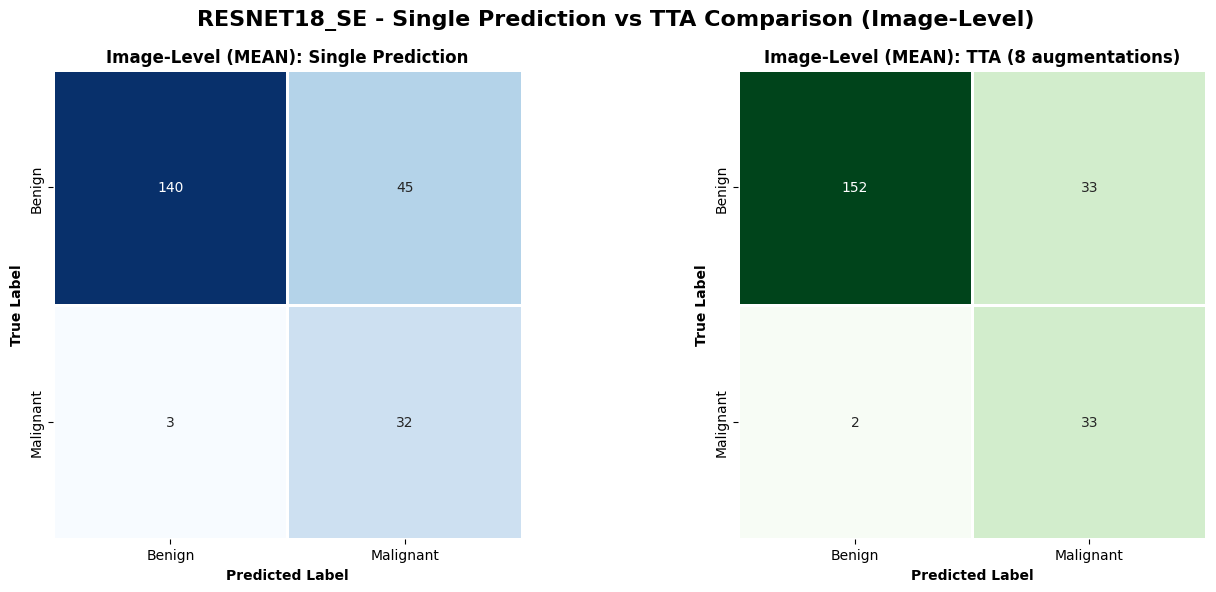


────────────────────────────────────────────────────────────────────────────────
IMAGE-LEVEL CONFUSION MATRIX COMPARISON
────────────────────────────────────────────────────────────────────────────────

SINGLE PREDICTION:
                Predicted
              Benign  Malignant
    Benign       140      45
    Malignant      3      32

  False Negatives (Missed): 3 (8.6% miss rate)
  False Positives (Alarms): 45 (24.3% false alarm rate)

TTA PREDICTION (8 augmentations):
                Predicted
              Benign  Malignant
    Benign       152      33
    Malignant      2      33

  False Negatives (Missed): 2 (5.7% miss rate)
  False Positives (Alarms): 33 (17.8% false alarm rate)

────────────────────────────────────────────────────────────────────────────────
TTA IMPROVEMENTS:
────────────────────────────────────────────────────────────────────────────────
  Reduced missed malignant: 3 → 2 (Δ = +1)
  Detected more malignant:  32 → 33 (Δ = +1)
  False positives:          45 → 

TTA Evaluation on Test: 100%|██████████| 6/6 [00:12<00:00,  2.03s/it]



────────────────────────────────────────────────────────────────────────────────
IMAGE-LEVEL COMPARISON: SINGLE vs TTA (MEAN Aggregation)
────────────────────────────────────────────────────────────────────────────────

Metric               Single          TTA             Improvement    
-----------------------------------------------------------------
Accuracy              86.82%         87.73%          0.91%
AUC-ROC              0.9042        0.9171        0.0128
AUC-PR               0.7303        0.7747        0.0443
Mal Precision        0.5600        0.5870        0.0270
Mal Recall           0.8000        0.7714       -0.0286
Mal F1-Score         0.6588        0.6667        0.0078

CONFUSION MATRICES: SINGLE vs TTA (IMAGE-LEVEL)

✅ TTA comparison saved: /kaggle/working/results_stage3_classification_SE/mobilenet_v2_se/tta_comparison_confusion_matrices.png


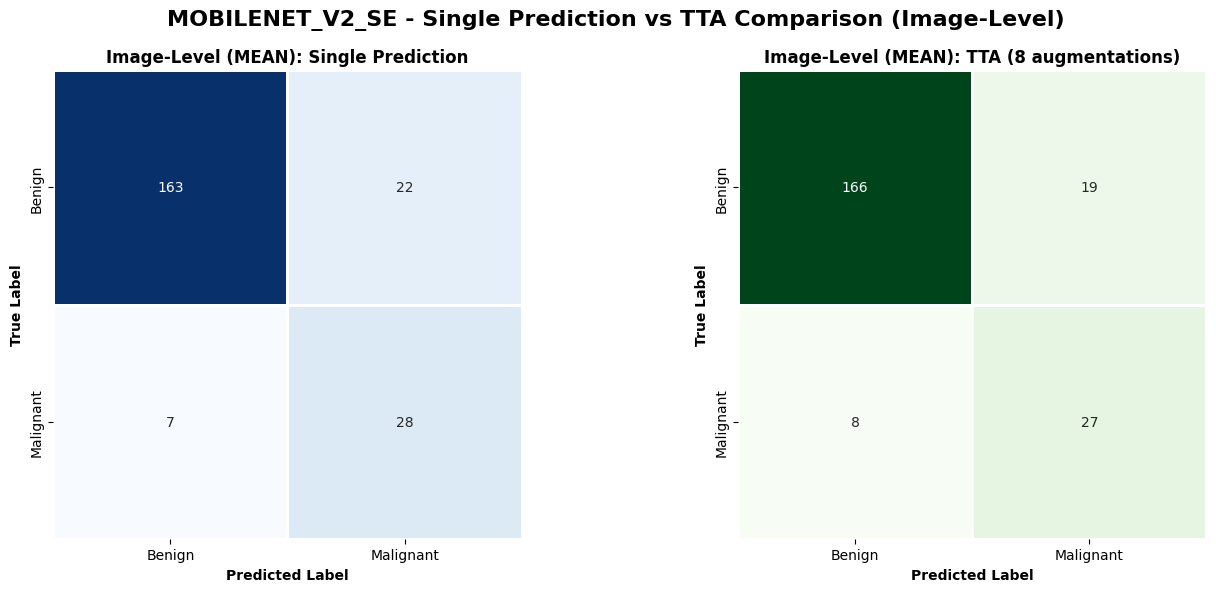


────────────────────────────────────────────────────────────────────────────────
IMAGE-LEVEL CONFUSION MATRIX COMPARISON
────────────────────────────────────────────────────────────────────────────────

SINGLE PREDICTION:
                Predicted
              Benign  Malignant
    Benign       163      22
    Malignant      7      28

  False Negatives (Missed): 7 (20.0% miss rate)
  False Positives (Alarms): 22 (11.9% false alarm rate)

TTA PREDICTION (8 augmentations):
                Predicted
              Benign  Malignant
    Benign       166      19
    Malignant      8      27

  False Negatives (Missed): 8 (22.9% miss rate)
  False Positives (Alarms): 19 (10.3% false alarm rate)

────────────────────────────────────────────────────────────────────────────────
TTA IMPROVEMENTS:
────────────────────────────────────────────────────────────────────────────────
  Reduced missed malignant: 7 → 8 (Δ = -1)
  Detected more malignant:  28 → 27 (Δ = -1)
  False positives:          22 

TTA Evaluation on Test: 100%|██████████| 6/6 [00:18<00:00,  3.03s/it]



────────────────────────────────────────────────────────────────────────────────
IMAGE-LEVEL COMPARISON: SINGLE vs TTA (MEAN Aggregation)
────────────────────────────────────────────────────────────────────────────────

Metric               Single          TTA             Improvement    
-----------------------------------------------------------------
Accuracy              89.09%         88.18%         -0.91%
AUC-ROC              0.9341        0.9347        0.0006
AUC-PR               0.7283        0.6813       -0.0470
Mal Precision        0.6078        0.5818       -0.0260
Mal Recall           0.8857        0.9143        0.0286
Mal F1-Score         0.7209        0.7111       -0.0098

CONFUSION MATRICES: SINGLE vs TTA (IMAGE-LEVEL)

✅ TTA comparison saved: /kaggle/working/results_stage3_classification_SE/efficientnet_b0_se/tta_comparison_confusion_matrices.png


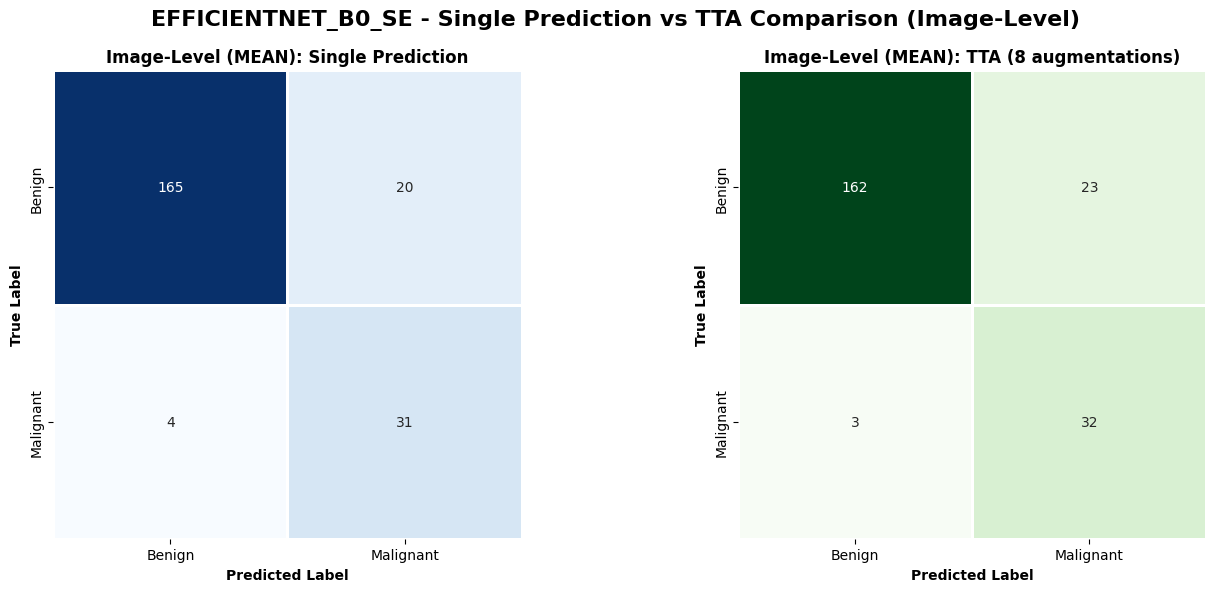


────────────────────────────────────────────────────────────────────────────────
IMAGE-LEVEL CONFUSION MATRIX COMPARISON
────────────────────────────────────────────────────────────────────────────────

SINGLE PREDICTION:
                Predicted
              Benign  Malignant
    Benign       165      20
    Malignant      4      31

  False Negatives (Missed): 4 (11.4% miss rate)
  False Positives (Alarms): 20 (10.8% false alarm rate)

TTA PREDICTION (8 augmentations):
                Predicted
              Benign  Malignant
    Benign       162      23
    Malignant      3      32

  False Negatives (Missed): 3 (8.6% miss rate)
  False Positives (Alarms): 23 (12.4% false alarm rate)

────────────────────────────────────────────────────────────────────────────────
TTA IMPROVEMENTS:
────────────────────────────────────────────────────────────────────────────────
  Reduced missed malignant: 4 → 3 (Δ = +1)
  Detected more malignant:  31 → 32 (Δ = +1)
  False positives:          20 →

TTA Evaluation on Test: 100%|██████████| 6/6 [00:31<00:00,  5.31s/it]



────────────────────────────────────────────────────────────────────────────────
IMAGE-LEVEL COMPARISON: SINGLE vs TTA (MEAN Aggregation)
────────────────────────────────────────────────────────────────────────────────

Metric               Single          TTA             Improvement    
-----------------------------------------------------------------
Accuracy              88.64%         90.45%          1.82%
AUC-ROC              0.9265        0.9317        0.0053
AUC-PR               0.7541        0.7602        0.0061
Mal Precision        0.6000        0.6667        0.0667
Mal Recall           0.8571        0.8000       -0.0571
Mal F1-Score         0.7059        0.7273        0.0214

CONFUSION MATRICES: SINGLE vs TTA (IMAGE-LEVEL)

✅ TTA comparison saved: /kaggle/working/results_stage3_classification_SE/densenet121_se/tta_comparison_confusion_matrices.png


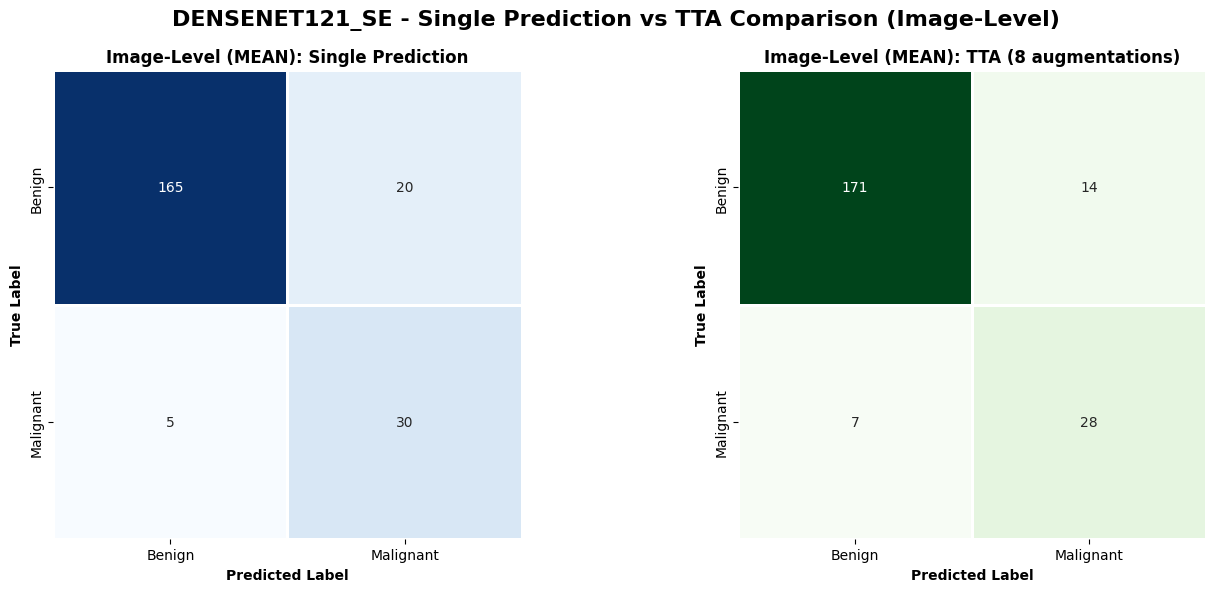


────────────────────────────────────────────────────────────────────────────────
IMAGE-LEVEL CONFUSION MATRIX COMPARISON
────────────────────────────────────────────────────────────────────────────────

SINGLE PREDICTION:
                Predicted
              Benign  Malignant
    Benign       165      20
    Malignant      5      30

  False Negatives (Missed): 5 (14.3% miss rate)
  False Positives (Alarms): 20 (10.8% false alarm rate)

TTA PREDICTION (8 augmentations):
                Predicted
              Benign  Malignant
    Benign       171      14
    Malignant      7      28

  False Negatives (Missed): 7 (20.0% miss rate)
  False Positives (Alarms): 14 (7.6% false alarm rate)

────────────────────────────────────────────────────────────────────────────────
TTA IMPROVEMENTS:
────────────────────────────────────────────────────────────────────────────────
  Reduced missed malignant: 5 → 7 (Δ = -2)
  Detected more malignant:  30 → 28 (Δ = -2)
  False positives:          20 →

TTA Evaluation on Test: 100%|██████████| 6/6 [00:14<00:00,  2.47s/it]



────────────────────────────────────────────────────────────────────────────────
IMAGE-LEVEL COMPARISON: SINGLE vs TTA (MEAN Aggregation)
────────────────────────────────────────────────────────────────────────────────

Metric               Single          TTA             Improvement    
-----------------------------------------------------------------
Accuracy              75.45%         79.09%          3.64%
AUC-ROC              0.8780        0.8976        0.0196
AUC-PR               0.5124        0.5507        0.0384
Mal Precision        0.3827        0.4225        0.0398
Mal Recall           0.8857        0.8571       -0.0286
Mal F1-Score         0.5345        0.5660        0.0316

CONFUSION MATRICES: SINGLE vs TTA (IMAGE-LEVEL)

✅ TTA comparison saved: /kaggle/working/results_stage3_classification_SE/shufflenet_v2_se/tta_comparison_confusion_matrices.png


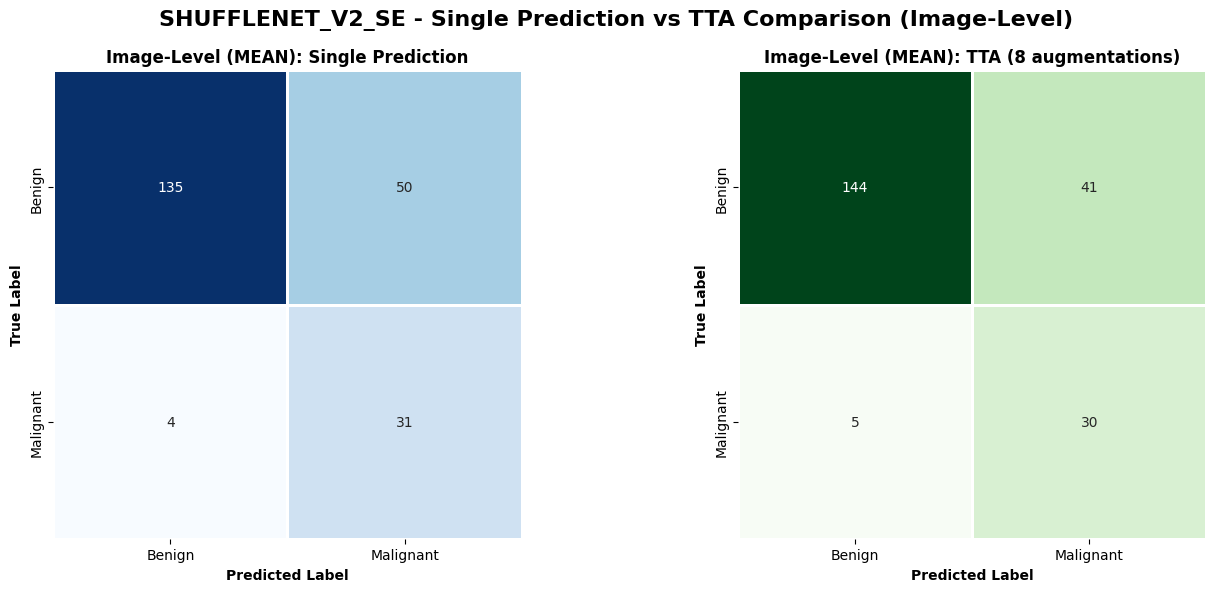


────────────────────────────────────────────────────────────────────────────────
IMAGE-LEVEL CONFUSION MATRIX COMPARISON
────────────────────────────────────────────────────────────────────────────────

SINGLE PREDICTION:
                Predicted
              Benign  Malignant
    Benign       135      50
    Malignant      4      31

  False Negatives (Missed): 4 (11.4% miss rate)
  False Positives (Alarms): 50 (27.0% false alarm rate)

TTA PREDICTION (8 augmentations):
                Predicted
              Benign  Malignant
    Benign       144      41
    Malignant      5      30

  False Negatives (Missed): 5 (14.3% miss rate)
  False Positives (Alarms): 41 (22.2% false alarm rate)

────────────────────────────────────────────────────────────────────────────────
TTA IMPROVEMENTS:
────────────────────────────────────────────────────────────────────────────────
  Reduced missed malignant: 4 → 5 (Δ = -1)
  Detected more malignant:  31 → 30 (Δ = -1)
  False positives:          50 

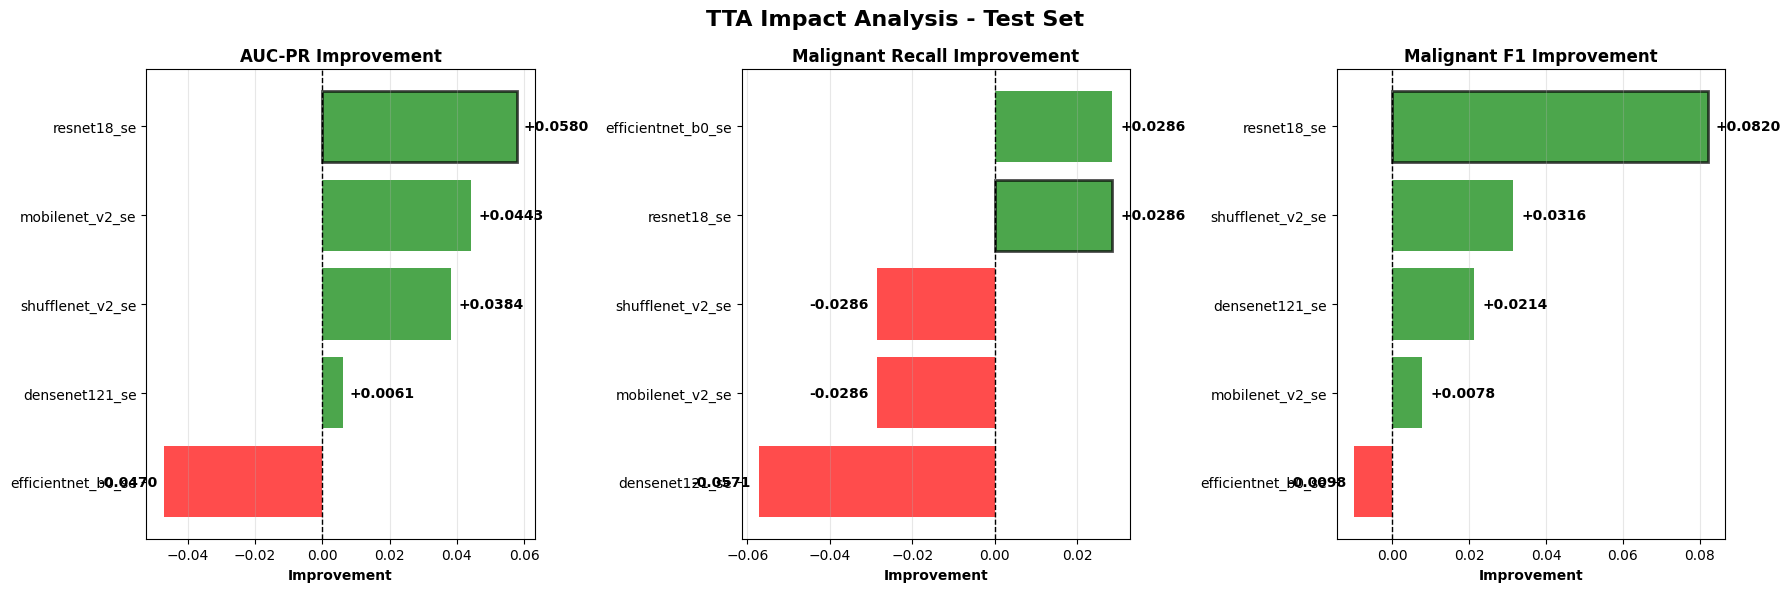

✅ Saved TTA improvements: /kaggle/working/results_stage3_classification_SE/all_models_tta_improvements_test.csv

🏆 BEST MODELS WITH TTA (IMAGE-LEVEL)

🥇 Best AUC_PR              : mobilenet_v2_se           (0.7747)
🥇 Best AUC_ROC             : efficientnet_b0_se        (0.9347)
🥇 Best Mal_Recall          : resnet18_se               (0.9429)
🥇 Best Mal_F1              : densenet121_se            (0.7273)

✅ BATCH TTA EVALUATION COMPLETE!

📁 All results saved in: /kaggle/working/results_stage3_classification_SE

📊 Evaluated 5 models with TTA on Test set

🏆 Best model with TTA (AUC-PR): mobilenet_v2_se
   AUC-PR: 0.7747

💡 Average TTA improvement: +0.0199 AUC-PR


✅ TTA batch evaluation code loaded! Run the cell to evaluate all models with TTA.


In [8]:
# ============================================================================
# TEST-TIME AUGMENTATION (TTA) IMPLEMENTATION - IMAGE-LEVEL ONLY
# ============================================================================

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ============================================================================
# TTA CONFIGURATION
# ============================================================================

class TTAConfig:
    """Configuration for Test-Time Augmentation"""
    
    # TTA settings
    ENABLED = True
    N_AUGMENTS = 8
    
    # Geometric augmentations (match training)
    USE_HORIZONTAL_FLIP = True
    USE_VERTICAL_FLIP = True
    USE_ROTATIONS = True
    ROTATION_ANGLES = [-10, 10]  # Degrees (subset of training's ±20°)
    
    # Aggregation method
    AGGREGATION = 'mean'  # Options: 'mean', 'geometric_mean', 'max'
    
    # Verbose output
    VERBOSE = True

tta_cfg = TTAConfig()

print("="*80)
print("TTA CONFIGURATION")
print("="*80)
print(f"✅ TTA Enabled: {tta_cfg.ENABLED}")
print(f"✅ Number of augmentations: {tta_cfg.N_AUGMENTS}")
print(f"✅ Horizontal flip: {tta_cfg.USE_HORIZONTAL_FLIP}")
print(f"✅ Vertical flip: {tta_cfg.USE_VERTICAL_FLIP}")
print(f"✅ Rotations: {tta_cfg.ROTATION_ANGLES}°")
print(f"✅ Aggregation: {tta_cfg.AGGREGATION}")
print("="*80)


# ============================================================================
# TTA AUGMENTATION CLASS
# ============================================================================

class TTATransform:
    """Individual TTA transformation"""
    
    def __init__(self, name, transform_fn, inverse_fn=None):
        self.name = name
        self.transform_fn = transform_fn
        self.inverse_fn = inverse_fn
    
    def __call__(self, image):
        """Apply transformation to image"""
        return self.transform_fn(image)
    
    def inverse(self, image):
        """Apply inverse transformation (if needed)"""
        if self.inverse_fn:
            return self.inverse_fn(image)
        return image


class TTAWrapper:
    """
    Test-Time Augmentation wrapper for PyTorch models
    
    Applies multiple augmentations at test time and averages predictions
    for improved robustness and accuracy.
    """
    
    def __init__(self, model, config=None):
        self.model = model
        self.config = config or TTAConfig()
        self.transforms = self._build_transforms()
        
        if self.config.VERBOSE:
            print(f"\n✅ TTA Wrapper initialized with {len(self.transforms)} augmentations:")
            for i, t in enumerate(self.transforms):
                print(f"   {i+1}. {t.name}")
    
    def _build_transforms(self):
        """Build list of TTA transformations"""
        transforms = []
        
        # 1. Original (no augmentation)
        transforms.append(TTATransform(
            name="Original",
            transform_fn=lambda x: x
        ))
        
        # 2. Horizontal flip
        if self.config.USE_HORIZONTAL_FLIP:
            transforms.append(TTATransform(
                name="Horizontal Flip",
                transform_fn=lambda x: TF.hflip(x)
            ))
        
        # 3. Vertical flip
        if self.config.USE_VERTICAL_FLIP:
            transforms.append(TTATransform(
                name="Vertical Flip",
                transform_fn=lambda x: TF.vflip(x)
            ))
        
        # 4-5. Rotations
        if self.config.USE_ROTATIONS:
            for angle in self.config.ROTATION_ANGLES:
                transforms.append(TTATransform(
                    name=f"Rotate {angle:+d}°",
                    transform_fn=lambda x, a=angle: TF.rotate(x, a)
                ))
        
        # 6-7. Horizontal flip + Rotations
        if self.config.USE_HORIZONTAL_FLIP and self.config.USE_ROTATIONS:
            for angle in self.config.ROTATION_ANGLES:
                transforms.append(TTATransform(
                    name=f"H-Flip + Rotate {angle:+d}°",
                    transform_fn=lambda x, a=angle: TF.rotate(TF.hflip(x), a)
                ))
        
        # 8. Vertical flip + Rotation (if we need exactly 8)
        if len(transforms) < self.config.N_AUGMENTS and self.config.USE_VERTICAL_FLIP:
            transforms.append(TTATransform(
                name=f"V-Flip + Rotate {self.config.ROTATION_ANGLES[0]:+d}°",
                transform_fn=lambda x: TF.rotate(TF.vflip(x), self.config.ROTATION_ANGLES[0])
            ))
        
        return transforms[:self.config.N_AUGMENTS]
    
    def predict_single(self, image, device):
        """
        Predict with TTA for a single image
        
        Args:
            image: Tensor of shape (C, H, W) or (1, C, H, W)
            device: torch device
        
        Returns:
            averaged_probs: Averaged probabilities across all augmentations
            all_probs: List of probabilities for each augmentation (for analysis)
        """
        # Ensure batch dimension
        if image.dim() == 3:
            image = image.unsqueeze(0)
        
        image = image.to(device)
        all_probs = []
        
        self.model.eval()
        with torch.no_grad():
            for transform in self.transforms:
                # Apply augmentation
                aug_image = transform(image)
                
                # Forward pass
                output = self.model(aug_image)
                probs = F.softmax(output, dim=1)
                
                all_probs.append(probs.cpu().numpy())
        
        # Stack all predictions
        all_probs = np.concatenate(all_probs, axis=0)  # Shape: (n_augments, num_classes)
        
        # Aggregate predictions
        if self.config.AGGREGATION == 'mean':
            averaged_probs = all_probs.mean(axis=0, keepdims=True)
        elif self.config.AGGREGATION == 'geometric_mean':
            averaged_probs = np.exp(np.log(all_probs + 1e-8).mean(axis=0, keepdims=True))
        elif self.config.AGGREGATION == 'max':
            averaged_probs = all_probs.max(axis=0, keepdims=True)
        else:
            raise ValueError(f"Unknown aggregation method: {self.config.AGGREGATION}")
        
        return averaged_probs, all_probs
    
    def predict_batch(self, images, device):
        """
        Predict with TTA for a batch of images
        
        Args:
            images: Tensor of shape (B, C, H, W)
            device: torch device
        
        Returns:
            averaged_probs: Averaged probabilities for all images
        """
        batch_probs = []
        
        for i in range(images.size(0)):
            avg_prob, _ = self.predict_single(images[i], device)
            batch_probs.append(avg_prob)
        
        return np.concatenate(batch_probs, axis=0)


# ============================================================================
# TTA EVALUATION FUNCTION
# ============================================================================

def evaluate_with_tta(model, dataloader, device, tta_config=None, dataset_name="Validation"):
    """
    Evaluate model with Test-Time Augmentation
    
    Returns:
        img_metrics_single: Image metrics without TTA (MEAN aggregation)
        img_metrics_tta: Image metrics with TTA (MEAN aggregation)
        all_data: Dictionary with all predictions
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING WITH TTA ON {dataset_name.upper()} SET")
    print(f"{'='*80}")
    
    # Initialize TTA wrapper
    tta_wrapper = TTAWrapper(model, config=tta_config)
    
    model.eval()
    
    # Storage for predictions
    all_labels = []
    all_probs_single = []
    all_probs_tta = []
    all_image_ids = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f"TTA Evaluation on {dataset_name}")
        
        for images, labels, image_ids in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            # ================================================================
            # SINGLE PREDICTION (No TTA)
            # ================================================================
            outputs_single = model(images)
            probs_single = F.softmax(outputs_single, dim=1)
            
            # ================================================================
            # TTA PREDICTION (Multiple augmentations averaged)
            # ================================================================
            probs_tta = tta_wrapper.predict_batch(images, device)
            
            # Store results
            all_labels.extend(labels.cpu().numpy())
            all_probs_single.extend(probs_single.cpu().numpy())
            all_probs_tta.extend(probs_tta)
            all_image_ids.extend(image_ids)
    
    all_labels = np.array(all_labels)
    all_probs_single = np.array(all_probs_single)
    all_probs_tta = np.array(all_probs_tta)
    
    # ========================================================================
    # IMAGE-LEVEL METRICS (MEAN AGGREGATION)
    # ========================================================================
    
    # Single prediction
    img_labels_single, img_probs_single = aggregate_rois_to_images(
        all_labels, all_probs_single, all_image_ids, method='mean'
    )
    img_preds_single = img_probs_single.argmax(axis=1)
    img_metrics_single = compute_comprehensive_metrics(
        img_labels_single, img_preds_single, img_probs_single
    )
    
    # TTA prediction
    img_labels_tta, img_probs_tta = aggregate_rois_to_images(
        all_labels, all_probs_tta, all_image_ids, method='mean'
    )
    img_preds_tta = img_probs_tta.argmax(axis=1)
    img_metrics_tta = compute_comprehensive_metrics(
        img_labels_tta, img_preds_tta, img_probs_tta
    )
    
    print(f"\n{'─'*80}")
    print("IMAGE-LEVEL COMPARISON: SINGLE vs TTA (MEAN Aggregation)")
    print(f"{'─'*80}")
    print(f"\n{'Metric':<20} {'Single':<15} {'TTA':<15} {'Improvement':<15}")
    print(f"{'-'*65}")
    print(f"{'Accuracy':<20} {img_metrics_single['accuracy']*100:>6.2f}% "
          f"{img_metrics_tta['accuracy']*100:>13.2f}% "
          f"{(img_metrics_tta['accuracy']-img_metrics_single['accuracy'])*100:>13.2f}%")
    print(f"{'AUC-ROC':<20} {img_metrics_single['auc_roc']:>6.4f} "
          f"{img_metrics_tta['auc_roc']:>13.4f} "
          f"{img_metrics_tta['auc_roc']-img_metrics_single['auc_roc']:>13.4f}")
    print(f"{'AUC-PR':<20} {img_metrics_single['auc_pr']:>6.4f} "
          f"{img_metrics_tta['auc_pr']:>13.4f} "
          f"{img_metrics_tta['auc_pr']-img_metrics_single['auc_pr']:>13.4f}")
    print(f"{'Mal Precision':<20} {img_metrics_single['malignant_precision']:>6.4f} "
          f"{img_metrics_tta['malignant_precision']:>13.4f} "
          f"{img_metrics_tta['malignant_precision']-img_metrics_single['malignant_precision']:>13.4f}")
    print(f"{'Mal Recall':<20} {img_metrics_single['malignant_recall']:>6.4f} "
          f"{img_metrics_tta['malignant_recall']:>13.4f} "
          f"{img_metrics_tta['malignant_recall']-img_metrics_single['malignant_recall']:>13.4f}")
    print(f"{'Mal F1-Score':<20} {img_metrics_single['malignant_f1']:>6.4f} "
          f"{img_metrics_tta['malignant_f1']:>13.4f} "
          f"{img_metrics_tta['malignant_f1']-img_metrics_single['malignant_f1']:>13.4f}")
    
    # ========================================================================
    # RETURN ALL DATA
    # ========================================================================
    all_data = {
        'image_single': {
            'labels': img_labels_single,
            'probs': img_probs_single,
            'preds': img_preds_single
        },
        'image_tta': {
            'labels': img_labels_tta,
            'probs': img_probs_tta,
            'preds': img_preds_tta
        }
    }
    
    return img_metrics_single, img_metrics_tta, all_data


# ============================================================================
# VISUALIZATION: CONFUSION MATRICES COMPARISON
# ============================================================================

def plot_tta_comparison(all_data, model_name, save_dir=None):
    """
    Plot side-by-side confusion matrices: Single vs TTA (Image-level only)
    """
    print(f"\n{'='*80}")
    print("CONFUSION MATRICES: SINGLE vs TTA (IMAGE-LEVEL)")
    print(f"{'='*80}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'{model_name.upper()} - Single Prediction vs TTA Comparison (Image-Level)', 
                 fontsize=16, fontweight='bold')
    
    class_names = ['Benign', 'Malignant']
    
    # ========================================================================
    # IMAGE-LEVEL COMPARISON
    # ========================================================================
    
    # Single
    cm_img_single = confusion_matrix(
        all_data['image_single']['labels'],
        all_data['image_single']['preds']
    )
    
    sns.heatmap(cm_img_single, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, ax=axes[0], square=True, linewidths=2)
    axes[0].set_title('Image-Level (MEAN): Single Prediction', fontweight='bold', fontsize=12)
    axes[0].set_ylabel('True Label', fontweight='bold')
    axes[0].set_xlabel('Predicted Label', fontweight='bold')
    
    # TTA
    cm_img_tta = confusion_matrix(
        all_data['image_tta']['labels'],
        all_data['image_tta']['preds']
    )
    
    sns.heatmap(cm_img_tta, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, ax=axes[1], square=True, linewidths=2)
    axes[1].set_title('Image-Level (MEAN): TTA (8 augmentations)', fontweight='bold', fontsize=12)
    axes[1].set_ylabel('True Label', fontweight='bold')
    axes[1].set_xlabel('Predicted Label', fontweight='bold')
    
    plt.tight_layout()
    
    if save_dir:
        save_path = f"{save_dir}/tta_comparison_confusion_matrices.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✅ TTA comparison saved: {save_path}")
    
    plt.show()
    
    # ========================================================================
    # PRINT NUMERICAL COMPARISON
    # ========================================================================
    
    print(f"\n{'─'*80}")
    print("IMAGE-LEVEL CONFUSION MATRIX COMPARISON")
    print(f"{'─'*80}")
    
    print(f"\nSINGLE PREDICTION:")
    print(f"                Predicted")
    print(f"              Benign  Malignant")
    print(f"    Benign    {cm_img_single[0,0]:>6}  {cm_img_single[0,1]:>6}")
    print(f"    Malignant {cm_img_single[1,0]:>6}  {cm_img_single[1,1]:>6}")
    
    tn_s, fp_s, fn_s, tp_s = cm_img_single.ravel()
    print(f"\n  False Negatives (Missed): {fn_s} ({fn_s/(fn_s+tp_s)*100:.1f}% miss rate)")
    print(f"  False Positives (Alarms): {fp_s} ({fp_s/(tn_s+fp_s)*100:.1f}% false alarm rate)")
    
    print(f"\nTTA PREDICTION (8 augmentations):")
    print(f"                Predicted")
    print(f"              Benign  Malignant")
    print(f"    Benign    {cm_img_tta[0,0]:>6}  {cm_img_tta[0,1]:>6}")
    print(f"    Malignant {cm_img_tta[1,0]:>6}  {cm_img_tta[1,1]:>6}")
    
    tn_t, fp_t, fn_t, tp_t = cm_img_tta.ravel()
    print(f"\n  False Negatives (Missed): {fn_t} ({fn_t/(fn_t+tp_t)*100:.1f}% miss rate)")
    print(f"  False Positives (Alarms): {fp_t} ({fp_t/(tn_t+fp_t)*100:.1f}% false alarm rate)")
    
    print(f"\n{'─'*80}")
    print("TTA IMPROVEMENTS:")
    print(f"{'─'*80}")
    print(f"  Reduced missed malignant: {fn_s} → {fn_t} (Δ = {fn_s-fn_t:+d})")
    print(f"  Detected more malignant:  {tp_s} → {tp_t} (Δ = {tp_t-tp_s:+d})")
    print(f"  False positives:          {fp_s} → {fp_t} (Δ = {fp_t-fp_s:+d})")
    
    return cm_img_single, cm_img_tta


# ============================================================================
# MAIN TTA EVALUATION SCRIPT - ALL MODELS
# ============================================================================

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n✅ Device: {device}")
    
    # ========================================================================
    # CONFIGURATION
    # ========================================================================
    
    # ✅ ALL MODELS TO EVALUATE
    ALL_MODELS = [
        'resnet18_se',
        'mobilenet_v2_se',
        'efficientnet_b0_se',
        'densenet121_se',
    ]
    
    # Choose dataset
    evaluate_on = 'test'  # 'val' or 'test'
    
    print(f"\n{'='*80}")
    print(f"TTA BATCH EVALUATION CONFIGURATION")
    print(f"{'='*80}")
    print(f"Number of models: {len(ALL_MODELS)}")
    print(f"Models:           {', '.join(ALL_MODELS)}")
    print(f"Evaluate on:      {evaluate_on.upper()} set")
    print(f"TTA Config:       {tta_cfg.N_AUGMENTS} augmentations")
    print(f"{'='*80}\n")
    
    # ========================================================================
    # LOAD DATA (ONCE FOR ALL MODELS)
    # ========================================================================
    
    if evaluate_on == 'val':
        eval_df = val_df
        dataset_name = "Validation"
    else:
        eval_df = test_df
        dataset_name = "Test"
    
    eval_dataset = BTXRDROIDataset(eval_df, evaluate_on, transform=get_val_transform())
    
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(cfg.RANDOM_SEED)
    
    eval_loader = DataLoader(
        eval_dataset,
        batch_size=cfg.BATCH_SIZE,
        shuffle=False,
        num_workers=cfg.NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    print(f"✅ Loaded {len(eval_dataset)} ROIs from {dataset_name} set")
    print(f"✅ Total unique images: {eval_df['source_image'].nunique()}\n")
    
    # ========================================================================
    # STORAGE FOR ALL RESULTS
    # ========================================================================
    
    all_results = []
    
    # ========================================================================
    # EVALUATE EACH MODEL WITH TTA
    # ========================================================================
    
    for i, model_name in enumerate(ALL_MODELS, 1):
        print(f"\n{'█'*80}")
        print(f"█ MODEL {i}/{len(ALL_MODELS)}: {model_name.upper()}")
        print(f"{'█'*80}\n")
        
        checkpoint_path = f"{cfg.RESULTS_DIR}/{model_name}/best_auc_pr.pth"
        
        # Check if checkpoint exists
        if not os.path.exists(checkpoint_path):
            print(f"⚠️  WARNING: Checkpoint not found: {checkpoint_path}")
            print(f"⚠️  Skipping {model_name}\n")
            continue
        
        try:
            # ================================================================
            # LOAD MODEL
            # ================================================================
            print(f"📂 Loading checkpoint: {checkpoint_path}")
            
            model = get_model(model_name, num_classes=cfg.NUM_CLASSES).to(device)
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
            model.load_state_dict(checkpoint['model_state_dict'])
            model.eval()
            
            print(f"✅ Loaded from epoch {checkpoint['epoch']}")
            print(f"✅ Training best AUC-PR: {checkpoint['best_auc_pr']:.4f}\n")
            
            # ================================================================
            # EVALUATE WITH TTA
            # ================================================================
            print(f"🔄 Evaluating with TTA on {dataset_name} set...")
            
            img_metrics_single, img_metrics_tta, all_data = \
                evaluate_with_tta(model, eval_loader, device, tta_cfg, dataset_name)
            
            # ================================================================
            # VISUALIZE COMPARISON
            # ================================================================
            save_dir = f"{cfg.RESULTS_DIR}/{model_name}"
            os.makedirs(save_dir, exist_ok=True)
            
            cm_img_single, cm_img_tta = plot_tta_comparison(
                all_data, model_name, save_dir=save_dir
            )
            
            # ================================================================
            # STORE RESULTS
            # ================================================================
            
            # Single prediction results
            all_results.append({
                'Model': model_name,
                'Method': 'Single',
                'Epoch': checkpoint['epoch'],
                'Accuracy': img_metrics_single['accuracy'],
                'Balanced_Acc': img_metrics_single['balanced_accuracy'],
                'F1_Macro': img_metrics_single['f1_macro'],
                'AUC_ROC': img_metrics_single['auc_roc'],
                'AUC_PR': img_metrics_single['auc_pr'],
                'Mal_Precision': img_metrics_single['malignant_precision'],
                'Mal_Recall': img_metrics_single['malignant_recall'],
                'Mal_F1': img_metrics_single['malignant_f1'],
                'Ben_Precision': img_metrics_single['benign_precision'],
                'Ben_Recall': img_metrics_single['benign_recall'],
                'Ben_F1': img_metrics_single['benign_f1'],
            })
            
            # TTA results
            all_results.append({
                'Model': model_name,
                'Method': 'TTA',
                'Epoch': checkpoint['epoch'],
                'Accuracy': img_metrics_tta['accuracy'],
                'Balanced_Acc': img_metrics_tta['balanced_accuracy'],
                'F1_Macro': img_metrics_tta['f1_macro'],
                'AUC_ROC': img_metrics_tta['auc_roc'],
                'AUC_PR': img_metrics_tta['auc_pr'],
                'Mal_Precision': img_metrics_tta['malignant_precision'],
                'Mal_Recall': img_metrics_tta['malignant_recall'],
                'Mal_F1': img_metrics_tta['malignant_f1'],
                'Ben_Precision': img_metrics_tta['benign_precision'],
                'Ben_Recall': img_metrics_tta['benign_recall'],
                'Ben_F1': img_metrics_tta['benign_f1'],
            })
            
            # Save individual model comparison
            comparison_results = {
                'Model': [model_name, model_name],
                'Method': ['Single', 'TTA'],
                'Dataset': [dataset_name, dataset_name],
                'IMG_Accuracy': [img_metrics_single['accuracy'], img_metrics_tta['accuracy']],
                'IMG_F1_Macro': [img_metrics_single['f1_macro'], img_metrics_tta['f1_macro']],
                'IMG_AUC_ROC': [img_metrics_single['auc_roc'], img_metrics_tta['auc_roc']],
                'IMG_AUC_PR': [img_metrics_single['auc_pr'], img_metrics_tta['auc_pr']],
                'IMG_Mal_Precision': [img_metrics_single['malignant_precision'], 
                                      img_metrics_tta['malignant_precision']],
                'IMG_Mal_Recall': [img_metrics_single['malignant_recall'], 
                                   img_metrics_tta['malignant_recall']],
                'IMG_Mal_F1': [img_metrics_single['malignant_f1'], img_metrics_tta['malignant_f1']],
            }
            
            comparison_df = pd.DataFrame(comparison_results)
            csv_path = f"{save_dir}/tta_comparison_{dataset_name.lower()}.csv"
            comparison_df.to_csv(csv_path, index=False)
            print(f"\n✅ Individual results saved: {csv_path}")
            
            print(f"\n✅ {model_name} TTA evaluation complete!\n")
            
            # Clear CUDA cache
            del model
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"\n❌ ERROR evaluating {model_name}: {str(e)}\n")
            import traceback
            traceback.print_exc()
            continue
    
    # ========================================================================
    # CREATE COMBINED COMPARISON TABLE
    # ========================================================================
    
    print(f"\n{'='*80}")
    print(f"CREATING COMBINED COMPARISON TABLE")
    print(f"{'='*80}\n")
    
    df_all_results = pd.DataFrame(all_results)
    
    # Save combined results
    results_dir = cfg.RESULTS_DIR
    csv_combined = f"{results_dir}/all_models_tta_comparison_{evaluate_on}.csv"
    df_all_results.to_csv(csv_combined, index=False)
    print(f"✅ Saved combined results: {csv_combined}\n")
    
    # ========================================================================
    # PRINT COMPARISON TABLE
    # ========================================================================
    
    print(f"\n{'='*80}")
    print(f"ALL MODELS TTA COMPARISON ({dataset_name.upper()} SET)")
    print(f"{'='*80}\n")
    print(df_all_results[['Model', 'Method', 'Accuracy', 'F1_Macro', 'AUC_ROC', 
                          'AUC_PR', 'Mal_Precision', 'Mal_Recall', 'Mal_F1']].to_string(index=False))
    
    # ========================================================================
    # CALCULATE TTA IMPROVEMENTS
    # ========================================================================
    
    print(f"\n{'='*80}")
    print(f"📊 TTA IMPROVEMENT ANALYSIS")
    print(f"{'='*80}\n")
    
    tta_improvements = []
    
    for model_name in ALL_MODELS:
        model_results = df_all_results[df_all_results['Model'] == model_name]
        
        if len(model_results) == 2:
            single_results = model_results[model_results['Method'] == 'Single'].iloc[0]
            tta_results = model_results[model_results['Method'] == 'TTA'].iloc[0]
            
            tta_improvements.append({
                'Model': model_name,
                'AUC_PR_Single': single_results['AUC_PR'],
                'AUC_PR_TTA': tta_results['AUC_PR'],
                'AUC_PR_Improvement': tta_results['AUC_PR'] - single_results['AUC_PR'],
                'Mal_Recall_Single': single_results['Mal_Recall'],
                'Mal_Recall_TTA': tta_results['Mal_Recall'],
                'Mal_Recall_Improvement': tta_results['Mal_Recall'] - single_results['Mal_Recall'],
                'Mal_F1_Single': single_results['Mal_F1'],
                'Mal_F1_TTA': tta_results['Mal_F1'],
                'Mal_F1_Improvement': tta_results['Mal_F1'] - single_results['Mal_F1'],
            })
    
    df_improvements = pd.DataFrame(tta_improvements)
    
    print("TTA Impact by Model:")
    print(df_improvements[['Model', 'AUC_PR_Improvement', 'Mal_Recall_Improvement', 
                           'Mal_F1_Improvement']].to_string(index=False))
    
    print(f"\n📊 Average TTA Impact Across All Models:")
    print(f"   AUC-PR Improvement:      {df_improvements['AUC_PR_Improvement'].mean():+.4f} "
          f"({df_improvements['AUC_PR_Improvement'].mean()*100:+.2f}%)")
    print(f"   Mal Recall Improvement:  {df_improvements['Mal_Recall_Improvement'].mean():+.4f} "
          f"({df_improvements['Mal_Recall_Improvement'].mean()*100:+.2f}%)")
    print(f"   Mal F1 Improvement:      {df_improvements['Mal_F1_Improvement'].mean():+.4f} "
          f"({df_improvements['Mal_F1_Improvement'].mean()*100:+.2f}%)")
    
    # ========================================================================
    # VISUALIZATION: TTA IMPROVEMENTS
    # ========================================================================
    
    print(f"\n{'='*80}")
    print(f"📊 CREATING TTA IMPROVEMENT VISUALIZATION")
    print(f"{'='*80}\n")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'TTA Impact Analysis - {dataset_name} Set', 
                 fontsize=16, fontweight='bold')
    
    metrics_to_plot = [
        ('AUC_PR_Improvement', 'AUC-PR Improvement'),
        ('Mal_Recall_Improvement', 'Malignant Recall Improvement'),
        ('Mal_F1_Improvement', 'Malignant F1 Improvement')
    ]
    
    colors = ['green' if x > 0 else 'red' for x in df_improvements['AUC_PR_Improvement']]
    
    for idx, (metric, title) in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        # Sort by improvement
        df_sorted = df_improvements.sort_values(metric, ascending=True)
        
        # Create horizontal bar plot
        colors_sorted = ['green' if x > 0 else 'red' for x in df_sorted[metric]]
        bars = ax.barh(df_sorted['Model'], df_sorted[metric], color=colors_sorted, alpha=0.7)
        
        # Highlight best improvement
        max_idx = df_sorted[metric].argmax()
        bars[max_idx].set_edgecolor('black')
        bars[max_idx].set_linewidth(2)
        
        ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
        ax.set_xlabel('Improvement', fontweight='bold')
        ax.set_title(title, fontweight='bold', fontsize=12)
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for bar, val in zip(bars, df_sorted[metric]):
            x_pos = val + (0.002 if val > 0 else -0.002)
            ha = 'left' if val > 0 else 'right'
            ax.text(x_pos, bar.get_y() + bar.get_height()/2, 
                    f'{val:+.4f}', 
                    va='center', ha=ha, fontweight='bold')
    
    plt.tight_layout()
    plot_path = f"{results_dir}/all_models_tta_improvements_{evaluate_on}.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"✅ Saved TTA improvements plot: {plot_path}\n")
    plt.show()
    
    # Save improvements to CSV
    improvements_csv = f"{results_dir}/all_models_tta_improvements_{evaluate_on}.csv"
    df_improvements.to_csv(improvements_csv, index=False)
    print(f"✅ Saved TTA improvements: {improvements_csv}")
    
    # ========================================================================
    # FIND BEST MODELS
    # ========================================================================
    
    print(f"\n{'='*80}")
    print(f"🏆 BEST MODELS WITH TTA (IMAGE-LEVEL)")
    print(f"{'='*80}\n")
    
    df_tta_only = df_all_results[df_all_results['Method'] == 'TTA']
    
    best_metrics = [
        ('AUC_PR', 'maximize'),
        ('AUC_ROC', 'maximize'),
        ('Mal_Recall', 'maximize'),
        ('Mal_F1', 'maximize')
    ]
    
    for metric, direction in best_metrics:
        if direction == 'maximize':
            best_idx = df_tta_only[metric].idxmax()
        else:
            best_idx = df_tta_only[metric].idxmin()
        
        best_model = df_tta_only.loc[best_idx, 'Model']
        best_value = df_tta_only.loc[best_idx, metric]
        
        print(f"🥇 Best {metric:<20}: {best_model:<25} ({best_value:.4f})")
    
    # ========================================================================
    # FINAL SUMMARY
    # ========================================================================
    
    print(f"\n{'='*80}")
    print(f"✅ BATCH TTA EVALUATION COMPLETE!")
    print(f"{'='*80}")
    print(f"\n📁 All results saved in: {results_dir}")
    print(f"\n📊 Evaluated {len(ALL_MODELS)} models with TTA on {dataset_name} set")
    print(f"\n🏆 Best model with TTA (AUC-PR): {df_tta_only.loc[df_tta_only['AUC_PR'].idxmax(), 'Model']}")
    print(f"   AUC-PR: {df_tta_only['AUC_PR'].max():.4f}")
    print(f"\n💡 Average TTA improvement: +{df_improvements['AUC_PR_Improvement'].mean():.4f} AUC-PR")
    print(f"{'='*80}\n")

print("\n✅ TTA batch evaluation code loaded! Run the cell to evaluate all models with TTA.")

In [9]:
import shutil, os

src = "/kaggle/working/results_stage3_classification_SE"
zip_base = "/kaggle/working/results_stage3_classification_SE"  # no .zip here

# Creates: /kaggle/working/opt1_extra_visualizations_all.zip
shutil.make_archive(zip_base, "zip", root_dir=src)
print("Created:", zip_base + ".zip")


Created: /kaggle/working/results_stage3_classification_SE.zip
